## Modeling for predicting hospitalization at ED triage

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


In [3]:
pip install pandas==2.1.4 numpy==1.26.4 --force-reinstall


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for pandas==2.1.4 from https://files.pythonhosted.org/packages/f8/8c/9ad173c5cd2c7178c84075c02ec37b5d1d53fb1d015f51ea3e623ea9c31c/pandas-2.1.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached pandas-2.1.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Obtaining dependency information for numpy==1.26.4 from https://files.pythonhosted.org/packages/3a/d0/edc009c27b406c4f9cbc79274d6e46d634d139075492ad055e3d68445925/numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Obtaining dependency information for python-dateutil>=2.8.2 from https://files.pythonhosted.org/packages/ec/57/56b9bcc3c9c6a792fcbaf139543cee77261f3651ca9da0c93f5c1221264b/python_dateutil-2.9.0.post0-py2.py3-none-any.whl

In [1]:
import pandas as pd
print(pd.__version__)

2.1.4


### Load train and test

In [44]:
import os
import time
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from helpers import PlotROCCurve

from dataset_path import output_path

path = output_path
print(path)
output_path = os.path.join(path, "/sfs/gpfs/tardis/home/rkc7gr/Desktop/MIMIC/mimic4ed-benchmark/data")
df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95
random_seed=0

/sfs/gpfs/tardis/home/rkc7gr/Desktop/MIMIC/mimic4ed-benchmark/data


In [45]:
random.seed(random_seed)
np.random.seed(random_seed)

In [46]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 
df_train.head()

index  subject_id     hadm_id   stay_id               intime  \
0  215414    18566742  27103162.0  38538786  2135-07-16 16:08:00   
1  205452    16853729         NaN  30043998  2178-01-25 05:09:00   
2  200705    16026698         NaN  39475313  2128-10-19 20:01:00   
3   87038    15398519  25237915.0  35495155  2147-06-15 09:50:00   
4  373626    16787687  23674090.0  31087259  2181-03-20 10:38:00   

               outtime  anchor_age gender  anchor_year  dod  \
0  2135-07-17 01:49:00          58      F         2132  NaN   
1  2178-01-25 07:05:00          91      F         2169  NaN   
2  2128-10-19 20:16:00          23      M         2128  NaN   
3  2147-06-15 15:55:00          57      M         2136  NaN   
4  2181-03-21 12:55:00          87      F         2176  NaN   

             admittime            dischtime deathtime               ethnicity  \
0  2135-07-17 00:20:00  2135-07-18 18:20:00       NaN         HISPANIC/LATINO   
1                  NaN                  NaN       NaN                   OTHER   
2                  NaN                  NaN       NaN                     NaN   
3  2147-06-15 14:00:00  2147-06-16 16:45:00       NaN  BLACK/AFRICAN AMERICAN   
4  2181-03-20 22:01:00  2181-03-21 12:55:00       NaN  BLACK/AFRICAN AMERICAN   

             edregtime            edouttime insurance  in_year  age  \
0  2135-07-16 16:08:00  2135-07-17 01:49:00     Other     2135   61   
1                  NaN                  NaN       NaN     2178  100   
2                  NaN                  NaN       NaN     2128   23   
3  2147-06-15 09:50:00  2147-06-15 15:55:00  Medicare     2147   68   
4  2181-03-20 10:38:00  2181-03-21 12:55:00  Medicare     2181   92   

   outcome_inhospital_mortality  ed_death  before_ed_mortality  \
0                         False     False                False   
1                         False     False                False   
2                         False     False                False   
3                         False     False                False   
4                         False     False                False   

            ed_los intime_icu time_to_icu_transfer  outcome_icu_transfer_12h  \
0  0 days 09:41:00        NaN                  NaN                     False   
1  0 days 01:56:00        NaN                  NaN                     False   
2  0 days 00:15:00        NaN                  NaN                     False   
3  0 days 06:05:00        NaN                  NaN                     False   
4  1 days 02:17:00        NaN                  NaN                     False   

   outcome_hospitalization  outcome_critical  n_ed_30d  n_ed_90d  n_ed_365d  \
0                     True             False         0         0          0   
1                    False             False         0         1          7   
2                    False             False         0         0          1   
3                     True             False         0         2          5   
4                     True             False         0         0          2   

    next_ed_visit_time next_ed_visit_time_diff  outcome_ed_revisit_3d  \
0  2136-07-30 17:08:00       379 days 15:19:00                  False   
1  2178-03-11 09:43:00        45 days 02:38:00                  False   
2  2129-01-05 21:12:00        78 days 00:56:00                  False   
3  2147-07-01 10:46:00        15 days 18:51:00                  False   
4  2181-04-06 09:43:00        15 days 20:48:00                  False   

   n_hosp_30d  n_hosp_90d  n_hosp_365d  n_icu_30d  n_icu_90d  n_icu_365d  \
0           0           0            0          0          0           0   
1           0           0            5          0          0           0   
2           0           0            0          0          0           0   
3           0           2            5          0          0           1   
4           0           0            2          0          0           0   

   ed_los_hours  time_to_icu_transfer_hours  next_ed_

### 1. Task-specific filter: No task-specific exclusion needed

In [47]:
print('training size =', len(df_train), ', testing size =', len(df_test))

training size = 359043 , testing size = 89761


### 2. Variable Selection

In [48]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_hospitalization"



In [49]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [50]:
X_train.dtypes.to_frame().T

age  gender n_ed_30d n_ed_90d n_ed_365d n_hosp_30d n_hosp_90d  \
0  int64  object    int64    int64     int64      int64      int64   

  n_hosp_365d n_icu_30d n_icu_90d n_icu_365d triage_temperature  \
0       int64     int64     int64      int64            float64   

  triage_heartrate triage_resprate triage_o2sat triage_sbp triage_dbp  \
0          float64         float64      float64    float64    float64   

  triage_pain triage_acuity chiefcom_chest_pain chiefcom_abdominal_pain  \
0     float64       float64                bool                    bool   

  chiefcom_headache chiefcom_shortness_of_breath chiefcom_back_pain  \
0              bool                         bool               bool   

  chiefcom_cough chiefcom_nausea_vomiting chiefcom_fever_chills  \
0           bool                     bool                  bool   

  chiefcom_syncope chiefcom_dizziness cci_MI cci_CHF cci_PVD cci_Stroke  \
0             bool               bool  int64   int64   int64      int64   

  cci_Dementia cci_Pulmonary cci_Rheumatic cci_PUD cci_Liver1 cci_DM1 cci_DM2  \
0        int64         int64         int64   int64      int64   int64   int64   

  cci_Paralysis cci_Renal cci_Cancer1 cci_Liver2 cci_Cancer2 cci_HIV  \
0         int64     int64       int64      int64       int64   int64   

  eci_Arrhythmia eci_Valvular eci_PHTN eci_HTN1 eci_HTN2 eci_NeuroOther  \
0          int64        int64    int64    int64    int64          int64   

  eci_Hypothyroid eci_Lymphoma eci_Coagulopathy eci_Obesity eci_WeightLoss  \
0           int64        int64            int64       int64          int64   

  eci_FluidsLytes eci_BloodLoss eci_Anemia eci_Alcohol eci_Drugs  \
0           int64         int64      int64       int64     int64   

  eci_Psychoses eci_Depression  
0         int64          int64

In [51]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [52]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.9157338142547674 : 1


### 3.  Modeling script

In [53]:
# Containers for all results
result_list = []

Logistic Regression:


/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 3.1277027130126953 seconds
AUC: 0.8070512759949414
AUPRC: 0.775627371844628
Sensitivity: 0.7410885307171222
Specificity: 0.7208792145002236
Score thresold: 0.45632285313147497
2.5 97.5


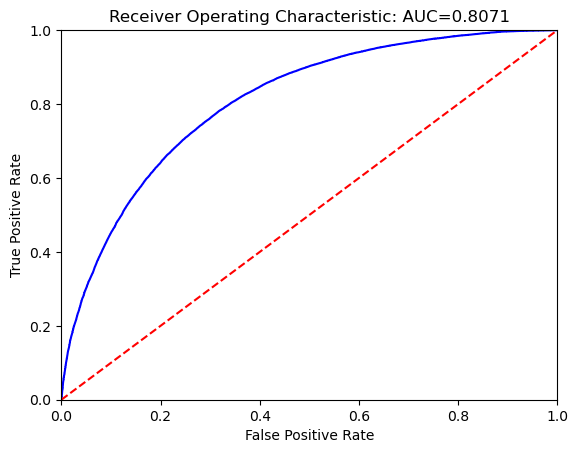

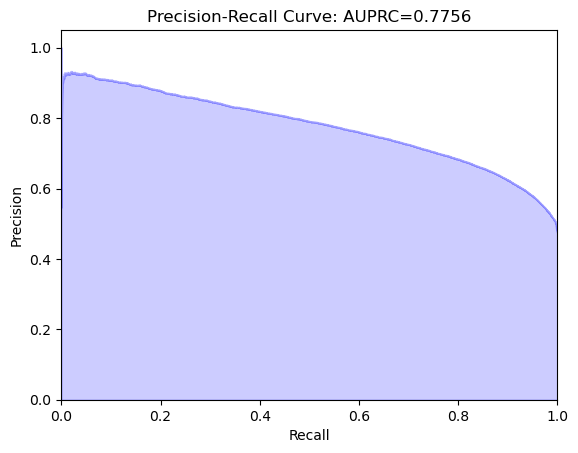

In [11]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
import pickle
with open('task1_logreg.pickle', 'wb') as model_dump:
    pickle.dump(logreg, model_dump)
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

model_default = make_pipeline(
    StandardScaler(),
    LogisticRegression(C=10.0, class_weight=None, random_state=42, max_iter=500)
)

model_balanced = make_pipeline(
    StandardScaler(),
    LogisticRegression(C=10.0, class_weight='balanced', random_state=42, max_iter=500)
)

auc_default = cross_val_score(model_default, X_train, y_train, cv=5, scoring='roc_auc')
auc_balanced = cross_val_score(model_balanced, X_train, y_train, cv=5, scoring='roc_auc')

print("AUC (No class_weight):", auc_default.mean())
print("AUC (Balanced class_weight):", auc_balanced.mean())


AUC (No class_weight): 0.8093330537537968
AUC (Balanced class_weight): 0.8093494866423026


In [13]:
best_model = model_balanced if auc_balanced.mean() > auc_default.mean() else model_default
best_model.fit(X_train, y_train)

from sklearn.metrics import roc_auc_score

y_test_proba = best_model.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, y_test_proba)
print("Test AUC:", auc_test)


Test AUC: 0.8118255706219156


In [14]:

from sklearn.model_selection import GridSearchCV

logreg_grid = LogisticRegression()

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear'],
    'penalty': ['l2'],
    'class_weight': ['balanced'],
    'max_iter': [500]
}

grid_search = GridSearchCV(
    estimator=logreg_grid,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Get the best model
best_logreg = grid_search.best_estimator_


Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [15]:
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'C': 10, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}


In [16]:
probs = best_logreg.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)


In [17]:
sensitive_feature = X_test['gender']


#0 = female 
#1 = male 

In [58]:
import numpy as np

def bootstrap_metric(metric_func, y_true, y_pred, sensitive_features=None, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    boot_metrics = []

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    if sensitive_features is not None:
        sensitive_features = np.array(sensitive_features)

    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), len(y_true), replace=True)
        if sensitive_features is not None:
            metric_value = metric_func(
                y_true[idx], y_pred[idx], sensitive_features=sensitive_features[idx]
            )
        else:
            metric_value = metric_func(y_true[idx], y_pred[idx])
        boot_metrics.append(metric_value)

    lower = np.percentile(boot_metrics, 100 * (alpha / 2))
    upper = np.percentile(boot_metrics, 100 * (1 - alpha / 2))
    mean_val = np.mean(boot_metrics)
    
    return mean_val, (lower, upper)


In [22]:
import numpy as np
from sklearn.metrics import accuracy_score
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)

def bootstrap_metric(metric_func, y_true, y_pred, sensitive_features=None, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    boot_metrics = []

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if sensitive_features is not None:
        sensitive_features = np.array(sensitive_features)

    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), len(y_true), replace=True)
        if sensitive_features is not None:
            metric_value = metric_func(y_true[idx], y_pred[idx], sensitive_features=sensitive_features[idx])
        else:
            metric_value = metric_func(y_true[idx], y_pred[idx])
        boot_metrics.append(metric_value)

    lower = np.percentile(boot_metrics, 100 * (alpha / 2))
    upper = np.percentile(boot_metrics, 100 * (1 - alpha / 2))
    mean_val = np.mean(boot_metrics)

    return mean_val, (lower, upper)

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test, y_pred)
dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test, y_pred, sensitive_feature)
eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test, y_pred, sensitive_feature)
eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test, y_pred, sensitive_feature)

print("\n=== Bootstrapped Metrics (Mean and 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== Bootstrapped Metrics (Mean and 95% CI) ===
Accuracy:              Mean = 0.733, CI = (0.730, 0.736)
Demographic Parity:    Mean = 0.107, CI = (0.101, 0.114)
Equal Opportunity:     Mean = 0.072, CI = (0.064, 0.082)
Equalized Odds:        Mean = 0.079, CI = (0.072, 0.087)


In [23]:
import numpy as np
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix
from fairlearn.metrics import selection_rate


def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) != 0 else 0


def bootstrap_group_metric(metric_func, y_true, y_pred, mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    boot_metrics = []
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = np.array(mask)

    for _ in range(n_boot):
        idx = np.random.choice(np.where(mask)[0], size=np.sum(mask), replace=True)
        metric = metric_func(y_true[idx], y_pred[idx])
        boot_metrics.append(metric)

    lower = np.percentile(boot_metrics, 100 * (alpha / 2))
    upper = np.percentile(boot_metrics, 100 * (1 - alpha / 2))
    mean_val = np.mean(boot_metrics)

    return mean_val, (lower, upper)


female_mask = (sensitive_feature == 0).values
male_mask = (sensitive_feature == 1).values
overall_mask = np.ones(len(y_test), dtype=bool)


sr_all_mean, sr_all_ci = bootstrap_group_metric(selection_rate, y_test, y_pred, overall_mask)
tpr_all_mean, tpr_all_ci = bootstrap_group_metric(recall_score, y_test, y_pred, overall_mask)
fpr_all_mean, fpr_all_ci = bootstrap_group_metric(false_positive_rate, y_test, y_pred, overall_mask)
acc_all_mean, acc_all_ci = bootstrap_group_metric(accuracy_score, y_test, y_pred, overall_mask)


sr_f_mean, sr_f_ci = bootstrap_group_metric(selection_rate, y_test, y_pred, female_mask)
tpr_f_mean, tpr_f_ci = bootstrap_group_metric(recall_score, y_test, y_pred, female_mask)
fpr_f_mean, fpr_f_ci = bootstrap_group_metric(false_positive_rate, y_test, y_pred, female_mask)
acc_f_mean, acc_f_ci = bootstrap_group_metric(accuracy_score, y_test, y_pred, female_mask)


sr_m_mean, sr_m_ci = bootstrap_group_metric(selection_rate, y_test, y_pred, male_mask)
tpr_m_mean, tpr_m_ci = bootstrap_group_metric(recall_score, y_test, y_pred, male_mask)
fpr_m_mean, fpr_m_ci = bootstrap_group_metric(false_positive_rate, y_test, y_pred, male_mask)
acc_m_mean, acc_m_ci = bootstrap_group_metric(accuracy_score, y_test, y_pred, male_mask)


print("\n=== Bootstrapped Metrics (Mean and 95% CI) by Gender Group ===")

print("Demographic Parity (Selection Rate):")
print(f"Selection Rate (Female): Mean = {sr_f_mean:.3f}  CI = ({sr_f_ci[0]:.3f}, {sr_f_ci[1]:.3f})")
print(f"Selection Rate (Male):   Mean = {sr_m_mean:.3f} CI = ({sr_m_ci[0]:.3f}, {sr_m_ci[1]:.3f})")

print("\nEqual Opportunity (TPR):")
print(f"True Positive Rate (Female): Mean = {tpr_f_mean:.3f} CI = ({tpr_f_ci[0]:.3f}, {tpr_f_ci[1]:.3f})")
print(f"True Positive Rate (Male):  Mean = {tpr_m_mean:.3f}  CI = ({tpr_m_ci[0]:.3f}, {tpr_m_ci[1]:.3f})")

print("\nEqualized Odds (FPR):")
print(f"False Positive Rate (Female): Mean = {fpr_f_mean:.3f}  CI = ({fpr_f_ci[0]:.3f}, {fpr_f_ci[1]:.3f})")
print(f"False Positive Rate (Male):  Mean = {fpr_m_mean:.3f}  CI = ({fpr_m_ci[0]:.3f}, {fpr_m_ci[1]:.3f})")

print("\nAccuracy:")
print(f"Accuracy (Female): Mean = {acc_f_mean:.3f}  CI = ({acc_f_ci[0]:.3f}, {acc_f_ci[1]:.3f})")
print(f"Accuracy (Male):  Mean = {acc_m_mean:.3f}  CI = ({acc_m_ci[0]:.3f}, {acc_m_ci[1]:.3f})")



=== Bootstrapped Metrics (Mean and 95% CI) by Gender Group ===
Demographic Parity (Selection Rate):
Selection Rate (Female): Mean = 0.426  CI = (0.421, 0.430)
Selection Rate (Male):   Mean = 0.533 CI = (0.528, 0.538)

Equal Opportunity (TPR):
True Positive Rate (Female): Mean = 0.682 CI = (0.676, 0.689)
True Positive Rate (Male):  Mean = 0.754  CI = (0.749, 0.760)

Equalized Odds (FPR):
False Positive Rate (Female): Mean = 0.220  CI = (0.215, 0.224)
False Positive Rate (Male):  Mean = 0.299  CI = (0.292, 0.305)

Accuracy:
Accuracy (Female): Mean = 0.737  CI = (0.733, 0.741)
Accuracy (Male):  Mean = 0.729  CI = (0.724, 0.733)


In [81]:
print(X_test.columns.tolist())


['age', 'gender', 'n_ed_30d', 'n_ed_90d', 'n_ed_365d', 'n_hosp_30d', 'n_hosp_90d', 'n_hosp_365d', 'n_icu_30d', 'n_icu_90d', 'n_icu_365d', 'triage_temperature', 'triage_heartrate', 'triage_resprate', 'triage_o2sat', 'triage_sbp', 'triage_dbp', 'triage_pain', 'triage_acuity', 'chiefcom_chest_pain', 'chiefcom_abdominal_pain', 'chiefcom_headache', 'chiefcom_shortness_of_breath', 'chiefcom_back_pain', 'chiefcom_cough', 'chiefcom_nausea_vomiting', 'chiefcom_fever_chills', 'chiefcom_syncope', 'chiefcom_dizziness', 'cci_MI', 'cci_CHF', 'cci_PVD', 'cci_Stroke', 'cci_Dementia', 'cci_Pulmonary', 'cci_Rheumatic', 'cci_PUD', 'cci_Liver1', 'cci_DM1', 'cci_DM2', 'cci_Paralysis', 'cci_Renal', 'cci_Cancer1', 'cci_Liver2', 'cci_Cancer2', 'cci_HIV', 'eci_Arrhythmia', 'eci_Valvular', 'eci_PHTN', 'eci_HTN1', 'eci_HTN2', 'eci_NeuroOther', 'eci_Hypothyroid', 'eci_Lymphoma', 'eci_Coagulopathy', 'eci_Obesity', 'eci_WeightLoss', 'eci_FluidsLytes', 'eci_BloodLoss', 'eci_Anemia', 'eci_Alcohol', 'eci_Drugs', 'eci_

In [16]:
ethnicity_raw = df_test['ethnicity']

# Filter out all of the NA, blank, and 'Unknown'
valid_mask = ethnicity_raw.notna() & (ethnicity_raw != '') & (ethnicity_raw.str.lower() != 'unknown')
ethnicity_clean = ethnicity_raw[valid_mask]

y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

# Map to 5 groups
ethnicity_grouped = ethnicity_clean.str.lower().map({
    'white': 'White',
    'asian': 'Asian',
    'black/african american': 'Black or African American',
    'hispanic/latino': 'Hispanic or Latino'
}).fillna('Other')


In [20]:
ethnicity_counts = ethnicity_grouped.value_counts()
print(ethnicity_counts)


ethnicity
White                        35865
Black or African American    12923
Hispanic or Latino            4546
Other                         2793
Asian                         1923
Name: count, dtype: int64


In [25]:
acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test_clean, y_pred_clean, sensitive_features=ethnicity_grouped)
eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test_clean, y_pred_clean, sensitive_features=ethnicity_grouped)
eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test_clean, y_pred_clean, sensitive_features=ethnicity_grouped)


print("\n=== Bootstrapped Fairness & Accuracy Metrics by Ethnicity Group ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")


=== Bootstrapped Fairness & Accuracy Metrics by Ethnicity Group ===
Accuracy:              Mean = 0.683, CI = (0.679, 0.686)
Demographic Parity:    Mean = 0.220, CI = (0.204, 0.236)
Equal Opportunity:     Mean = 0.133, CI = (0.116, 0.152)
Equalized Odds:        Mean = 0.214, CI = (0.190, 0.237)


In [26]:
import numpy as np

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    values = []

    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))
    
    return values[0], mean, (ci_lower, ci_upper)  # first = original value


def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

In [27]:
import pandas as pd

group_metrics = []
group_names = ethnicity_grouped.unique()

for group in group_names:
    mask = (ethnicity_grouped == group).values

    sr_orig, sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_clean, y_pred_clean, mask)
    tpr_orig, tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_clean, y_pred_clean, mask)
    fpr_orig, fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_clean, y_pred_clean, mask)
    acc_orig, acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_clean, y_pred_clean, mask)

    group_metrics.append({
        'Ethnicity': group,
        'SR_Orig': sr_orig, 'SR_Mean': sr_mean, 'SR_CI': sr_ci,
        'TPR_Orig': tpr_orig, 'TPR_Mean': tpr_mean, 'TPR_CI': tpr_ci,
        'FPR_Orig': fpr_orig, 'FPR_Mean': fpr_mean, 'FPR_CI': fpr_ci,
        'ACC_Orig': acc_orig, 'ACC_Mean': acc_mean, 'ACC_CI': acc_ci,
    })

df_ethnicity_metrics = pd.DataFrame(group_metrics)

print("\n=== Demographic Parity (Selection Rate) ===")
for _, row in df_ethnicity_metrics.iterrows():
    ci_low, ci_high = row['SR_CI']
    print(f"{row['Ethnicity']}: Mean = {row['SR_Mean']:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")

print("\n=== Equal Opportunity (TPR) ===")
for _, row in df_ethnicity_metrics.iterrows():
    ci_low, ci_high = row['TPR_CI']
    print(f"{row['Ethnicity']}: Mean = {row['TPR_Mean']:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")

print("\n=== Equalized Odds (FPR) ===")
for _, row in df_ethnicity_metrics.iterrows():
    ci_low, ci_high = row['FPR_CI']
    print(f"{row['Ethnicity']}: Mean = {row['FPR_Mean']:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")

print("\n=== Accuracy by Ethnicity ===")
for _, row in df_ethnicity_metrics.iterrows():
    ci_low, ci_high = row['ACC_CI']
    print(f"{row['Ethnicity']}: Mean = {row['ACC_Mean']:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Demographic Parity (Selection Rate) ===
White: Mean = 0.693, CI = (0.689, 0.698)
Black or African American: Mean = 0.533, CI = (0.525, 0.542)
Asian: Mean = 0.604, CI = (0.581, 0.627)
Hispanic or Latino: Mean = 0.474, CI = (0.459, 0.488)
Other: Mean = 0.560, CI = (0.542, 0.578)

=== Equal Opportunity (TPR) ===
White: Mean = 0.751, CI = (0.746, 0.756)
Black or African American: Mean = 0.668, CI = (0.658, 0.678)
Asian: Mean = 0.654, CI = (0.629, 0.679)
Hispanic or Latino: Mean = 0.620, CI = (0.602, 0.639)
Other: Mean = 0.631, CI = (0.611, 0.650)

=== Equalized Odds (FPR) ===
White: Mean = 0.498, CI = (0.486, 0.509)
Black or African American: Mean = 0.321, CI = (0.309, 0.333)
Asian: Mean = 0.416, CI = (0.369, 0.462)
Hispanic or Latino: Mean = 0.287, CI = (0.266, 0.308)
Other: Mean = 0.304, CI = (0.268, 0.340)

=== Accuracy by Ethnicity ===
White: Mean = 0.695, CI = (0.690, 0.700)
Black or African American: Mean = 0.672, CI = (0.664, 0.680)
Asian: Mean = 0.639, CI = (0.616, 0.662)
Hisp

In [28]:
age_raw = X_test['age']
valid_mask = age_raw.notna()  

age_clean = age_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)

# dpd_orig = demographic_parity_difference(y_test_clean, y_pred_clean, sensitive_features=age_clean)
# eopp_orig = equal_opportunity_difference(y_test_clean, y_pred_clean, sensitive_features=age_clean)
# eod_orig = equalized_odds_difference(y_test_clean, y_pred_clean, sensitive_features=age_clean)


In [29]:
acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test, y_pred)
dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test, y_pred, sensitive_features=age_clean)
eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test, y_pred, sensitive_features=age_clean)
eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test, y_pred, sensitive_features=age_clean)

print("\n=== Bootstrapped Metrics (Mean and 95% CI) by Age ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== Bootstrapped Metrics (Mean and 95% CI) by Age ===
Accuracy:              Mean = 0.733, CI = (0.730, 0.736)
Demographic Parity:    Mean = 0.947, CI = (0.930, 0.964)
Equal Opportunity:     Mean = 0.919, CI = (0.868, 1.000)
Equalized Odds:        Mean = 0.997, CI = (0.962, 1.000)


In [30]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from fairlearn.metrics import selection_rate

# --- Custom function: false positive rate ---
def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) != 0 else 0

# --- Bootstrap metric for a masked group ---
def bootstrap_metric_per_group(metric_func, y_true, y_pred, mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    metrics = []

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = np.array(mask)

    for _ in range(n_boot):
        idx = np.random.choice(np.where(mask)[0], size=np.sum(mask), replace=True)
        metric = metric_func(y_true[idx], y_pred[idx])
        metrics.append(metric)

    lower = np.percentile(metrics, 100 * (alpha / 2))
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    mean_val = np.mean(metrics)

    return mean_val, (lower, upper)

# --- Define age bins ---
age_bins = [0, 17, 24, 34, 44, 54, 64, 74, float('inf')]
age_labels = ['0‚Äì17', '18‚Äì24', '25‚Äì34', '35‚Äì44', '45‚Äì54', '55‚Äì64', '65‚Äì74', '75+']
age_grouped = pd.cut(X_test['age'], bins=age_bins, labels=age_labels, right=True)

# --- Clean up missing data ---
valid_mask = age_grouped.notna()
y_test_age = y_test[valid_mask]
y_pred_age = y_pred[valid_mask]
age_grouped_clean = age_grouped[valid_mask]

# --- Compute metrics for each group ---
group_metrics = []

for group in age_labels:
    mask = (age_grouped_clean == group).values

    if mask.sum() == 0:
        group_metrics.append({
            'Age Group': group,
            'Accuracy': (np.nan, (np.nan, np.nan)),
            'Selection Rate': (np.nan, (np.nan, np.nan)),
            'TPR (Recall)': (np.nan, (np.nan, np.nan)),
            'FPR': (np.nan, (np.nan, np.nan))
        })
        continue

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_age, y_pred_age, mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_age, y_pred_age, mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_age, y_pred_age, mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_age, y_pred_age, mask)

    group_metrics.append({
        'Age Group': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })


# --- Display Results ---
print("\n=== Bootstrapped Metrics by Age Group (Mean and 95% CI) ===")
for row in group_metrics:
    print(f"\nAge Group: {row['Age Group']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        if pd.isna(mean):
            print(f"{metric_name:<17} No data available")
        else:
            print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Bootstrapped Metrics by Age Group (Mean and 95% CI) ===

Age Group: 0‚Äì17
Accuracy          No data available
Selection Rate    No data available
TPR (Recall)      No data available
FPR               No data available

Age Group: 18‚Äì24
Accuracy          Mean = 0.782, CI = (0.773, 0.791)
Selection Rate    Mean = 0.085, CI = (0.080, 0.091)
TPR (Recall)      Mean = 0.212, CI = (0.194, 0.229)
FPR               Mean = 0.048, CI = (0.043, 0.052)

Age Group: 25‚Äì34
Accuracy          Mean = 0.762, CI = (0.755, 0.768)
Selection Rate    Mean = 0.165, CI = (0.159, 0.171)
TPR (Recall)      Mean = 0.368, CI = (0.353, 0.382)
FPR               Mean = 0.087, CI = (0.082, 0.093)

Age Group: 35‚Äì44
Accuracy          Mean = 0.728, CI = (0.719, 0.737)
Selection Rate    Mean = 0.278, CI = (0.269, 0.287)
TPR (Recall)      Mean = 0.509, CI = (0.493, 0.524)
FPR               Mean = 0.150, CI = (0.141, 0.159)

Age Group: 45‚Äì54
Accuracy          Mean = 0.707, CI = (0.699, 0.714)
Selection Rate    Me

In [31]:
insurance_raw = df_test['insurance']  


valid_mask = (
    insurance_raw.notna() &
    (insurance_raw != '') &
    (insurance_raw.str.lower() != 'unknown')
)


insurance_clean = insurance_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]


insurance_grouped = insurance_clean.str.lower().map({
    'medicaid': 'Medicaid',
    'medicare': 'Medicare'
}).fillna('Other')


In [33]:
insurance_count= insurance_grouped.value_counts()
print(insurance_count)

insurance
Other       22426
Medicare    16530
Medicaid     3853
Name: count, dtype: int64


In [34]:
acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test_clean, y_pred_clean, sensitive_features=insurance_grouped)
eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test_clean, y_pred_clean, sensitive_features=insurance_grouped)
eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test_clean, y_pred_clean, sensitive_features=insurance_grouped)


print("\n=== Bootstrapped Fairness & Accuracy Metrics by Insurance ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")


=== Bootstrapped Fairness & Accuracy Metrics by Insurance ===
Accuracy:              Mean = 0.718, CI = (0.714, 0.722)
Demographic Parity:    Mean = 0.250, CI = (0.238, 0.265)
Equal Opportunity:     Mean = 0.250, CI = (0.238, 0.265)
Equalized Odds:        Mean = 0.250, CI = (0.238, 0.265)


In [99]:
#when insurance is not differentiated and all grouped together 

#this model is fairly reliable on averge across everyone without breaking down into insurance categories.

#25% disparity between different insurance groups
#25% disparity in ability to correctly predict true hospitalization across insurance types.
#25% disparity combining false positive rate and true positive rate fairness.

In [35]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from fairlearn.metrics import selection_rate

# --- Define FPR ---
def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

# --- Bootstrap function for a specific group ---
def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    values = []

    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))
    
    return values[0], mean, (ci_lower, ci_upper)  # return original, mean, CI

# --- Compute group-wise metrics for insurance ---
group_metrics = []
group_names = insurance_grouped.unique()  # insurance_grouped should be preprocessed like you did earlier

for group in group_names:
    mask = (insurance_grouped == group).values

    sr_orig, sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_clean, y_pred_clean, mask)
    tpr_orig, tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_clean, y_pred_clean, mask)
    fpr_orig, fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_clean, y_pred_clean, mask)
    acc_orig, acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_clean, y_pred_clean, mask)

    group_metrics.append({
        'Insurance': group,
        'SR_Orig': sr_orig, 'SR_Mean': sr_mean, 'SR_CI': sr_ci,
        'TPR_Orig': tpr_orig, 'TPR_Mean': tpr_mean, 'TPR_CI': tpr_ci,
        'FPR_Orig': fpr_orig, 'FPR_Mean': fpr_mean, 'FPR_CI': fpr_ci,
        'ACC_Orig': acc_orig, 'ACC_Mean': acc_mean, 'ACC_CI': acc_ci,
    })

df_insurance_metrics = pd.DataFrame(group_metrics)

# --- Print results ---
print("\n=== Demographic Parity (Selection Rate) ===")
for _, row in df_insurance_metrics.iterrows():
    ci_low, ci_high = row['SR_CI']
    print(f"{row['Insurance']}: Mean = {row['SR_Mean']:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")

print("\n=== Equal Opportunity (TPR) ===")
for _, row in df_insurance_metrics.iterrows():
    ci_low, ci_high = row['TPR_CI']
    print(f"{row['Insurance']}: Mean = {row['TPR_Mean']:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")

print("\n=== Equalized Odds (FPR) ===")
for _, row in df_insurance_metrics.iterrows():
    ci_low, ci_high = row['FPR_CI']
    print(f"{row['Insurance']}: Mean = {row['FPR_Mean']:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")

print("\n=== Accuracy by Insurance ===")
for _, row in df_insurance_metrics.iterrows():
    ci_low, ci_high = row['ACC_CI']
    print(f"{row['Insurance']}: Mean = {row['ACC_Mean']:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Demographic Parity (Selection Rate) ===
Medicaid: Mean = 0.617, CI = (0.602, 0.632)
Medicare: Mean = 0.867, CI = (0.861, 0.872)
Other: Mean = 0.625, CI = (0.619, 0.631)

=== Equal Opportunity (TPR) ===
Medicaid: Mean = 0.617, CI = (0.602, 0.632)
Medicare: Mean = 0.867, CI = (0.861, 0.872)
Other: Mean = 0.625, CI = (0.619, 0.631)

=== Equalized Odds (FPR) ===
Medicaid: Mean = 0.000, CI = (0.000, 0.000)
Medicare: Mean = 0.000, CI = (0.000, 0.000)
Other: Mean = 0.000, CI = (0.000, 0.000)

=== Accuracy by Insurance ===
Medicaid: Mean = 0.617, CI = (0.602, 0.632)
Medicare: Mean = 0.867, CI = (0.861, 0.872)
Other: Mean = 0.625, CI = (0.619, 0.631)


In [98]:
# FPR for insurnace have no fariness issues?

In [94]:
import pandas as pd

df_gender_plot = pd.DataFrame({
    'Group': ['Female', 'Male'] * 4,    # üî• Repeat Female/Male for 4 metrics
    'Metric': ['Selection Rate']*2 + ['TPR']*2 + ['FPR']*2 + ['Accuracy']*2,
    'Mean': [
        sr_f_mean, sr_m_mean,
        tpr_f_mean, tpr_m_mean,
        fpr_f_mean, fpr_m_mean,
        acc_f_mean, acc_m_mean
    ],
    'Lower': [
        sr_f_ci[0], sr_m_ci[0],
        tpr_f_ci[0], tpr_m_ci[0],
        fpr_f_ci[0], fpr_m_ci[0],
        acc_f_ci[0], acc_m_ci[0]
    ],
    'Upper': [
        sr_f_ci[1], sr_m_ci[1],
        tpr_f_ci[1], tpr_m_ci[1],
        fpr_f_ci[1], fpr_m_ci[1],
        acc_f_ci[1], acc_m_ci[1]
    ]
})

df_gender_plot['Error Lower'] = df_gender_plot['Mean'] - df_gender_plot['Lower']
df_gender_plot['Error Upper'] = df_gender_plot['Upper'] - df_gender_plot['Mean']


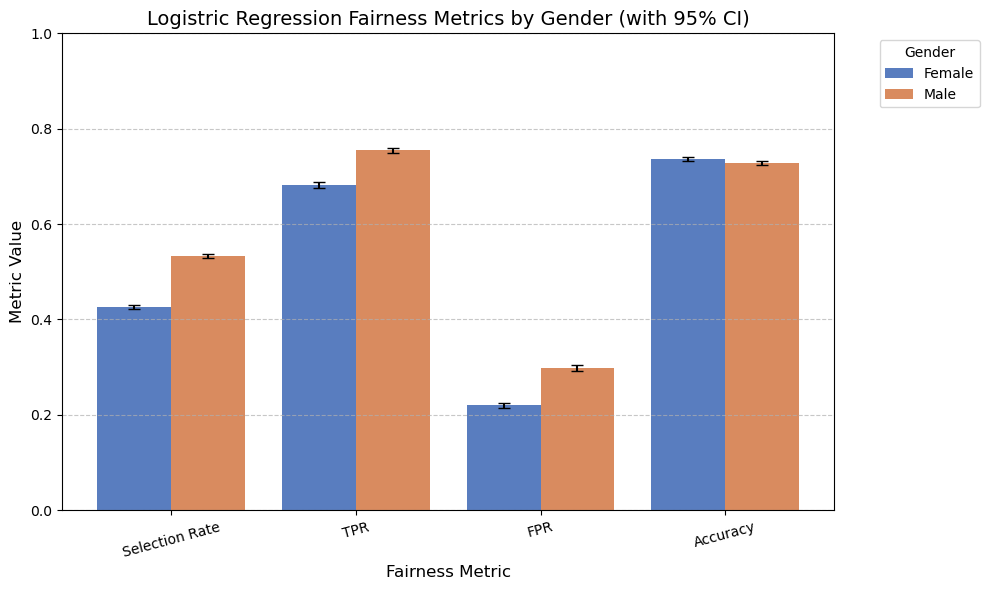

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.barplot(
    data=df_gender_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None, 
    capsize=0.2
)

metric_list = df_gender_plot['Metric'].unique()
group_list = df_gender_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_gender_plot[df_gender_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        plt.errorbar(
            x=i - 0.4 + group_width/2 + j*group_width,
            y=row['Mean'],
            yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
            fmt='none',
            ecolor='black',
            elinewidth=1.5,
            capsize=4
        )


plt.ylim(0, 1)
plt.title('Logistric Regression Fairness Metrics by Gender (with 95% CI)', fontsize=14)
plt.xlabel('Fairness Metric', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


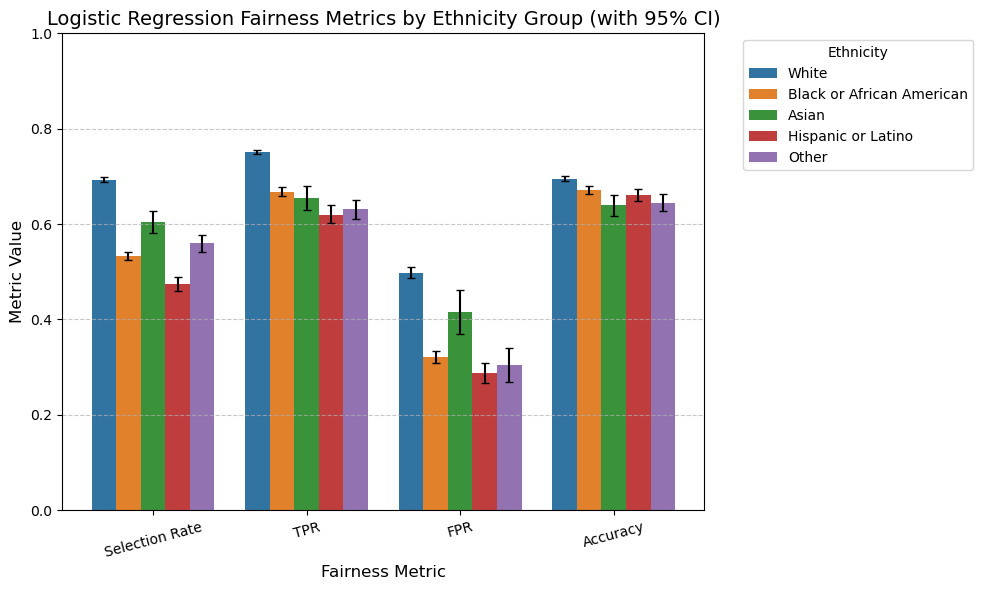

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# 1. Draw the grouped barplot without internal error bars
sns.barplot(
    data=df_ethnicity_plot, 
    x='Metric', 
    y='Mean', 
    hue='Group',     
    errorbar=None, 
    capsize=0.2,
)

# 2. Manually add custom error bars
# Loop through each group and add error bars individually
metric_list = df_ethnicity_plot['Metric'].unique()
group_list = df_ethnicity_plot['Group'].unique()

# Calculate x-locations
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups  # control how wide the grouped bars are

for i, metric in enumerate(metric_list):
    subset = df_ethnicity_plot[df_ethnicity_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        plt.errorbar(
            x=i - 0.4 + group_width/2 + j*group_width,  # x position
            y=row['Mean'],
            yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
            fmt='none',
            ecolor='black',
            capsize=3,
            elinewidth=1.5,
        )

# 3. Beautify
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.title('Logistic Regression Fairness Metrics by Ethnicity Group (with 95% CI)', fontsize=14)
plt.xlabel('Fairness Metric', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [85]:
print(df_age.columns)


Index(['Group', 'SR_Orig', 'SR_Mean', 'SR_CI', 'TPR_Orig', 'TPR_Mean',
       'TPR_CI', 'FPR_Orig', 'FPR_Mean', 'FPR_CI', 'ACC_Orig', 'ACC_Mean',
       'ACC_CI'],
      dtype='object')


In [118]:
group_metrics = []

for group in age_labels:
    mask = (age_grouped_clean == group).values

    if mask.sum() == 0:
        group_metrics.append({
            'Group': group,
            'SR_Mean': np.nan, 'SR_CI': (np.nan, np.nan),
            'TPR_Mean': np.nan, 'TPR_CI': (np.nan, np.nan),
            'FPR_Mean': np.nan, 'FPR_CI': (np.nan, np.nan),
            'ACC_Mean': np.nan, 'ACC_CI': (np.nan, np.nan)
        })
        continue

    sr_orig, sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_age, y_pred_age, mask)
    tpr_orig, tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_age, y_pred_age, mask)
    fpr_orig, fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_age, y_pred_age, mask)
    acc_orig, acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_age, y_pred_age, mask)

    group_metrics.append({
        'Group': group,
        'SR_Mean': sr_mean, 'SR_CI': sr_ci,
        'TPR_Mean': tpr_mean, 'TPR_CI': tpr_ci,
        'FPR_Mean': fpr_mean, 'FPR_CI': fpr_ci,
        'ACC_Mean': acc_mean, 'ACC_CI': acc_ci
    })

    import pandas as pd

df_age = pd.DataFrame(group_metrics)

df_age_plot = pd.DataFrame({
    'Group': list(df_age['Group']) * 4,  
    'Metric': ['Selection Rate'] * len(df_age) + 
              ['TPR (Recall)'] * len(df_age) + 
              ['FPR'] * len(df_age) + 
              ['Accuracy'] * len(df_age),
    'Mean': list(df_age['SR_Mean']) + 
            list(df_age['TPR_Mean']) +
            list(df_age['FPR_Mean']) +
            list(df_age['ACC_Mean']),
    'Lower': [ci[0] for ci in df_age['SR_CI']] + 
             [ci[0] for ci in df_age['TPR_CI']] +
             [ci[0] for ci in df_age['FPR_CI']] +
             [ci[0] for ci in df_age['ACC_CI']],
    'Upper': [ci[1] for ci in df_age['SR_CI']] + 
             [ci[1] for ci in df_age['TPR_CI']] +
             [ci[1] for ci in df_age['FPR_CI']] +
             [ci[1] for ci in df_age['ACC_CI']]
})

df_age_plot['Error Lower'] = df_age_plot['Mean'] - df_age_plot['Lower']
df_age_plot['Error Upper'] = df_age_plot['Upper'] - df_age_plot['Mean']


/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


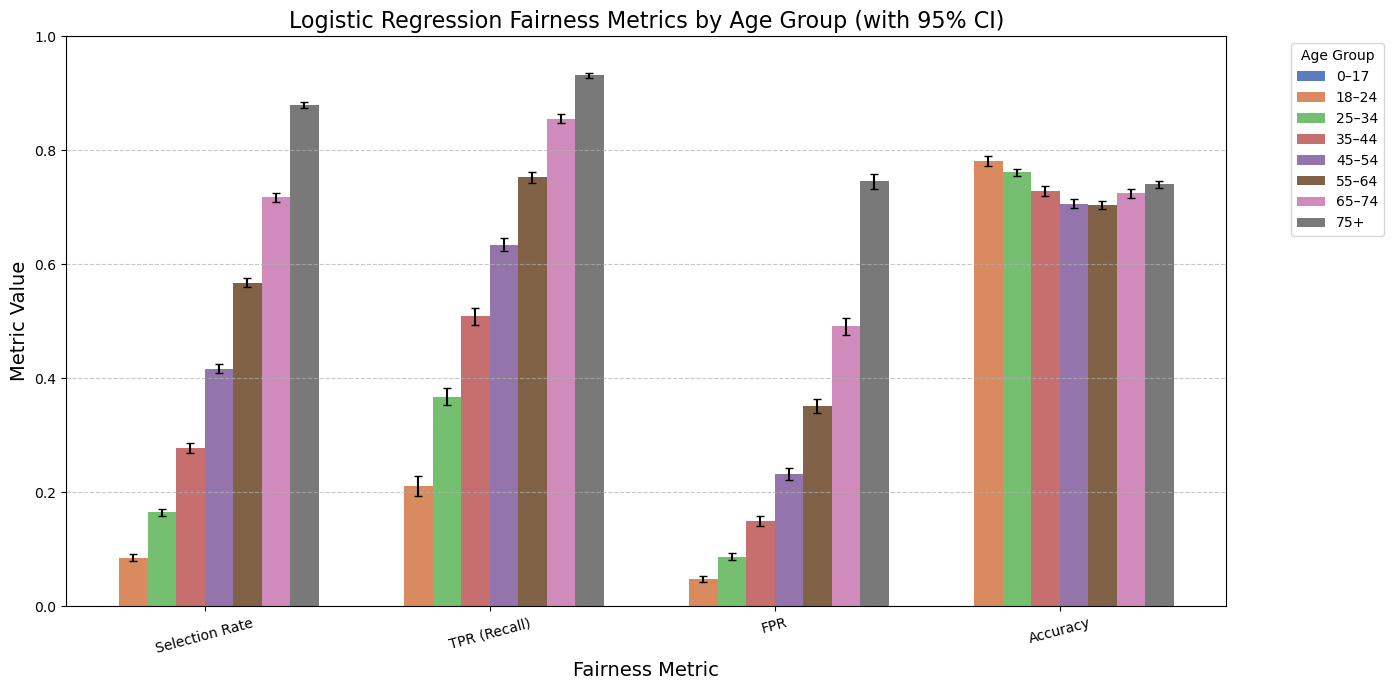

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))

sns.barplot(
    data=df_age_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,  
    capsize=0.2
)

metric_list = df_age_plot['Metric'].unique()
group_list = df_age_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_age_plot[df_age_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        plt.errorbar(
            x=i - 0.4 + group_width/2 + j*group_width,
            y=row['Mean'],
            yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
            fmt='none',
            ecolor='black',
            elinewidth=1.5,
            capsize=3
        )

plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.title('Logistic Regression Fairness Metrics by Age Group (with 95% CI)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [96]:
df_insurance_plot = pd.DataFrame({
    'Group': list(df_insurance_metrics['Insurance']) * 4, 
    'Metric': (
        ['Selection Rate'] * len(df_insurance_metrics) +
        ['TPR'] * len(df_insurance_metrics) +
        ['FPR'] * len(df_insurance_metrics) +
        ['Accuracy'] * len(df_insurance_metrics)
    ),
    'Mean': (
        list(df_insurance_metrics['SR_Mean']) +
        list(df_insurance_metrics['TPR_Mean']) +
        list(df_insurance_metrics['FPR_Mean']) +
        list(df_insurance_metrics['ACC_Mean'])
    ),
    'Lower': (
        [ci[0] for ci in df_insurance_metrics['SR_CI']] +
        [ci[0] for ci in df_insurance_metrics['TPR_CI']] +
        [ci[0] for ci in df_insurance_metrics['FPR_CI']] +
        [ci[0] for ci in df_insurance_metrics['ACC_CI']]
    ),
    'Upper': (
        [ci[1] for ci in df_insurance_metrics['SR_CI']] +
        [ci[1] for ci in df_insurance_metrics['TPR_CI']] +
        [ci[1] for ci in df_insurance_metrics['FPR_CI']] +
        [ci[1] for ci in df_insurance_metrics['ACC_CI']]
    )
})

df_insurance_plot['Error Lower'] = df_insurance_plot['Mean'] - df_insurance_plot['Lower']
df_insurance_plot['Error Upper'] = df_insurance_plot['Upper'] - df_insurance_plot['Mean']


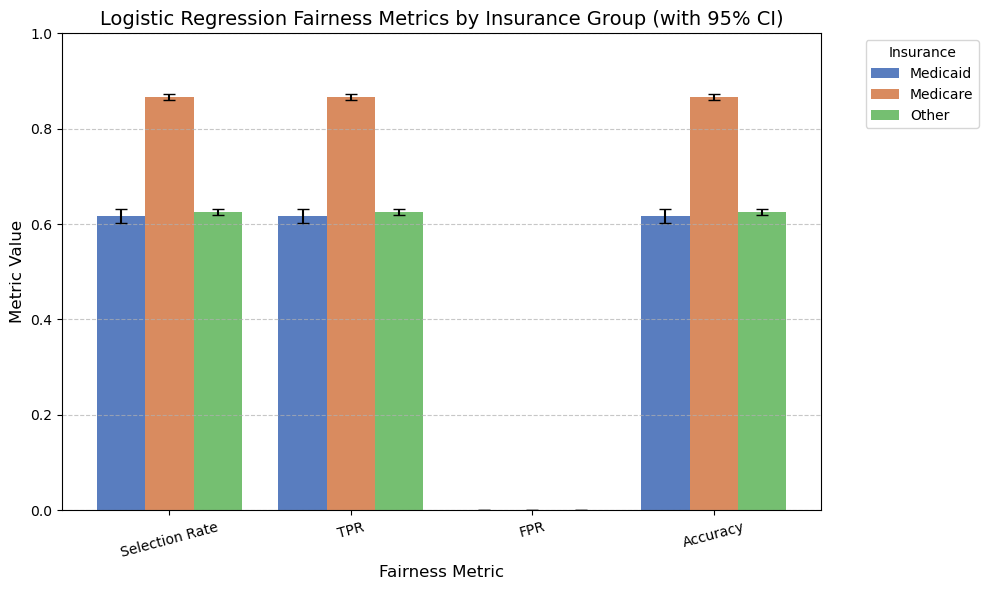

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))


sns.barplot(
    data=df_insurance_plot,
    x='Metric',
    y='Mean',
    hue='Group',     
    palette='muted',
    errorbar=None,
    capsize=0.2
)


metric_list = df_insurance_plot['Metric'].unique()
group_list = df_insurance_plot['Group'].unique()

n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_insurance_plot[df_insurance_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        plt.errorbar(
            x=i - 0.4 + group_width/2 + j*group_width,
            y=row['Mean'],
            yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
            fmt='none',
            ecolor='black',
            capsize=4,
            elinewidth=1.5
        )


plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.title('Logistic Regression Fairness Metrics by Insurance Group (with 95% CI)', fontsize=14)
plt.xlabel('Fairness Metric', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Insurance', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


RandomForest:
Training time: 72.34258460998535 seconds
AUC: 0.8197233861395832
AUPRC: 0.7868599403365448
Sensitivity: 0.7512497080121467
Specificity: 0.7376839683925795
Score thresold: 0.498
2.5 97.5


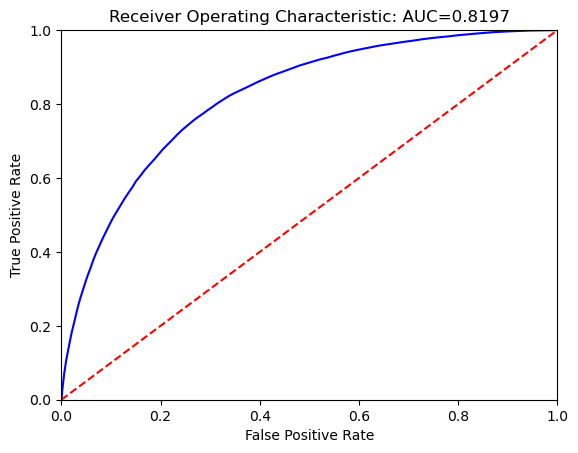

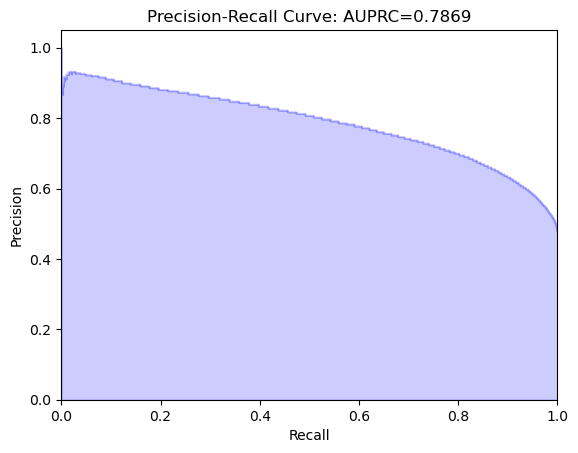

[0.12415777 0.01288518 0.00756089 0.0114081  0.02209293 0.0061509
 0.01438601 0.0282988  0.00076611 0.00179287 0.0050363  0.07793399
 0.08445447 0.04024207 0.04737683 0.08594139 0.08243049 0.04951439
 0.11291072 0.00698566 0.00896571 0.0049689  0.0005434  0.00422316
 0.00278781 0.00383114 0.00421012 0.00342267 0.00404684 0.0034602
 0.00550603 0.00292713 0.00303391 0.00143548 0.0062083  0.00216886
 0.00148508 0.00383176 0.00593042 0.00347398 0.0012109  0.0061037
 0.00442188 0.00137822 0.00203973 0.00108738 0.00810434 0.00271293
 0.00243687 0.0044548  0.01010546 0.00444447 0.00424056 0.00097929
 0.00370756 0.00479276 0.00347519 0.01164388 0.00114055 0.00336456
 0.00472488 0.00419452 0.00277252 0.00767628]


In [121]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [122]:
y_pred = (probs[:, 1] >= 0.5).astype(int)  


gender_raw = df_test['gender']

valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
gender_clean = gender_raw[valid_mask]

gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})



In [123]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score


acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_gender, y_pred_gender)
dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)
eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)
eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)

print("\n=== Random Forest - Fairness Metrics by Gender (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== Random Forest - Fairness Metrics by Gender (Mean + 95% CI) ===
Accuracy:              Mean = 0.744, CI = (0.741, 0.747)
Demographic Parity:    Mean = 0.100, CI = (0.093, 0.106)
Equal Opportunity:     Mean = 0.065, CI = (0.057, 0.073)
Equalized Odds:        Mean = 0.069, CI = (0.062, 0.076)


In [124]:
from sklearn.metrics import recall_score, confusion_matrix
from fairlearn.metrics import selection_rate


def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) != 0 else 0


def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    values = []

    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_lower, ci_upper)


female_mask = (gender_grouped == 0).values 
male_mask = (gender_grouped == 1).values    


metrics = {}

for label, mask in zip(['Female', 'Male'], [female_mask, male_mask]):
    metrics[label] = {
        'Accuracy': bootstrap_metric_per_group(accuracy_score, y_test_gender, y_pred_gender, mask),
        'Selection Rate': bootstrap_metric_per_group(selection_rate, y_test_gender, y_pred_gender, mask),
        'TPR (Recall)': bootstrap_metric_per_group(recall_score, y_test_gender, y_pred_gender, mask),
        'FPR': bootstrap_metric_per_group(false_positive_rate, y_test_gender, y_pred_gender, mask)
    }


print("\n=== Random Forest Per-Gender Metrics (Mean + 95% CI) ===")
for group, metric_dict in metrics.items():
    print(f"\n {group}:")
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        print(f"{metric_name:<16} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Random Forest Per-Gender Metrics (Mean + 95% CI) ===

 Female:
Accuracy         Mean = 0.745, CI = (0.741, 0.749)
Selection Rate   Mean = 0.450, CI = (0.445, 0.454)
TPR (Recall)     Mean = 0.719, CI = (0.713, 0.725)
FPR              Mean = 0.234, CI = (0.229, 0.239)

 Male:
Accuracy         Mean = 0.743, CI = (0.739, 0.747)
Selection Rate   Mean = 0.549, CI = (0.545, 0.554)
TPR (Recall)     Mean = 0.784, CI = (0.779, 0.789)
FPR              Mean = 0.301, CI = (0.295, 0.307)


In [125]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score


acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)
eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)
eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)


print("\n=== Random Forest - Fairness Metrics by Ethnicity (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== Random Forest - Fairness Metrics by Ethnicity (Mean + 95% CI) ===
Accuracy:              Mean = 0.683, CI = (0.679, 0.686)
Demographic Parity:    Mean = 0.220, CI = (0.204, 0.236)
Equal Opportunity:     Mean = 0.133, CI = (0.116, 0.152)
Equalized Odds:        Mean = 0.214, CI = (0.190, 0.237)


In [133]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score
from fairlearn.metrics import selection_rate
import numpy as np

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    values = []
    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_low = np.percentile(values, 100 * (alpha / 2))
    ci_high = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_low, ci_high)

ethnicity_raw = df_test['ethnicity']

valid_mask = ethnicity_raw.notna() & (ethnicity_raw != '') & (ethnicity_raw.str.lower() != 'unknown')

ethnicity_clean = ethnicity_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

ethnicity_grouped = ethnicity_clean.str.lower().map({
    'white': 'White',
    'asian': 'Asian',
    'black/african american': 'Black or African American',
    'hispanic/latino': 'Hispanic or Latino'
}).fillna('Other')


ethnicity_metrics = []


for group in ethnicity_grouped.unique():
    mask = (ethnicity_grouped == group).values

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_clean, y_pred_clean, mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_clean, y_pred_clean, mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_clean, y_pred_clean, mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_clean, y_pred_clean, mask)

    ethnicity_metrics.append({
        'Ethnicity': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== Metrics by Ethnicity Group (Mean + 95% CI) ===")
for row in ethnicity_metrics:
    print(f"\n Ethnicity: {row['Ethnicity']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Metrics by Ethnicity Group (Mean + 95% CI) ===

 Ethnicity: White
Accuracy          Mean = 0.711, CI = (0.707, 0.717)
Selection Rate    Mean = 0.714, CI = (0.710, 0.719)
TPR (Recall)      Mean = 0.776, CI = (0.771, 0.781)
FPR               Mean = 0.507, CI = (0.495, 0.518)

 Ethnicity: Black or African American
Accuracy          Mean = 0.681, CI = (0.673, 0.688)
Selection Rate    Mean = 0.567, CI = (0.558, 0.574)
TPR (Recall)      Mean = 0.702, CI = (0.691, 0.711)
FPR               Mean = 0.352, CI = (0.340, 0.365)

 Ethnicity: Asian
Accuracy          Mean = 0.687, CI = (0.666, 0.710)
Selection Rate    Mean = 0.659, CI = (0.638, 0.681)
TPR (Recall)      Mean = 0.720, CI = (0.697, 0.743)
FPR               Mean = 0.435, CI = (0.387, 0.480)

 Ethnicity: Hispanic or Latino
Accuracy          Mean = 0.674, CI = (0.659, 0.687)
Selection Rate    Mean = 0.513, CI = (0.498, 0.528)
TPR (Recall)      Mean = 0.666, CI = (0.648, 0.685)
FPR               Mean = 0.316, CI = (0.295, 0.336)

 Ethni

In [134]:
age_bins = [0, 17, 24, 34, 44, 54, 64, 74, float('inf')]
age_labels = ['0‚Äì17', '18‚Äì24', '25‚Äì34', '35‚Äì44', '45‚Äì54', '55‚Äì64', '65‚Äì74', '75+']


age_grouped = pd.cut(X_test['age'], bins=age_bins, labels=age_labels)


valid_mask = age_grouped.notna()


y_test_age = y_test[valid_mask]
y_pred_age = y_pred[valid_mask]
age_grouped_clean = age_grouped[valid_mask]

from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score


acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_age, y_pred_age)


dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_age, y_pred_age,
    sensitive_features=age_grouped_clean
)

eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_age, y_pred_age,
    sensitive_features=age_grouped_clean
)

eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_age, y_pred_age,
    sensitive_features=age_grouped_clean
)

print("\n=== Random Forest - Fairness Metrics by Age Group (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== Random Forest - Fairness Metrics by Age Group (Mean + 95% CI) ===
Accuracy:              Mean = 0.744, CI = (0.741, 0.747)
Demographic Parity:    Mean = 0.696, CI = (0.685, 0.705)
Equal Opportunity:     Mean = 0.475, CI = (0.457, 0.495)
Equalized Odds:        Mean = 0.625, CI = (0.610, 0.641)


In [135]:
age_bins = [0, 17, 24, 34, 44, 54, 64, 74, float('inf')]
age_labels = ['0‚Äì17', '18‚Äì24', '25‚Äì34', '35‚Äì44', '45‚Äì54', '55‚Äì64', '65‚Äì74', '75+']
age_grouped = pd.cut(X_test['age'], bins=age_bins, labels=age_labels, right=True)

valid_mask = age_grouped.notna()
y_test_age = y_test[valid_mask]
y_pred_age = y_pred[valid_mask]
age_grouped_clean = age_grouped[valid_mask]


def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = np.array(mask)

    if mask.sum() == 0:
        return np.nan, (np.nan, np.nan)

    metrics = []
    for _ in range(n_boot):
        idx = np.random.choice(np.where(mask)[0], size=np.sum(mask), replace=True)
        metrics.append(metric_func(y_true[idx], y_pred[idx]))

    lower = np.percentile(metrics, 100 * (alpha / 2))
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    mean_val = np.mean(metrics)

    return mean_val, (lower, upper)


group_metrics = []

for group in age_labels:
    mask = (age_grouped_clean == group).values

    if mask.sum() == 0:
        group_metrics.append({
            'Age Group': group,
            'Accuracy': (np.nan, (np.nan, np.nan)),
            'Selection Rate': (np.nan, (np.nan, np.nan)),
            'TPR (Recall)': (np.nan, (np.nan, np.nan)),
            'FPR': (np.nan, (np.nan, np.nan))
        })
        continue

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_age, y_pred_age, mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_age, y_pred_age, mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_age, y_pred_age, mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_age, y_pred_age, mask)

    group_metrics.append({
        'Age Group': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== Random Forest Bootstrapped Metrics by Age Group (Mean and 95% CI) ===")
for row in group_metrics:
    print(f"\nAge Group: {row['Age Group']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        if pd.isna(mean):
            print(f"{metric_name:<17} No data available")
        else:
            print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Random Forest Bootstrapped Metrics by Age Group (Mean and 95% CI) ===

Age Group: 0‚Äì17
Accuracy          No data available
Selection Rate    No data available
TPR (Recall)      No data available
FPR               No data available

Age Group: 18‚Äì24
Accuracy          Mean = 0.810, CI = (0.801, 0.818)
Selection Rate    Mean = 0.168, CI = (0.161, 0.175)
TPR (Recall)      Mean = 0.452, CI = (0.430, 0.473)
FPR               Mean = 0.083, CI = (0.076, 0.089)

Age Group: 25‚Äì34
Accuracy          Mean = 0.778, CI = (0.772, 0.785)
Selection Rate    Mean = 0.200, CI = (0.193, 0.207)
TPR (Recall)      Mean = 0.461, CI = (0.445, 0.476)
FPR               Mean = 0.100, CI = (0.094, 0.105)

Age Group: 35‚Äì44
Accuracy          Mean = 0.742, CI = (0.733, 0.750)
Selection Rate    Mean = 0.301, CI = (0.293, 0.310)
TPR (Recall)      Mean = 0.560, CI = (0.545, 0.576)
FPR               Mean = 0.157, CI = (0.149, 0.166)

Age Group: 45‚Äì54
Accuracy          Mean = 0.722, CI = (0.714, 0.729)
Select

In [136]:
insurance_raw = df_test['insurance']


valid_mask = (
    insurance_raw.notna() &
    (insurance_raw != '') &
    (insurance_raw.str.lower() != 'unknown')
)


insurance_clean = insurance_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]   


insurance_grouped = insurance_clean.str.lower().map({
    'medicaid': 'Medicaid',
    'medicare': 'Medicare'
}).fillna('Other')

from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score


acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test_clean, y_pred_clean, sensitive_features=insurance_grouped)
eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test_clean, y_pred_clean, sensitive_features=insurance_grouped)
eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test_clean, y_pred_clean, sensitive_features=insurance_grouped)

print("\n=== Random Forest - Bootstrapped Fairness & Accuracy Metrics by Insurance ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")




=== Random Forest - Bootstrapped Fairness & Accuracy Metrics by Insurance ===
Accuracy:              Mean = 0.751, CI = (0.747, 0.756)
Demographic Parity:    Mean = 0.200, CI = (0.191, 0.211)
Equal Opportunity:     Mean = 0.200, CI = (0.191, 0.211)
Equalized Odds:        Mean = 0.200, CI = (0.191, 0.211)


In [137]:
insurance_raw = df_test['insurance']

valid_mask = (
    insurance_raw.notna() &
    (insurance_raw != '') &
    (insurance_raw.str.lower() != 'unknown')
)

insurance_clean = insurance_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

insurance_grouped = insurance_clean.str.lower().map({
    'medicaid': 'Medicaid',
    'medicare': 'Medicare'
}).fillna('Other')

from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from fairlearn.metrics import selection_rate

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = np.array(mask)

    if mask.sum() == 0:
        return np.nan, (np.nan, np.nan)

    metrics = []
    for _ in range(n_boot):
        idx = np.random.choice(np.where(mask)[0], size=np.sum(mask), replace=True)
        metrics.append(metric_func(y_true[idx], y_pred[idx]))

    lower = np.percentile(metrics, 100 * (alpha / 2))
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    mean_val = np.mean(metrics)

    return mean_val, (lower, upper)

insurance_metrics = []

for group in insurance_grouped.unique():
    mask = (insurance_grouped == group).values

    if mask.sum() == 0:
        insurance_metrics.append({
            'Insurance Group': group,
            'Accuracy': (np.nan, (np.nan, np.nan)),
            'Selection Rate': (np.nan, (np.nan, np.nan)),
            'TPR (Recall)': (np.nan, (np.nan, np.nan)),
            'FPR': (np.nan, (np.nan, np.nan))
        })
        continue

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_clean, y_pred_clean, mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_clean, y_pred_clean, mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_clean, y_pred_clean, mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_clean, y_pred_clean, mask)

    insurance_metrics.append({
        'Insurance Group': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== Random Forest - Bootstrapped Metrics by Insurance Group (Mean and 95% CI) ===")
for row in insurance_metrics:
    print(f"\nInsurance Group: {row['Insurance Group']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        if pd.isna(mean):
            print(f"{metric_name:<17} No data available")
        else:
            print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Random Forest - Bootstrapped Metrics by Insurance Group (Mean and 95% CI) ===

Insurance Group: Medicaid
Accuracy          Mean = 0.676, CI = (0.661, 0.690)
Selection Rate    Mean = 0.676, CI = (0.661, 0.690)
TPR (Recall)      Mean = 0.676, CI = (0.661, 0.690)
FPR               Mean = 0.000, CI = (0.000, 0.000)

Insurance Group: Medicare
Accuracy          Mean = 0.872, CI = (0.867, 0.877)
Selection Rate    Mean = 0.872, CI = (0.867, 0.877)
TPR (Recall)      Mean = 0.872, CI = (0.867, 0.877)
FPR               Mean = 0.000, CI = (0.000, 0.000)

Insurance Group: Other
Accuracy          Mean = 0.675, CI = (0.670, 0.681)
Selection Rate    Mean = 0.675, CI = (0.670, 0.681)
TPR (Recall)      Mean = 0.675, CI = (0.670, 0.681)
FPR               Mean = 0.000, CI = (0.000, 0.000)


In [138]:
import pandas as pd

df_rf_gender_plot = []

for group, metric_dict in metrics.items():
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        df_rf_gender_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low,
            'Error Upper': ci_high - mean
        })

df_rf_gender_plot = pd.DataFrame(df_rf_gender_plot)


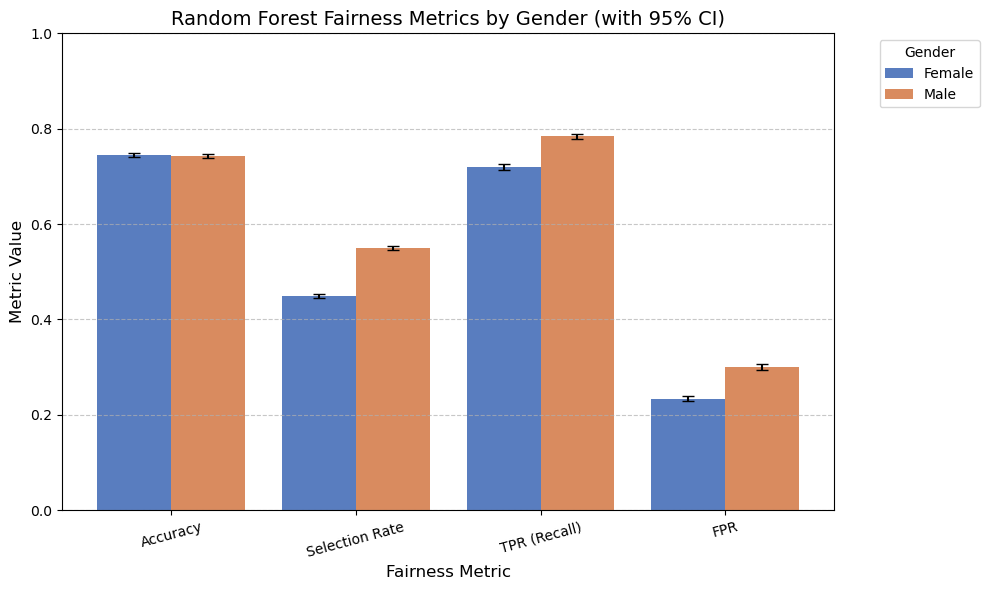

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 6))

sns.barplot(
    data=df_rf_gender_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_rf_gender_plot['Metric'].unique()
group_list = df_rf_gender_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_rf_gender_plot[df_rf_gender_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        plt.errorbar(
            x=i - 0.4 + group_width/2 + j*group_width,
            y=row['Mean'],
            yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
            fmt='none',
            ecolor='black',
            elinewidth=1.5,
            capsize=4
        )

plt.ylim(0, 1)
plt.title('Random Forest Fairness Metrics by Gender (with 95% CI)', fontsize=14)
plt.xlabel('Fairness Metric', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [144]:
df_ethnicity_plot = []

for row in ethnicity_metrics:
    ethnicity_group = row['Ethnicity'] 

    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:  # Only loop through metrics
        mean, (ci_low, ci_high) = row[metric_name]
        df_ethnicity_plot.append({
            'Group': ethnicity_group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if pd.notna(mean) else np.nan,
            'Error Upper': ci_high - mean if pd.notna(mean) else np.nan
        })

df_ethnicity_plot = pd.DataFrame(df_ethnicity_plot)


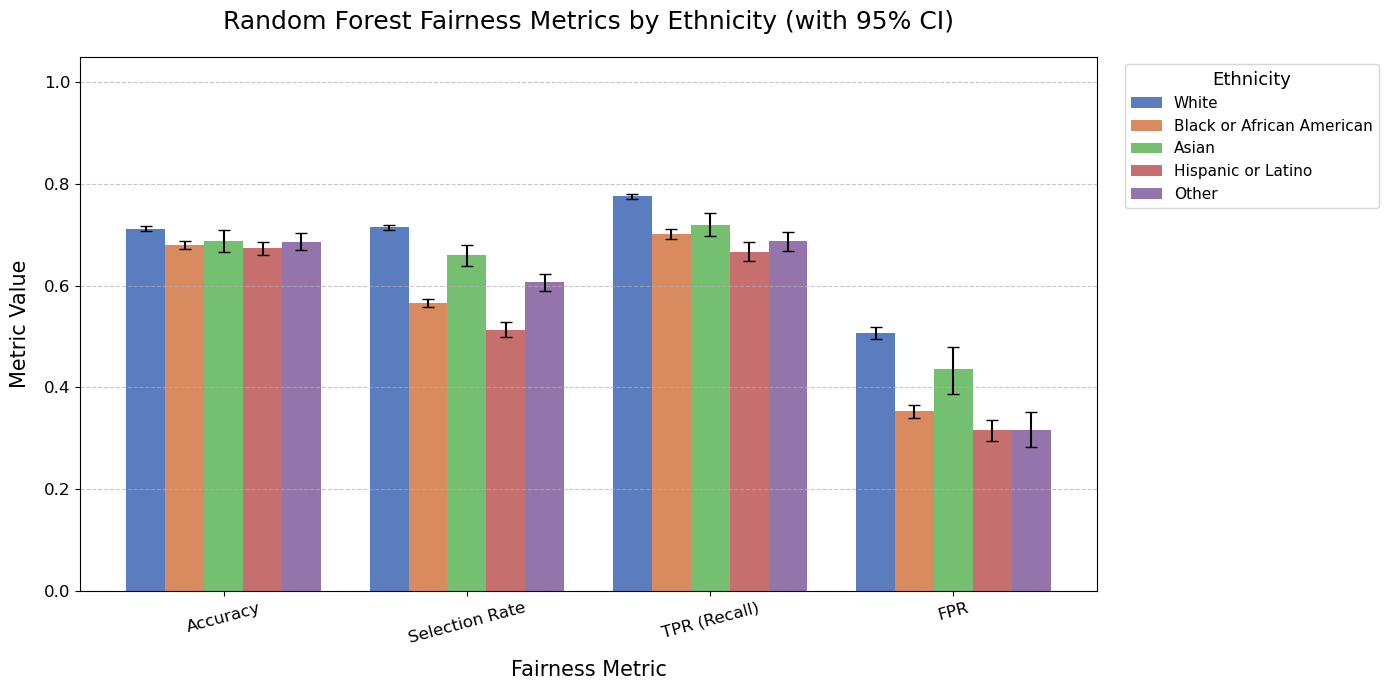

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(14, 7))

sns.barplot(
    data=df_ethnicity_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_ethnicity_plot['Metric'].unique()
group_list = df_ethnicity_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups  

for i, metric in enumerate(metric_list):
    subset = df_ethnicity_plot[df_ethnicity_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if pd.notna(row['Mean']):
            # Compute correct x-location manually
            x_loc = i - 0.4 + group_width / 2 + j * group_width
            plt.errorbar(
                x=x_loc,
                y=row['Mean'],
                yerr=[[row['Error Lower']], [row['Error Upper']]],
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1.05)
plt.title('Random Forest Fairness Metrics by Ethnicity (with 95% CI)', fontsize=18, pad=20)
plt.xlabel('Fairness Metric', fontsize=15, labelpad=10)
plt.ylabel('Metric Value', fontsize=15, labelpad=10)
plt.xticks(rotation=15, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend(
    title='Ethnicity',
    title_fontsize=13,
    fontsize=11,
    loc='upper left',
    bbox_to_anchor=(1.02, 1)
)

plt.tight_layout()
plt.show()


In [146]:
df_age_plot = []

for row in group_metrics:
    age_group = row['Age Group'] 

    # Now only loop over the metric part
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]   # Now safe
        df_age_plot.append({
            'Group': age_group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if pd.notna(mean) else np.nan,
            'Error Upper': ci_high - mean if pd.notna(mean) else np.nan
        })

df_age_plot = pd.DataFrame(df_age_plot)


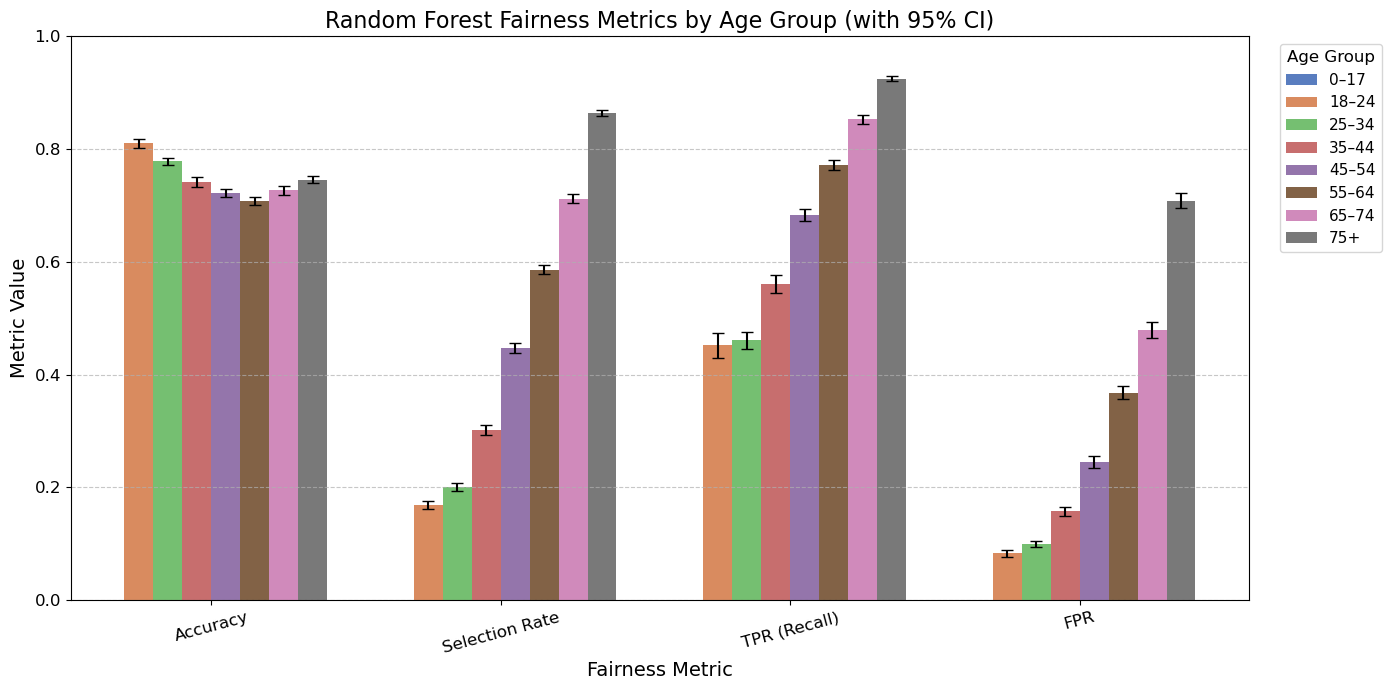

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(14, 7))  

sns.barplot(
    data=df_age_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,  
    capsize=0.2
)


metric_list = df_age_plot['Metric'].unique()
group_list = df_age_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_age_plot[df_age_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=[[row['Error Lower']], [row['Error Upper']]],
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.title('Random Forest Fairness Metrics by Age Group (with 95% CI)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.xticks(rotation=15, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Age Group', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=11, title_fontsize=12)
plt.tight_layout()
plt.show()


In [148]:
import pandas as pd

df_insurance_plot = []

for row in insurance_metrics:
    insurance_group = row['Insurance Group']
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        df_insurance_plot.append({
            'Group': insurance_group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if pd.notna(mean) else np.nan,
            'Error Upper': ci_high - mean if pd.notna(mean) else np.nan
        })

df_insurance_plot = pd.DataFrame(df_insurance_plot)


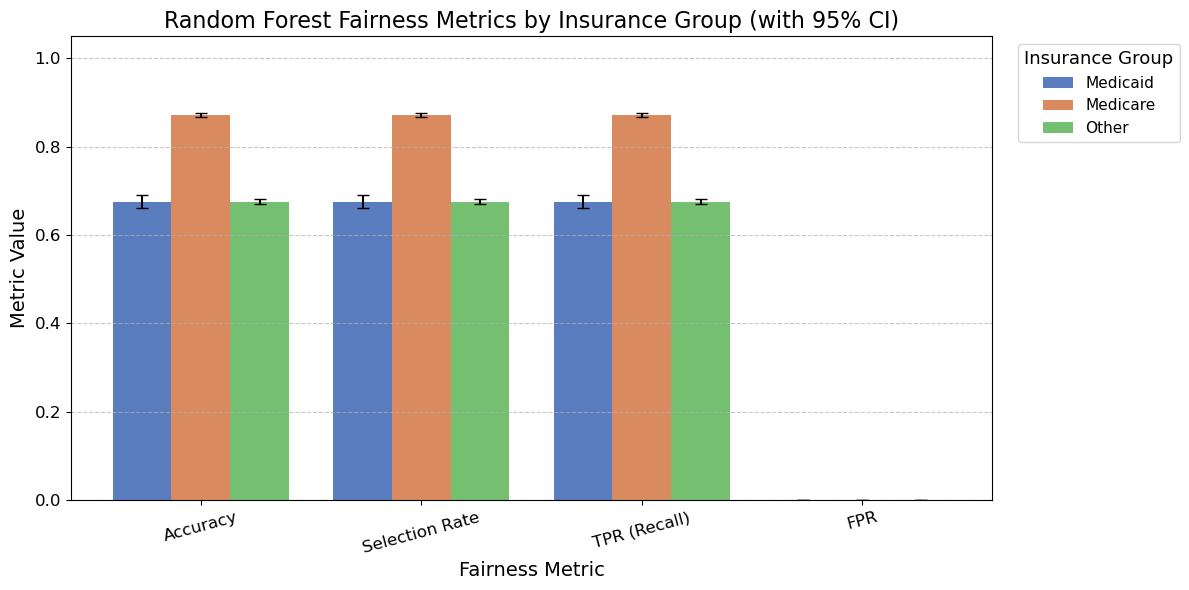

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_insurance_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

metric_list = df_insurance_plot['Metric'].unique()
group_list = df_insurance_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_insurance_plot[df_insurance_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if pd.notna(row['Mean']):
            x_loc = i - 0.4 + group_width/2 + j*group_width
            plt.errorbar(
                x=x_loc,
                y=row['Mean'],
                yerr=[[row['Error Lower']], [row['Error Upper']]],
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1.05)
plt.title('Random Forest Fairness Metrics by Insurance Group (with 95% CI)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.xticks(rotation=15, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend(
    title='Insurance Group',
    title_fontsize=13,
    fontsize=11,
    loc='upper left',
    bbox_to_anchor=(1.02, 1)
)

plt.tight_layout()
plt.show()


In [159]:
acc_gender, acc_ci_gender = bootstrap_metric(accuracy_score, y_test_gender, y_pred_gender)

dpd_gender, dpd_ci_gender = bootstrap_metric(
    demographic_parity_difference,
    y_test_gender, y_pred_gender,
    sensitive_features=gender_grouped
)

eopp_gender, eopp_ci_gender = bootstrap_metric(
    equal_opportunity_difference,
    y_test_gender, y_pred_gender,
    sensitive_features=gender_grouped
)

eod_gender, eod_ci_gender = bootstrap_metric(
    equalized_odds_difference,
    y_test_gender, y_pred_gender,
    sensitive_features=gender_grouped
)


In [160]:
acc_age, acc_ci_age = bootstrap_metric(accuracy_score, y_test_age, y_pred_age)

dpd_age, dpd_ci_age = bootstrap_metric(
    demographic_parity_difference,
    y_test_age, y_pred_age,
    sensitive_features=age_grouped_clean
)

eopp_age, eopp_ci_age = bootstrap_metric(
    equal_opportunity_difference,
    y_test_age, y_pred_age,
    sensitive_features=age_grouped_clean
)

eod_age, eod_ci_age = bootstrap_metric(
    equalized_odds_difference,
    y_test_age, y_pred_age,
    sensitive_features=age_grouped_clean
)


In [161]:
acc_ethnicity, acc_ci_ethnicity = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)

dpd_ethnicity, dpd_ci_ethnicity = bootstrap_metric(
    demographic_parity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)

eopp_ethnicity, eopp_ci_ethnicity = bootstrap_metric(
    equal_opportunity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)

eod_ethnicity, eod_ci_ethnicity = bootstrap_metric(
    equalized_odds_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)


In [162]:
acc_insurance, acc_ci_insurance = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)

dpd_insurance, dpd_ci_insurance = bootstrap_metric(
    demographic_parity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=insurance_grouped
)

eopp_insurance, eopp_ci_insurance = bootstrap_metric(
    equal_opportunity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=insurance_grouped
)

eod_insurance, eod_ci_insurance = bootstrap_metric(
    equalized_odds_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=insurance_grouped
)


In [163]:
import pandas as pd

df_comparison_plot = pd.DataFrame([
    # Gender
    {'Group Type': 'Gender', 'Metric': 'Accuracy', 'Mean': acc_gender, 'Error Lower': acc_gender - acc_ci_gender[0], 'Error Upper': acc_ci_gender[1] - acc_gender},
    {'Group Type': 'Gender', 'Metric': 'Demographic Parity', 'Mean': dpd_gender, 'Error Lower': dpd_gender - dpd_ci_gender[0], 'Error Upper': dpd_ci_gender[1] - dpd_gender},
    {'Group Type': 'Gender', 'Metric': 'Equal Opportunity', 'Mean': eopp_gender, 'Error Lower': eopp_gender - eopp_ci_gender[0], 'Error Upper': eopp_ci_gender[1] - eopp_gender},
    {'Group Type': 'Gender', 'Metric': 'Equalized Odds', 'Mean': eod_gender, 'Error Lower': eod_gender - eod_ci_gender[0], 'Error Upper': eod_ci_gender[1] - eod_gender},
    
    # Age Group
    {'Group Type': 'Age Group', 'Metric': 'Accuracy', 'Mean': acc_age, 'Error Lower': acc_age - acc_ci_age[0], 'Error Upper': acc_ci_age[1] - acc_age},
    {'Group Type': 'Age Group', 'Metric': 'Demographic Parity', 'Mean': dpd_age, 'Error Lower': dpd_age - dpd_ci_age[0], 'Error Upper': dpd_ci_age[1] - dpd_age},
    {'Group Type': 'Age Group', 'Metric': 'Equal Opportunity', 'Mean': eopp_age, 'Error Lower': eopp_age - eopp_ci_age[0], 'Error Upper': eopp_ci_age[1] - eopp_age},
    {'Group Type': 'Age Group', 'Metric': 'Equalized Odds', 'Mean': eod_age, 'Error Lower': eod_age - eod_ci_age[0], 'Error Upper': eod_ci_age[1] - eod_age},

    # Ethnicity
    {'Group Type': 'Ethnicity', 'Metric': 'Accuracy', 'Mean': acc_ethnicity, 'Error Lower': acc_ethnicity - acc_ci_ethnicity[0], 'Error Upper': acc_ci_ethnicity[1] - acc_ethnicity},
    {'Group Type': 'Ethnicity', 'Metric': 'Demographic Parity', 'Mean': dpd_ethnicity, 'Error Lower': dpd_ethnicity - dpd_ci_ethnicity[0], 'Error Upper': dpd_ci_ethnicity[1] - dpd_ethnicity},
    {'Group Type': 'Ethnicity', 'Metric': 'Equal Opportunity', 'Mean': eopp_ethnicity, 'Error Lower': eopp_ethnicity - eopp_ci_ethnicity[0], 'Error Upper': eopp_ci_ethnicity[1] - eopp_ethnicity},
    {'Group Type': 'Ethnicity', 'Metric': 'Equalized Odds', 'Mean': eod_ethnicity, 'Error Lower': eod_ethnicity - eod_ci_ethnicity[0], 'Error Upper': eod_ci_ethnicity[1] - eod_ethnicity},

    # Insurance Group
    {'Group Type': 'Insurance Group', 'Metric': 'Accuracy', 'Mean': acc_insurance, 'Error Lower': acc_insurance - acc_ci_insurance[0], 'Error Upper': acc_ci_insurance[1] - acc_insurance},
    {'Group Type': 'Insurance Group', 'Metric': 'Demographic Parity', 'Mean': dpd_insurance, 'Error Lower': dpd_insurance - dpd_ci_insurance[0], 'Error Upper': dpd_ci_insurance[1] - dpd_insurance},
    {'Group Type': 'Insurance Group', 'Metric': 'Equal Opportunity', 'Mean': eopp_insurance, 'Error Lower': eopp_insurance - eopp_ci_insurance[0], 'Error Upper': eopp_ci_insurance[1] - eopp_insurance},
    {'Group Type': 'Insurance Group', 'Metric': 'Equalized Odds', 'Mean': eod_insurance, 'Error Lower': eod_insurance - eod_ci_insurance[0], 'Error Upper': eod_ci_insurance[1] - eod_insurance}
])


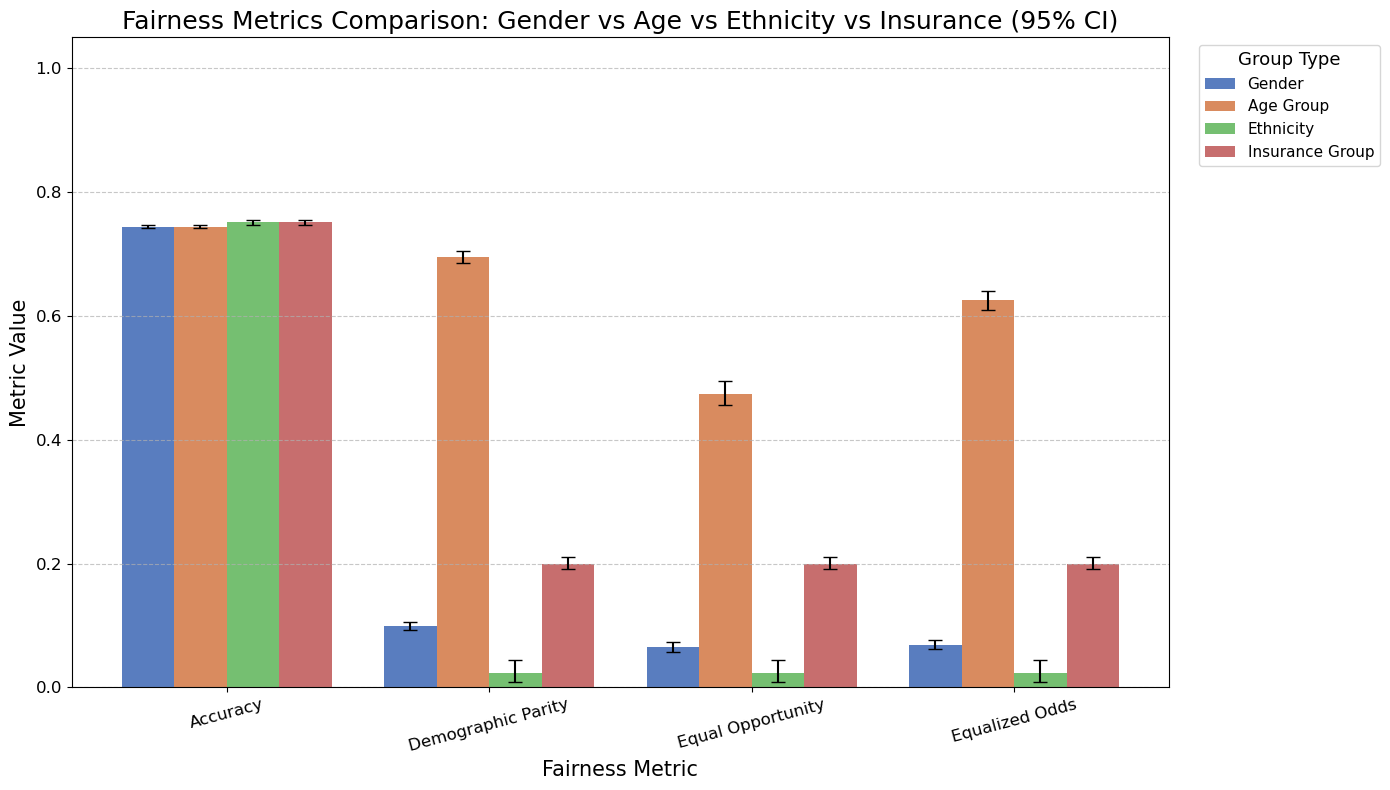

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(14, 8))

# Create grouped barplot
sns.barplot(
    data=df_comparison_plot,
    x='Metric',
    y='Mean',
    hue='Group Type',
    palette='muted',
    errorbar=None,
    capsize=0.2
)

# === Add manual error bars ===
metric_list = df_comparison_plot['Metric'].unique()
group_list = df_comparison_plot['Group Type'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_comparison_plot[df_comparison_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        x_loc = i - 0.4 + group_width/2 + j*group_width
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=x_loc,
                y=row['Mean'],
                yerr=[[row['Error Lower']], [row['Error Upper']]],
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=5
            )

# === Style the plot ===
plt.ylim(0, 1.05)
plt.title('Fairness Metrics Comparison: Gender vs Age vs Ethnicity vs Insurance (95% CI)', fontsize=18)
plt.xlabel('Fairness Metric', fontsize=15)
plt.ylabel('Metric Value', fontsize=15)
plt.xticks(rotation=15, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend(
    title='Group Type',
    title_fontsize=13,
    fontsize=11,
    loc='upper left',
    bbox_to_anchor=(1.02, 1)
)

plt.tight_layout()
plt.show()


GradientBoosting:
Training time: 70.89845895767212 seconds
AUC: 0.8201988297540278
AUPRC: 0.7957168248989451
Sensitivity: 0.738986218173324
Specificity: 0.7435837362356499
Score thresold: 0.49401972301340774
2.5 97.5


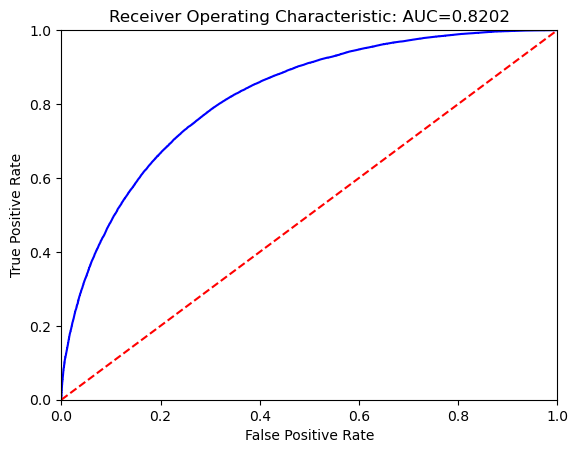

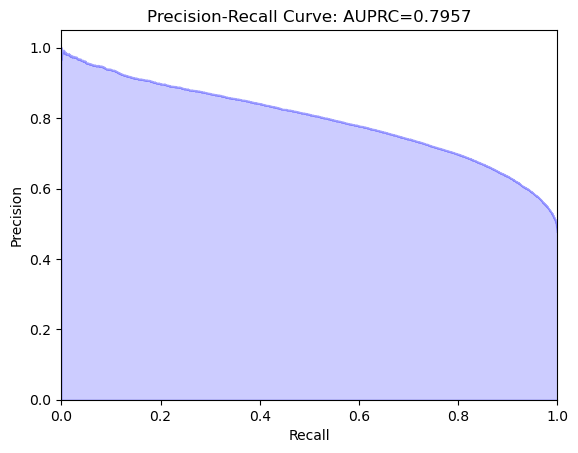

In [11]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [12]:
import numpy as np

def bootstrap_metric(metric_func, y_true, y_pred, sensitive_features=None, n_boot=1000, alpha=0.05, random_seed=42):
    np.random.seed(random_seed)
    boot_vals = []

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    if sensitive_features is not None:
        sensitive_features = np.array(sensitive_features)

    n = len(y_true)
    
    for _ in range(n_boot):
        idx = np.random.choice(n, size=n, replace=True)
        y_true_boot = y_true[idx]
        y_pred_boot = y_pred[idx]
        if sensitive_features is not None:
            sensitive_boot = sensitive_features[idx]
            val = metric_func(y_true_boot, y_pred_boot, sensitive_features=sensitive_boot)
        else:
            val = metric_func(y_true_boot, y_pred_boot)
        boot_vals.append(val)

    mean_val = np.mean(boot_vals)
    lower = np.percentile(boot_vals, 100 * (alpha / 2))
    upper = np.percentile(boot_vals, 100 * (1 - alpha / 2))
    
    return mean_val, (lower, upper)


In [13]:
probs = gb.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.5).astype(int)  # Threshold at 0.5


gender_raw = df_test['gender']

valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
gender_clean = gender_raw[valid_mask]


gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})


from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score


acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_gender, y_pred_gender)
dpd_mean, dpd_ci = bootstrap_metric(demographic_parity_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)
eopp_mean, eopp_ci = bootstrap_metric(equal_opportunity_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)
eod_mean, eod_ci = bootstrap_metric(equalized_odds_difference, y_test_gender, y_pred_gender, sensitive_features=gender_grouped)


print("\n=== Gradient Boosting - Fairness Metrics by Gender (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")




=== Gradient Boosting - Fairness Metrics by Gender (Mean + 95% CI) ===
Accuracy:              Mean = 0.741, CI = (0.738, 0.744)
Demographic Parity:    Mean = 0.103, CI = (0.096, 0.110)
Equal Opportunity:     Mean = 0.065, CI = (0.056, 0.074)
Equalized Odds:        Mean = 0.075, CI = (0.068, 0.083)


In [14]:
from sklearn.metrics import recall_score, confusion_matrix
from fairlearn.metrics import selection_rate


def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) != 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    values = []

    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_lower, ci_upper)

female_mask = (gender_grouped == 0).values
male_mask = (gender_grouped == 1).values

metrics = {}

for label, mask in zip(['Female', 'Male'], [female_mask, male_mask]):
    metrics[label] = {
        'Accuracy': bootstrap_metric_per_group(accuracy_score, y_test_gender, y_pred_gender, mask),
        'Selection Rate': bootstrap_metric_per_group(selection_rate, y_test_gender, y_pred_gender, mask),
        'TPR (Recall)': bootstrap_metric_per_group(recall_score, y_test_gender, y_pred_gender, mask),
        'FPR': bootstrap_metric_per_group(false_positive_rate, y_test_gender, y_pred_gender, mask)
    }

print("\n=== Gradient Boosting Per-Gender Metrics (Mean + 95% CI) ===")
for group, metric_dict in metrics.items():
    print(f"\n{group}:")
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        print(f"{metric_name:<16} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Gradient Boosting Per-Gender Metrics (Mean + 95% CI) ===

Female:
Accuracy         Mean = 0.745, CI = (0.741, 0.749)
Selection Rate   Mean = 0.432, CI = (0.428, 0.437)
TPR (Recall)     Mean = 0.699, CI = (0.693, 0.705)
FPR              Mean = 0.218, CI = (0.213, 0.223)

Male:
Accuracy         Mean = 0.736, CI = (0.732, 0.740)
Selection Rate   Mean = 0.536, CI = (0.530, 0.541)
TPR (Recall)     Mean = 0.764, CI = (0.759, 0.770)
FPR              Mean = 0.293, CI = (0.287, 0.300)


In [17]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)
eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)
eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)

print("\n=== Gradient Boosting - Fairness Metrics by Ethnicity (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== Gradient Boosting - Fairness Metrics by Ethnicity (Mean + 95% CI) ===
Accuracy:              Mean = 0.688, CI = (0.684, 0.692)
Demographic Parity:    Mean = 0.208, CI = (0.194, 0.224)
Equal Opportunity:     Mean = 0.120, CI = (0.102, 0.140)
Equalized Odds:        Mean = 0.203, CI = (0.179, 0.231)


In [19]:
from sklearn.metrics import recall_score, confusion_matrix
from fairlearn.metrics import selection_rate

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    values = []
    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_low = np.percentile(values, 100 * (alpha / 2))
    ci_high = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_low, ci_high)

ethnicity_raw = df_test['ethnicity']

valid_mask = ethnicity_raw.notna() & (ethnicity_raw != '') & (ethnicity_raw.str.lower() != 'unknown')

ethnicity_clean = ethnicity_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

ethnicity_grouped = ethnicity_clean.str.lower().map({
    'white': 'White',
    'asian': 'Asian',
    'black/african american': 'Black or African American',
    'hispanic/latino': 'Hispanic or Latino'
}).fillna('Other')


ethnicity_metrics = []  


for group in ethnicity_grouped.unique():
    mask = (ethnicity_grouped == group).values

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_clean, y_pred_clean, mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_clean, y_pred_clean, mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_clean, y_pred_clean, mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_clean, y_pred_clean, mask)

    ethnicity_metrics.append({
        'Ethnicity': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })


print("\n=== Gradient Boosting - Metrics by Ethnicity Group (Mean + 95% CI) ===")
for row in ethnicity_metrics:
    print(f"\nEthnicity: {row['Ethnicity']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Gradient Boosting - Metrics by Ethnicity Group (Mean + 95% CI) ===

Ethnicity: White
Accuracy          Mean = 0.699, CI = (0.695, 0.704)
Selection Rate    Mean = 0.698, CI = (0.693, 0.702)
TPR (Recall)      Mean = 0.757, CI = (0.752, 0.762)
FPR               Mean = 0.496, CI = (0.486, 0.507)

Ethnicity: Black or African American
Accuracy          Mean = 0.675, CI = (0.667, 0.683)
Selection Rate    Mean = 0.553, CI = (0.544, 0.561)
TPR (Recall)      Mean = 0.686, CI = (0.675, 0.696)
FPR               Mean = 0.342, CI = (0.329, 0.354)

Ethnicity: Asian
Accuracy          Mean = 0.645, CI = (0.622, 0.666)
Selection Rate    Mean = 0.614, CI = (0.592, 0.637)
TPR (Recall)      Mean = 0.664, CI = (0.639, 0.689)
FPR               Mean = 0.428, CI = (0.380, 0.473)

Ethnicity: Hispanic or Latino
Accuracy          Mean = 0.664, CI = (0.651, 0.678)
Selection Rate    Mean = 0.489, CI = (0.474, 0.504)
TPR (Recall)      Mean = 0.637, CI = (0.618, 0.655)
FPR               Mean = 0.300, CI = (0.281

In [20]:
age_bins = [0, 17, 24, 34, 44, 54, 64, 74, float('inf')]
age_labels = ['0‚Äì17', '18‚Äì24', '25‚Äì34', '35‚Äì44', '45‚Äì54', '55‚Äì64', '65‚Äì74', '75+']

age_grouped = pd.cut(X_test['age'], bins=age_bins, labels=age_labels)

valid_mask = age_grouped.notna()

y_test_age = y_test[valid_mask]
y_pred_age = y_pred[valid_mask]  
age_grouped_clean = age_grouped[valid_mask]


from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score


acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_age, y_pred_age)

dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_age, y_pred_age,
    sensitive_features=age_grouped_clean
)

eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_age, y_pred_age,
    sensitive_features=age_grouped_clean
)

eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_age, y_pred_age,
    sensitive_features=age_grouped_clean
)


print("\n=== Gradient Boosting - Fairness Metrics by Age Group (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== Gradient Boosting - Fairness Metrics by Age Group (Mean + 95% CI) ===
Accuracy:              Mean = 0.741, CI = (0.738, 0.744)
Demographic Parity:    Mean = 0.743, CI = (0.735, 0.751)
Equal Opportunity:     Mean = 0.588, CI = (0.569, 0.609)
Equalized Odds:        Mean = 0.655, CI = (0.641, 0.669)


In [21]:
age_bins = [0, 17, 24, 34, 44, 54, 64, 74, float('inf')]
age_labels = ['0‚Äì17', '18‚Äì24', '25‚Äì34', '35‚Äì44', '45‚Äì54', '55‚Äì64', '65‚Äì74', '75+']
age_grouped = pd.cut(X_test['age'], bins=age_bins, labels=age_labels, right=True)

valid_mask = age_grouped.notna()
y_test_age = y_test[valid_mask]
y_pred_age = y_pred[valid_mask]  
age_grouped_clean = age_grouped[valid_mask]

from sklearn.metrics import recall_score, confusion_matrix
from fairlearn.metrics import selection_rate

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = np.array(mask)

    if mask.sum() == 0:
        return np.nan, (np.nan, np.nan)

    metrics = []
    for _ in range(n_boot):
        idx = np.random.choice(np.where(mask)[0], size=np.sum(mask), replace=True)
        metrics.append(metric_func(y_true[idx], y_pred[idx]))

    lower = np.percentile(metrics, 100 * (alpha / 2))
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    mean_val = np.mean(metrics)

    return mean_val, (lower, upper)


group_metrics = []

for group in age_labels:
    mask = (age_grouped_clean == group).values

    if mask.sum() == 0:
        group_metrics.append({
            'Age Group': group,
            'Accuracy': (np.nan, (np.nan, np.nan)),
            'Selection Rate': (np.nan, (np.nan, np.nan)),
            'TPR (Recall)': (np.nan, (np.nan, np.nan)),
            'FPR': (np.nan, (np.nan, np.nan))
        })
        continue

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_age, y_pred_age, mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_age, y_pred_age, mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_age, y_pred_age, mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_age, y_pred_age, mask)

    group_metrics.append({
        'Age Group': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== Gradient Boosting Bootstrapped Metrics by Age Group (Mean and 95% CI) ===")
for row in group_metrics:
    print(f"\nAge Group: {row['Age Group']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        if pd.isna(mean):
            print(f"{metric_name:<17} No data available")
        else:
            print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Gradient Boosting Bootstrapped Metrics by Age Group (Mean and 95% CI) ===

Age Group: 0‚Äì17
Accuracy          No data available
Selection Rate    No data available
TPR (Recall)      No data available
FPR               No data available

Age Group: 18‚Äì24
Accuracy          Mean = 0.802, CI = (0.793, 0.810)
Selection Rate    Mean = 0.124, CI = (0.118, 0.130)
TPR (Recall)      Mean = 0.338, CI = (0.319, 0.359)
FPR               Mean = 0.060, CI = (0.054, 0.065)

Age Group: 25‚Äì34
Accuracy          Mean = 0.775, CI = (0.768, 0.782)
Selection Rate    Mean = 0.175, CI = (0.169, 0.182)
TPR (Recall)      Mean = 0.410, CI = (0.395, 0.425)
FPR               Mean = 0.085, CI = (0.079, 0.090)

Age Group: 35‚Äì44
Accuracy          Mean = 0.744, CI = (0.735, 0.752)
Selection Rate    Mean = 0.290, CI = (0.282, 0.299)
TPR (Recall)      Mean = 0.548, CI = (0.532, 0.563)
FPR               Mean = 0.147, CI = (0.139, 0.155)

Age Group: 45‚Äì54
Accuracy          Mean = 0.715, CI = (0.707, 0.723)
Se

In [22]:
insurance_raw = df_test['insurance']

valid_mask = (
    insurance_raw.notna() &
    (insurance_raw != '') &
    (insurance_raw.str.lower() != 'unknown')
)

insurance_clean = insurance_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]   


insurance_grouped = insurance_clean.str.lower().map({
    'medicaid': 'Medicaid',
    'medicare': 'Medicare'
}).fillna('Other')


from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score


acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=insurance_grouped
)
eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=insurance_grouped
)
eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=insurance_grouped
)


print("\n=== Gradient Boosting - Bootstrapped Fairness & Accuracy Metrics by Insurance ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== Gradient Boosting - Bootstrapped Fairness & Accuracy Metrics by Insurance ===
Accuracy:              Mean = 0.732, CI = (0.728, 0.736)
Demographic Parity:    Mean = 0.219, CI = (0.210, 0.230)
Equal Opportunity:     Mean = 0.219, CI = (0.210, 0.230)
Equalized Odds:        Mean = 0.219, CI = (0.210, 0.230)


In [23]:

insurance_raw = df_test['insurance']

valid_mask = (
    insurance_raw.notna() &
    (insurance_raw != '') &
    (insurance_raw.str.lower() != 'unknown')
)

insurance_clean = insurance_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]  # <- Make sure y_pred comes from Gradient Boosting model!

insurance_grouped = insurance_clean.str.lower().map({
    'medicaid': 'Medicaid',
    'medicare': 'Medicare'
}).fillna('Other')


from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from fairlearn.metrics import selection_rate


def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = np.array(mask)

    if mask.sum() == 0:
        return np.nan, (np.nan, np.nan)

    metrics = []
    for _ in range(n_boot):
        idx = np.random.choice(np.where(mask)[0], size=np.sum(mask), replace=True)
        metrics.append(metric_func(y_true[idx], y_pred[idx]))

    lower = np.percentile(metrics, 100 * (alpha / 2))
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    mean_val = np.mean(metrics)

    return mean_val, (lower, upper)


insurance_metrics = []

for group in insurance_grouped.unique():
    mask = (insurance_grouped == group).values

    if mask.sum() == 0:
        insurance_metrics.append({
            'Insurance Group': group,
            'Accuracy': (np.nan, (np.nan, np.nan)),
            'Selection Rate': (np.nan, (np.nan, np.nan)),
            'TPR (Recall)': (np.nan, (np.nan, np.nan)),
            'FPR': (np.nan, (np.nan, np.nan))
        })
        continue

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_clean, y_pred_clean, mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_clean, y_pred_clean, mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_clean, y_pred_clean, mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_clean, y_pred_clean, mask)

    insurance_metrics.append({
        'Insurance Group': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })


print("\n=== Gradient Boosting - Bootstrapped Metrics by Insurance Group (Mean and 95% CI) ===")
for row in insurance_metrics:
    print(f"\nInsurance Group: {row['Insurance Group']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        if pd.isna(mean):
            print(f"{metric_name:<17} No data available")
        else:
            print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== Gradient Boosting - Bootstrapped Metrics by Insurance Group (Mean and 95% CI) ===

Insurance Group: Medicaid
Accuracy          Mean = 0.650, CI = (0.636, 0.664)
Selection Rate    Mean = 0.650, CI = (0.636, 0.664)
TPR (Recall)      Mean = 0.650, CI = (0.636, 0.664)
FPR               Mean = 0.000, CI = (0.000, 0.000)

Insurance Group: Medicare
Accuracy          Mean = 0.864, CI = (0.859, 0.870)
Selection Rate    Mean = 0.864, CI = (0.859, 0.870)
TPR (Recall)      Mean = 0.864, CI = (0.859, 0.870)
FPR               Mean = 0.000, CI = (0.000, 0.000)

Insurance Group: Other
Accuracy          Mean = 0.648, CI = (0.642, 0.654)
Selection Rate    Mean = 0.648, CI = (0.642, 0.654)
TPR (Recall)      Mean = 0.648, CI = (0.642, 0.654)
FPR               Mean = 0.000, CI = (0.000, 0.000)


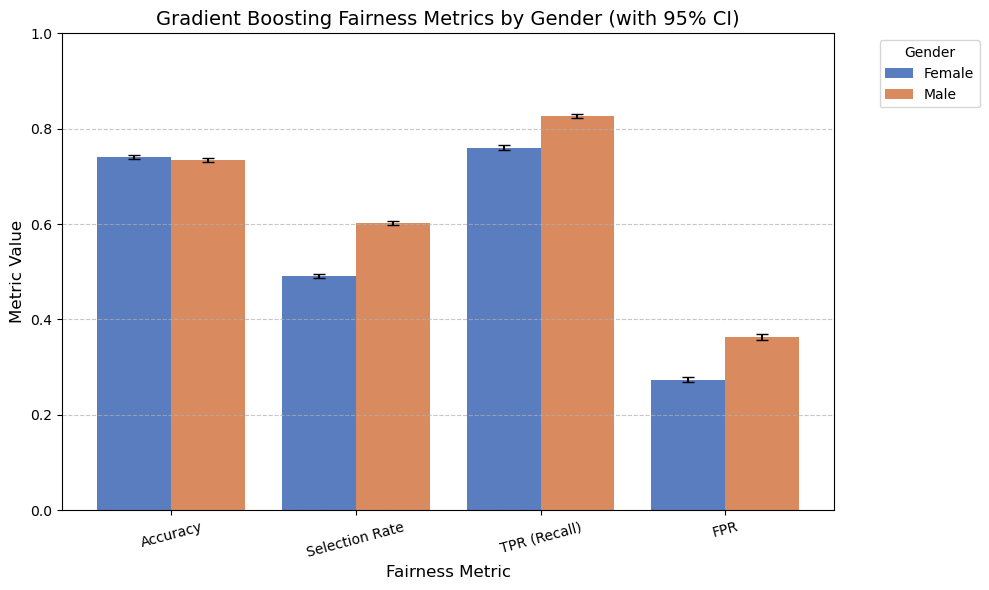

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_gb_gender_plot = []

for group, metric_dict in metrics.items():
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        df_gb_gender_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low,
            'Error Upper': ci_high - mean
        })

df_gb_gender_plot = pd.DataFrame(df_gb_gender_plot)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=df_gb_gender_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None, 
    capsize=0.2
)


metric_list = df_gb_gender_plot['Metric'].unique()
group_list = df_gb_gender_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_gb_gender_plot[df_gb_gender_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        plt.errorbar(
            x=i - 0.4 + group_width/2 + j*group_width,
            y=row['Mean'],
            yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
            fmt='none',
            ecolor='black',
            elinewidth=1.5,
            capsize=4
        )

plt.ylim(0, 1)
plt.title('Gradient Boosting Fairness Metrics by Gender (with 95% CI)', fontsize=14)
plt.xlabel('Fairness Metric', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


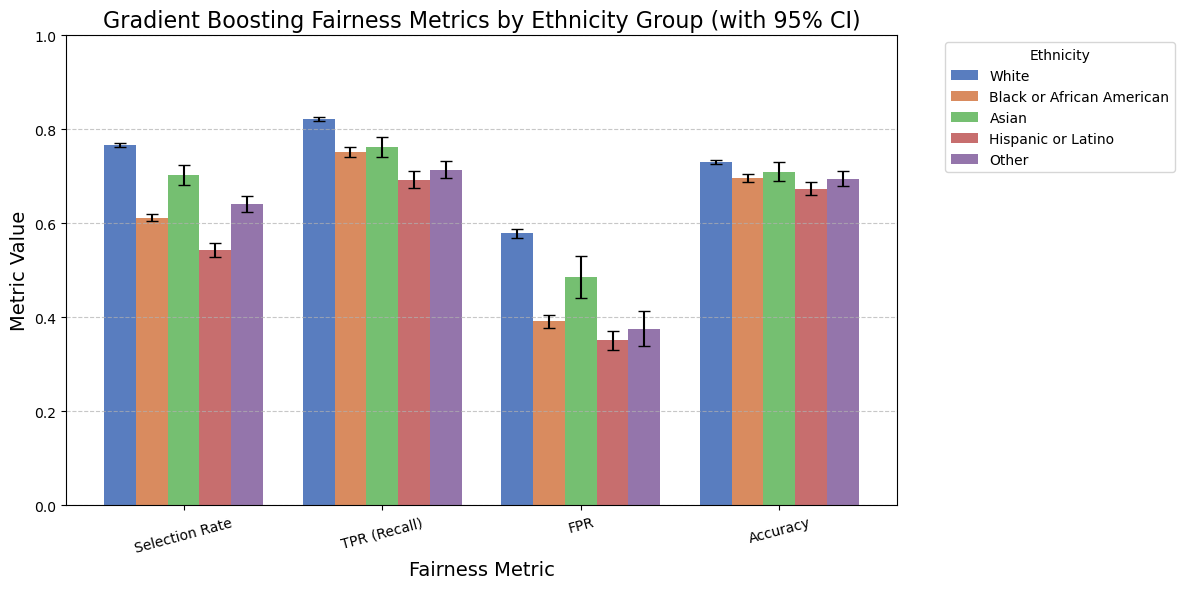

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

ethnicity_plot_data = []

for row in ethnicity_metrics:
    group = row['Ethnicity']
    for metric_name in ['Selection Rate', 'TPR (Recall)', 'FPR', 'Accuracy']:
        mean, (ci_low, ci_high) = row[metric_name]
        ethnicity_plot_data.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low,
            'Error Upper': ci_high - mean
        })

df_ethnicity_plot = pd.DataFrame(ethnicity_plot_data)

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_ethnicity_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,  
    capsize=0.2
)

metric_list = df_ethnicity_plot['Metric'].unique()
group_list = df_ethnicity_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_ethnicity_plot[df_ethnicity_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        plt.errorbar(
            x=i - 0.4 + group_width/2 + j*group_width,
            y=row['Mean'],
            yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
            fmt='none',
            ecolor='black',
            elinewidth=1.5,
            capsize=4
        )

plt.ylim(0, 1)
plt.title('Gradient Boosting Fairness Metrics by Ethnicity Group (with 95% CI)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


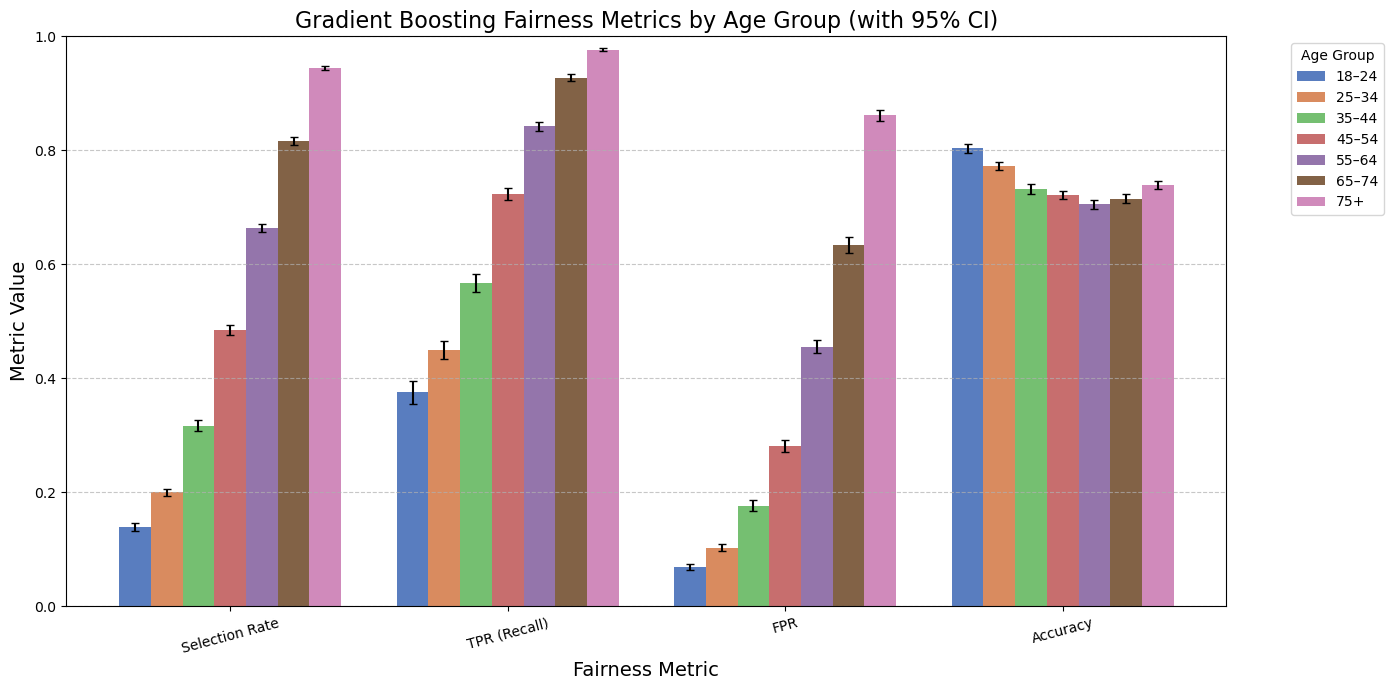

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

age_plot_data = []

for row in group_metrics:
    group = row['Age Group']
    for metric_name in ['Selection Rate', 'TPR (Recall)', 'FPR', 'Accuracy']:
        mean, (ci_low, ci_high) = row[metric_name]
        if not pd.isna(mean):   # ‚úÖ Only include groups that have data
            age_plot_data.append({
                'Group': group,
                'Metric': metric_name,
                'Mean': mean,
                'Error Lower': mean - ci_low,
                'Error Upper': ci_high - mean
            })

df_age_plot = pd.DataFrame(age_plot_data)

plt.figure(figsize=(14, 7))

sns.barplot(
    data=df_age_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,   
    capsize=0.2
)


metric_list = df_age_plot['Metric'].unique()
group_list = df_age_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups  

for i, metric in enumerate(metric_list):
    subset = df_age_plot[df_age_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        plt.errorbar(
            x=i - 0.4 + group_width/2 + j*group_width,
            y=row['Mean'],
            yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
            fmt='none',
            ecolor='black',
            elinewidth=1.5,
            capsize=3
        )


plt.ylim(0, 1)
plt.title('Gradient Boosting Fairness Metrics by Age Group (with 95% CI)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


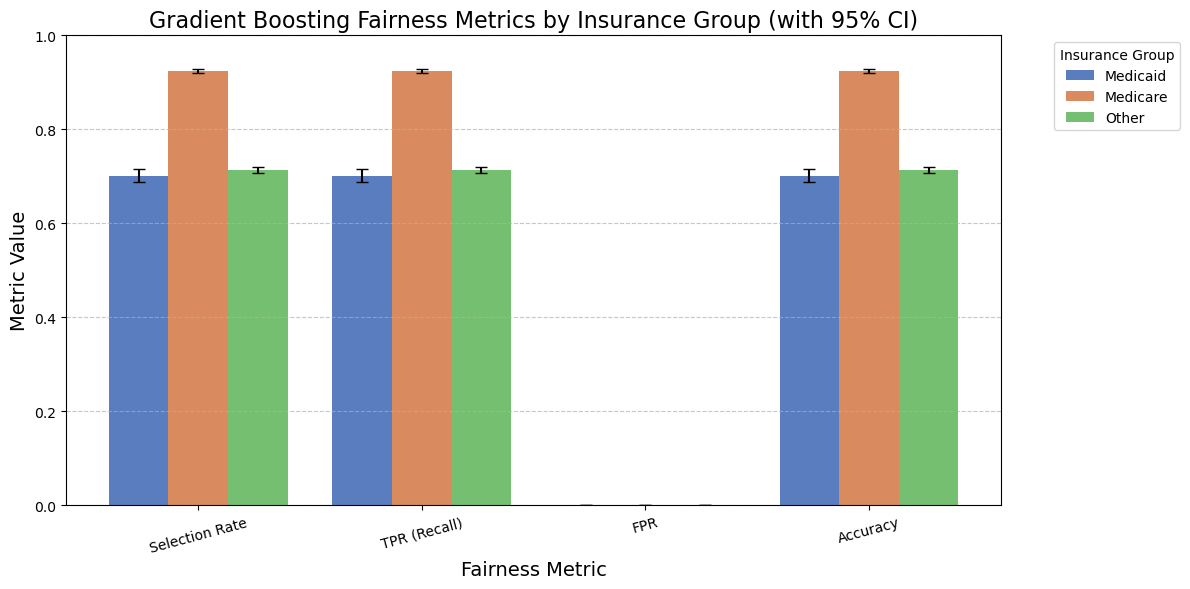

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

insurance_plot_data = []

for row in insurance_metrics:
    group = row['Insurance Group']
    for metric_name in ['Selection Rate', 'TPR (Recall)', 'FPR', 'Accuracy']:
        mean, (ci_low, ci_high) = row[metric_name]
        if not pd.isna(mean):
            insurance_plot_data.append({
                'Group': group,
                'Metric': metric_name,
                'Mean': mean,
                'Error Lower': mean - ci_low,
                'Error Upper': ci_high - mean
            })

df_insurance_plot = pd.DataFrame(insurance_plot_data)

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_insurance_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,  
    capsize=0.2
)

metric_list = df_insurance_plot['Metric'].unique()
group_list = df_insurance_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_insurance_plot[df_insurance_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        plt.errorbar(
            x=i - 0.4 + group_width/2 + j*group_width,
            y=row['Mean'],
            yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
            fmt='none',
            ecolor='black',
            elinewidth=1.5,
            capsize=4
        )

plt.ylim(0, 1)
plt.title('Gradient Boosting Fairness Metrics by Insurance Group (with 95% CI)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Insurance Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
class MLP(Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

    def get_config(self):
        return super().get_config()

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [125]:
# class MLP(tf.keras.Model):
#     def __init__(self):
#         super(MLP, self).__init__()
#         self.dense_1 = Dense(128, activation='relu')
#         self.dense_2 = Dense(64, activation='relu')
#         self.classifier = Dense(1, activation='sigmoid')

#     def call(self, x):
#         x = self.dense_1(x)
#         x = self.dense_2(x)
#         return self.classifier(x)

In [25]:
from tensorflow.keras import metrics

mlp = MLP()  
mlp.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=[
        metrics.BinaryAccuracy(name='accuracy'),
        metrics.AUC(name='auc'),
        metrics.AUC(name='auprc', curve='PR'),
        metrics.TruePositives(name='tp'),
        metrics.TrueNegatives(name='tn'),
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall')
    ]
)



2025-04-28 15:45:10.601079: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [26]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Unique y_train values:", np.unique(y_train))


X_train shape: (359043, 64)
y_train shape: (359043,)
Unique y_train values: [False  True]


In [27]:
# skip this cell if not retraining
# mlp = MLP()
# mlp.compile(loss='binary_crossentropy', 
#               optimizer=optimizers.Adam(learning_rate=0.001), 
#               metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
#                        'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('hospitalization_triage_mlp.keras')

Epoch 1/20
1796/1796 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 1ms/step - accuracy: 0.6818 - auc: 0.7372 - auprc: 0.7016 - loss: 0.6388 - precision: 0.6790 - recall: 0.6318 - tn: 69325.1875 - tp: 55690.4023
Epoch 2/20
1796/1796 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 1ms/step - accuracy: 0.7209 - auc: 0.7955 - auprc: 0.7688 - loss: 0.5493 - precision: 0.7167 - recall: 0.6891 - tn: 70316.7578 - tp: 59322.3906
Epoch 3/20
1796/1796 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 1ms/step - accuracy: 0.7214 - auc: 0.7959 - auprc: 0.7696 - loss: 0.5485 - precision: 0.7151 - recall: 0.6930 - tn: 70329.9453 - tp: 59658.7539
Epoch 4/20
1796/1796 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 1ms/step - accuracy: 0.7264 - auc: 0.8026 - auprc: 0.7769 - loss: 0.5396 - precision: 0.7184 - recall: 0.7036 - tn: 70132.7422 - tp: 60591.5547
Epoch 5/20
1796/1796 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s

MLP:
2806/2806 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 506us/step
AUC: 0.8195387219040843
AUPRC: 0.7949954224092695
Sensitivity: 0.7479560850268628
Specificity: 0.7321036825626717
Score thresold: 0.5416499
2.5 97.5


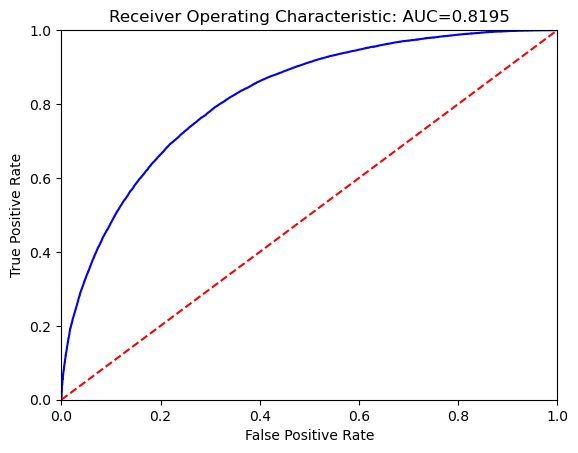

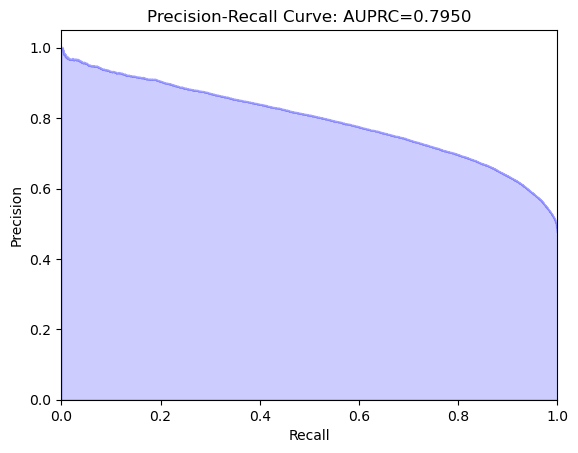

In [28]:
print("MLP:")
mlp = load_model('hospitalization_triage_mlp.keras')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [29]:
import numpy as np

def bootstrap_metric(metric_func, y_true, y_pred, sensitive_features=None, n_bootstrap=1000, random_seed=0):
    rng = np.random.default_rng(random_seed)
    stats = []
    n = len(y_true)
    
    for _ in range(n_bootstrap):
        idx = rng.choice(n, size=n, replace=True)
        y_true_sample = y_true.iloc[idx] if hasattr(y_true, 'iloc') else y_true[idx]
        y_pred_sample = y_pred.iloc[idx] if hasattr(y_pred, 'iloc') else y_pred[idx]
        
        if sensitive_features is not None:
            sensitive_sample = sensitive_features.iloc[idx] if hasattr(sensitive_features, 'iloc') else sensitive_features[idx]
            stat = metric_func(y_true_sample, y_pred_sample, sensitive_features=sensitive_sample)
        else:
            stat = metric_func(y_true_sample, y_pred_sample)
        
        stats.append(stat)
    
    stats = np.array(stats)
    mean_stat = np.mean(stats)
    lower_bound = np.percentile(stats, 2.5)
    upper_bound = np.percentile(stats, 97.5)
    
    return mean_stat, (lower_bound, upper_bound)


In [30]:
probs = mlp.predict(X_test.astype(np.float32)) 
y_pred = (probs[:, 0] >= 0.5).astype(int)  


2806/2806 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 499us/step


In [31]:
gender_raw = df_test['gender']

valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
gender_clean = gender_raw[valid_mask]

gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})


from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_gender, y_pred_gender)
dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_gender, y_pred_gender,
    sensitive_features=gender_grouped
)
eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_gender, y_pred_gender,
    sensitive_features=gender_grouped
)
eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_gender, y_pred_gender,
    sensitive_features=gender_grouped
)

print("\n=== MLP - Fairness Metrics by Gender (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== MLP - Fairness Metrics by Gender (Mean + 95% CI) ===
Accuracy:              Mean = 0.738, CI = (0.736, 0.741)
Demographic Parity:    Mean = 0.111, CI = (0.104, 0.118)
Equal Opportunity:     Mean = 0.067, CI = (0.059, 0.074)
Equalized Odds:        Mean = 0.090, CI = (0.081, 0.098)


In [32]:
from sklearn.metrics import recall_score, confusion_matrix
from fairlearn.metrics import selection_rate

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) != 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    values = []

    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_lower, ci_upper)


gender_raw = df_test['gender']

valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
gender_clean = gender_raw[valid_mask]

gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

female_mask = (gender_grouped == 0).values
male_mask = (gender_grouped == 1).values

metrics = {}

for label, mask in zip(['Female', 'Male'], [female_mask, male_mask]):
    metrics[label] = {
        'Accuracy': bootstrap_metric_per_group(accuracy_score, y_test_gender, y_pred_gender, mask),
        'Selection Rate': bootstrap_metric_per_group(selection_rate, y_test_gender, y_pred_gender, mask),
        'TPR (Recall)': bootstrap_metric_per_group(recall_score, y_test_gender, y_pred_gender, mask),
        'FPR': bootstrap_metric_per_group(false_positive_rate, y_test_gender, y_pred_gender, mask)
    }

print("\n=== MLP Per-Gender Metrics (Mean + 95% CI) ===")
for group, metric_dict in metrics.items():
    print(f"\n{group}:")
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        print(f"{metric_name:<16} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== MLP Per-Gender Metrics (Mean + 95% CI) ===

Female:
Accuracy         Mean = 0.741, CI = (0.737, 0.745)
Selection Rate   Mean = 0.490, CI = (0.486, 0.495)
TPR (Recall)     Mean = 0.760, CI = (0.755, 0.766)
FPR              Mean = 0.274, CI = (0.268, 0.279)

Male:
Accuracy         Mean = 0.734, CI = (0.730, 0.739)
Selection Rate   Mean = 0.602, CI = (0.597, 0.607)
TPR (Recall)     Mean = 0.827, CI = (0.822, 0.832)
FPR              Mean = 0.363, CI = (0.357, 0.370)


In [33]:
ethnicity_raw = df_test['ethnicity']

valid_mask = (
    ethnicity_raw.notna() &
    (ethnicity_raw != '') &
    (ethnicity_raw.str.lower() != 'unknown')
)

ethnicity_clean = ethnicity_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

ethnicity_grouped = ethnicity_clean.str.lower().map({
    'white': 'White',
    'asian': 'Asian',
    'black/african american': 'Black or African American',
    'hispanic/latino': 'Hispanic or Latino'
}).fillna('Other')

from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)
dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)
eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)
eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)

print("\n=== MLP - Fairness Metrics by Ethnicity (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== MLP - Fairness Metrics by Ethnicity (Mean + 95% CI) ===
Accuracy:              Mean = 0.716, CI = (0.712, 0.720)
Demographic Parity:    Mean = 0.223, CI = (0.208, 0.237)
Equal Opportunity:     Mean = 0.129, CI = (0.112, 0.146)
Equalized Odds:        Mean = 0.229, CI = (0.208, 0.251)


In [34]:
from sklearn.metrics import recall_score, confusion_matrix
from fairlearn.metrics import selection_rate

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    values = []
    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_low = np.percentile(values, 100 * (alpha / 2))
    ci_high = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_low, ci_high)

ethnicity_raw = df_test['ethnicity']

valid_mask = ethnicity_raw.notna() & (ethnicity_raw != '') & (ethnicity_raw.str.lower() != 'unknown')

ethnicity_clean = ethnicity_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

ethnicity_grouped = ethnicity_clean.str.lower().map({
    'white': 'White',
    'asian': 'Asian',
    'black/african american': 'Black or African American',
    'hispanic/latino': 'Hispanic or Latino'
}).fillna('Other')

ethnicity_metrics = []

for group in ethnicity_grouped.unique():
    mask = (ethnicity_grouped == group).values

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_clean, y_pred_clean, mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_clean, y_pred_clean, mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_clean, y_pred_clean, mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_clean, y_pred_clean, mask)

    ethnicity_metrics.append({
        'Ethnicity': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== MLP - Metrics by Ethnicity Group (Mean + 95% CI) ===")  
for row in ethnicity_metrics:
    print(f"\nEthnicity: {row['Ethnicity']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== MLP - Metrics by Ethnicity Group (Mean + 95% CI) ===

Ethnicity: White
Accuracy          Mean = 0.730, CI = (0.726, 0.735)
Selection Rate    Mean = 0.766, CI = (0.762, 0.771)
TPR (Recall)      Mean = 0.822, CI = (0.818, 0.826)
FPR               Mean = 0.578, CI = (0.568, 0.589)

Ethnicity: Black or African American
Accuracy          Mean = 0.696, CI = (0.689, 0.704)
Selection Rate    Mean = 0.612, CI = (0.604, 0.620)
TPR (Recall)      Mean = 0.752, CI = (0.742, 0.761)
FPR               Mean = 0.391, CI = (0.378, 0.404)

Ethnicity: Asian
Accuracy          Mean = 0.710, CI = (0.690, 0.731)
Selection Rate    Mean = 0.704, CI = (0.682, 0.723)
TPR (Recall)      Mean = 0.762, CI = (0.740, 0.785)
FPR               Mean = 0.485, CI = (0.440, 0.530)

Ethnicity: Hispanic or Latino
Accuracy          Mean = 0.673, CI = (0.660, 0.687)
Selection Rate    Mean = 0.543, CI = (0.529, 0.557)
TPR (Recall)      Mean = 0.693, CI = (0.676, 0.711)
FPR               Mean = 0.351, CI = (0.330, 0.371)

Ethn

In [35]:
age_bins = [0, 17, 24, 34, 44, 54, 64, 74, float('inf')]
age_labels = ['0‚Äì17', '18‚Äì24', '25‚Äì34', '35‚Äì44', '45‚Äì54', '55‚Äì64', '65‚Äì74', '75+']

age_grouped = pd.cut(X_test['age'], bins=age_bins, labels=age_labels)

valid_mask = age_grouped.notna()

y_test_age = y_test[valid_mask]
y_pred_age = y_pred[valid_mask]  # <- make sure y_pred is from MLP now
age_grouped_clean = age_grouped[valid_mask]


from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score


acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_age, y_pred_age)

dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_age, y_pred_age,
    sensitive_features=age_grouped_clean
)

eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_age, y_pred_age,
    sensitive_features=age_grouped_clean
)

eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_age, y_pred_age,
    sensitive_features=age_grouped_clean
)

print("\n=== MLP - Fairness Metrics by Age Group (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== MLP - Fairness Metrics by Age Group (Mean + 95% CI) ===
Accuracy:              Mean = 0.738, CI = (0.736, 0.741)
Demographic Parity:    Mean = 0.805, CI = (0.798, 0.813)
Equal Opportunity:     Mean = 0.601, CI = (0.581, 0.620)
Equalized Odds:        Mean = 0.794, CI = (0.782, 0.805)


In [39]:
age_bins = [0, 17, 24, 34, 44, 54, 64, 74, float('inf')]
age_labels = ['0‚Äì17', '18‚Äì24', '25‚Äì34', '35‚Äì44', '45‚Äì54', '55‚Äì64', '65‚Äì74', '75+']

age_grouped = pd.cut(X_test['age'], bins=age_bins, labels=age_labels, right=True)

valid_mask = age_grouped.notna()

y_test_age = y_test[valid_mask]
y_pred_age = y_pred[valid_mask]  
age_grouped_clean = age_grouped[valid_mask]

from sklearn.metrics import recall_score, confusion_matrix, accuracy_score
from fairlearn.metrics import selection_rate

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = np.array(mask)

    if mask.sum() == 0:
        return np.nan, (np.nan, np.nan)

    metrics = []
    for _ in range(n_boot):
        idx = np.random.choice(np.where(mask)[0], size=np.sum(mask), replace=True)
        metrics.append(metric_func(y_true[idx], y_pred[idx]))

    lower = np.percentile(metrics, 100 * (alpha / 2))
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    mean_val = np.mean(metrics)

    return mean_val, (lower, upper)

group_metrics = []

for group in age_labels:
    mask = (age_grouped_clean == group).values

    if mask.sum() == 0:
        group_metrics.append({
            'Age Group': group,
            'Accuracy': (np.nan, (np.nan, np.nan)),
            'Selection Rate': (np.nan, (np.nan, np.nan)),
            'TPR (Recall)': (np.nan, (np.nan, np.nan)),
            'FPR': (np.nan, (np.nan, np.nan))
        })
        continue

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_age, y_pred_age, mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_age, y_pred_age, mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_age, y_pred_age, mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_age, y_pred_age, mask)

    group_metrics.append({
        'Age Group': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== MLP - Bootstrapped Metrics by Age Group (Mean and 95% CI) ===") 
for row in group_metrics:
    print(f"\nAge Group: {row['Age Group']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        if pd.isna(mean):
            print(f"{metric_name:<17} No data available")
        else:
            print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== MLP - Bootstrapped Metrics by Age Group (Mean and 95% CI) ===

Age Group: 0‚Äì17
Accuracy          No data available
Selection Rate    No data available
TPR (Recall)      No data available
FPR               No data available

Age Group: 18‚Äì24
Accuracy          Mean = 0.804, CI = (0.795, 0.812)
Selection Rate    Mean = 0.139, CI = (0.132, 0.146)
TPR (Recall)      Mean = 0.375, CI = (0.354, 0.396)
FPR               Mean = 0.068, CI = (0.063, 0.074)

Age Group: 25‚Äì34
Accuracy          Mean = 0.773, CI = (0.766, 0.780)
Selection Rate    Mean = 0.200, CI = (0.193, 0.206)
TPR (Recall)      Mean = 0.450, CI = (0.434, 0.465)
FPR               Mean = 0.103, CI = (0.097, 0.110)

Age Group: 35‚Äì44
Accuracy          Mean = 0.732, CI = (0.723, 0.741)
Selection Rate    Mean = 0.317, CI = (0.308, 0.326)
TPR (Recall)      Mean = 0.568, CI = (0.552, 0.583)
FPR               Mean = 0.177, CI = (0.168, 0.186)

Age Group: 45‚Äì54
Accuracy          Mean = 0.721, CI = (0.714, 0.728)
Selection Rate

In [40]:

insurance_raw = df_test['insurance']

valid_mask = (
    insurance_raw.notna() &
    (insurance_raw != '') &
    (insurance_raw.str.lower() != 'unknown')
)

insurance_clean = insurance_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]  

insurance_grouped = insurance_clean.str.lower().map({
    'medicaid': 'Medicaid',
    'medicare': 'Medicare'
}).fillna('Other')


from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score


acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)

dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=insurance_grouped
)

eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=insurance_grouped
)

eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=insurance_grouped
)


print("\n=== MLP - Bootstrapped Fairness & Accuracy Metrics by Insurance ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== MLP - Bootstrapped Fairness & Accuracy Metrics by Insurance ===
Accuracy:              Mean = 0.793, CI = (0.790, 0.797)
Demographic Parity:    Mean = 0.222, CI = (0.208, 0.238)
Equal Opportunity:     Mean = 0.222, CI = (0.208, 0.238)
Equalized Odds:        Mean = 0.222, CI = (0.208, 0.238)


In [41]:


insurance_raw = df_test['insurance']

valid_mask = (
    insurance_raw.notna() &
    (insurance_raw != '') &
    (insurance_raw.str.lower() != 'unknown')
)

insurance_clean = insurance_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]  

insurance_grouped = insurance_clean.str.lower().map({
    'medicaid': 'Medicaid',
    'medicare': 'Medicare'
}).fillna('Other')



from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from fairlearn.metrics import selection_rate
import numpy as np

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = np.array(mask)

    if mask.sum() == 0:
        return np.nan, (np.nan, np.nan)

    metrics = []
    for _ in range(n_boot):
        idx = np.random.choice(np.where(mask)[0], size=np.sum(mask), replace=True)
        metrics.append(metric_func(y_true[idx], y_pred[idx]))

    lower = np.percentile(metrics, 100 * (alpha / 2))
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    mean_val = np.mean(metrics)

    return mean_val, (lower, upper)


insurance_metrics = []

for group in insurance_grouped.unique():
    mask = (insurance_grouped == group).values

    if mask.sum() == 0:
        insurance_metrics.append({
            'Insurance Group': group,
            'Accuracy': (np.nan, (np.nan, np.nan)),
            'Selection Rate': (np.nan, (np.nan, np.nan)),
            'TPR (Recall)': (np.nan, (np.nan, np.nan)),
            'FPR': (np.nan, (np.nan, np.nan))
        })
        continue

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_clean, y_pred_clean, mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_clean, y_pred_clean, mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_clean, y_pred_clean, mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_clean, y_pred_clean, mask)

    insurance_metrics.append({
        'Insurance Group': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== MLP - Bootstrapped Metrics by Insurance Group (Mean and 95% CI) ===")
for row in insurance_metrics:
    print(f"\nInsurance Group: {row['Insurance Group']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        if pd.isna(mean):
            print(f"{metric_name:<17} No data available")
        else:
            print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== MLP - Bootstrapped Metrics by Insurance Group (Mean and 95% CI) ===

Insurance Group: Medicaid
Accuracy          Mean = 0.702, CI = (0.688, 0.716)
Selection Rate    Mean = 0.702, CI = (0.688, 0.716)
TPR (Recall)      Mean = 0.702, CI = (0.688, 0.716)
FPR               Mean = 0.000, CI = (0.000, 0.000)

Insurance Group: Medicare
Accuracy          Mean = 0.923, CI = (0.919, 0.927)
Selection Rate    Mean = 0.923, CI = (0.919, 0.927)
TPR (Recall)      Mean = 0.923, CI = (0.919, 0.927)
FPR               Mean = 0.000, CI = (0.000, 0.000)

Insurance Group: Other
Accuracy          Mean = 0.713, CI = (0.707, 0.720)
Selection Rate    Mean = 0.713, CI = (0.707, 0.720)
TPR (Recall)      Mean = 0.713, CI = (0.707, 0.720)
FPR               Mean = 0.000, CI = (0.000, 0.000)


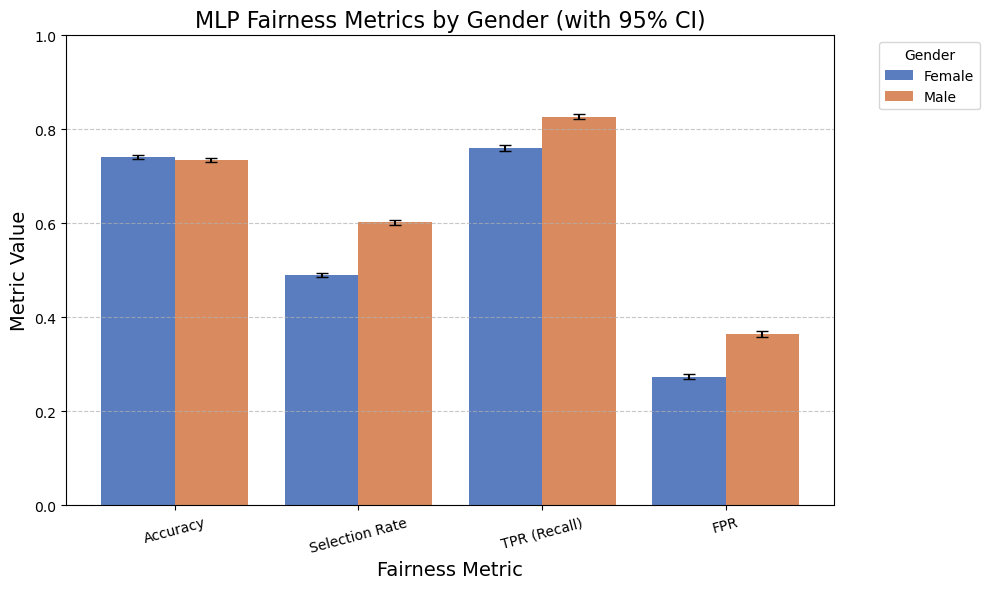

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_mlp_gender_plot = []

for group, metric_dict in metrics.items():
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        df_mlp_gender_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low,
            'Error Upper': ci_high - mean
        })

df_mlp_gender_plot = pd.DataFrame(df_mlp_gender_plot)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=df_mlp_gender_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,  
    capsize=0.2
)

metric_list = df_mlp_gender_plot['Metric'].unique()
group_list = df_mlp_gender_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_mlp_gender_plot[df_mlp_gender_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        plt.errorbar(
            x=i - 0.4 + group_width/2 + j*group_width,
            y=row['Mean'],
            yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
            fmt='none',
            ecolor='black',
            elinewidth=1.5,
            capsize=4
        )

plt.ylim(0, 1)
plt.title('MLP Fairness Metrics by Gender (with 95% CI)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


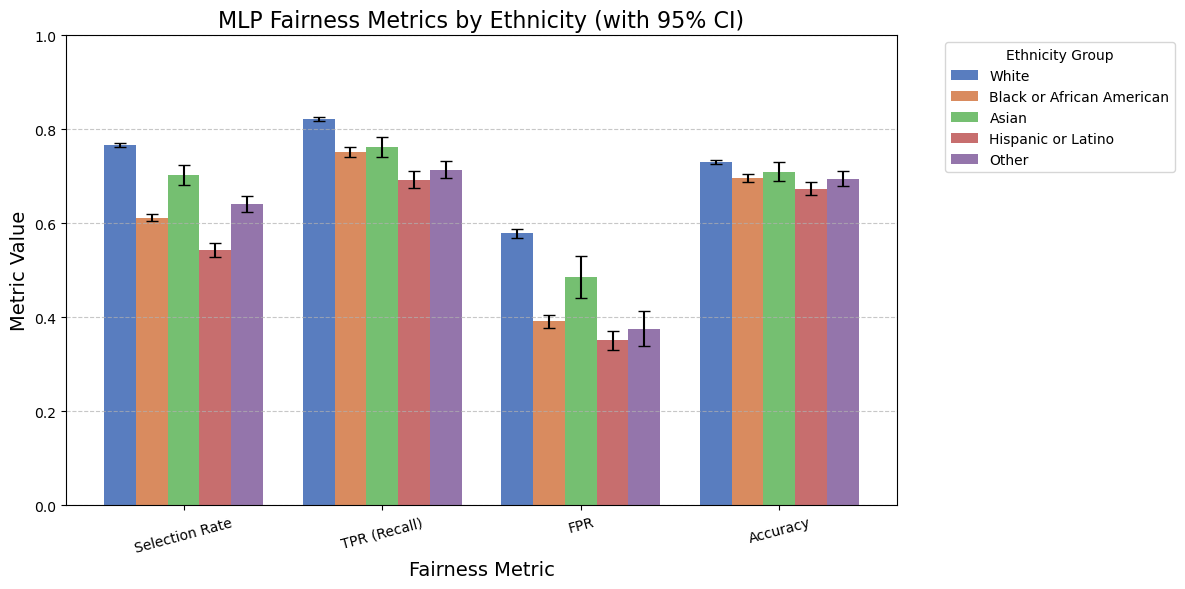

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_mlp_ethnicity_plot = []

for row in ethnicity_metrics:
    ethnicity = row['Ethnicity']
    for metric_name in ['Selection Rate', 'TPR (Recall)', 'FPR', 'Accuracy']:
        mean, (ci_low, ci_high) = row[metric_name]
        df_mlp_ethnicity_plot.append({
            'Group': ethnicity,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low,
            'Error Upper': ci_high - mean
        })

df_mlp_ethnicity_plot = pd.DataFrame(df_mlp_ethnicity_plot)

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_mlp_ethnicity_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,  
    capsize=0.2
)


metric_list = df_mlp_ethnicity_plot['Metric'].unique()
group_list = df_mlp_ethnicity_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups  

for i, metric in enumerate(metric_list):
    subset = df_mlp_ethnicity_plot[df_mlp_ethnicity_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        plt.errorbar(
            x=i - 0.4 + group_width/2 + j*group_width,
            y=row['Mean'],
            yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
            fmt='none',
            ecolor='black',
            elinewidth=1.5,
            capsize=4
        )


plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.title('MLP Fairness Metrics by Ethnicity (with 95% CI)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Ethnicity Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


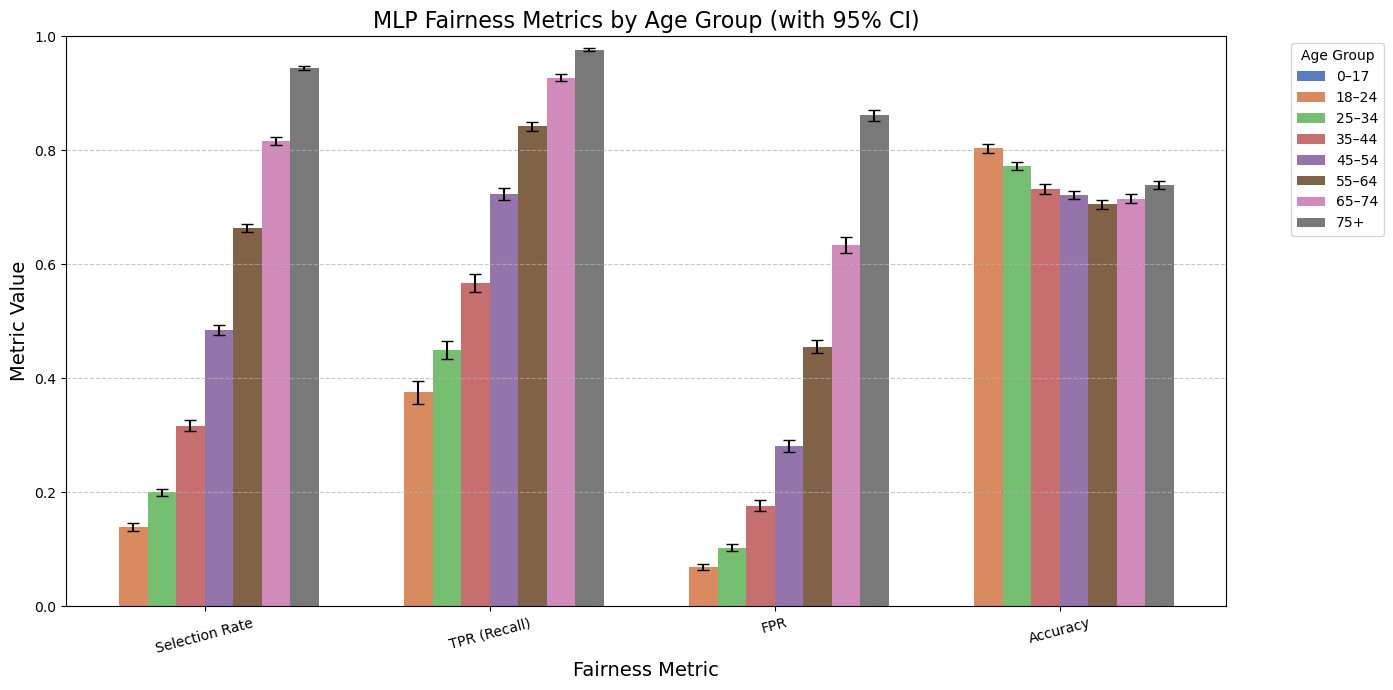

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_mlp_age_plot = []

for row in group_metrics:
    group = row['Age Group']
    for metric_name in ['Selection Rate', 'TPR (Recall)', 'FPR', 'Accuracy']:
        mean, (ci_low, ci_high) = row[metric_name]
        df_mlp_age_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_mlp_age_plot = pd.DataFrame(df_mlp_age_plot)

plt.figure(figsize=(14, 7))

sns.barplot(
    data=df_mlp_age_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,    
    capsize=0.2
)


metric_list = df_mlp_age_plot['Metric'].unique()
group_list = df_mlp_age_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_mlp_age_plot[df_mlp_age_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )


plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.title('MLP Fairness Metrics by Age Group (with 95% CI)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


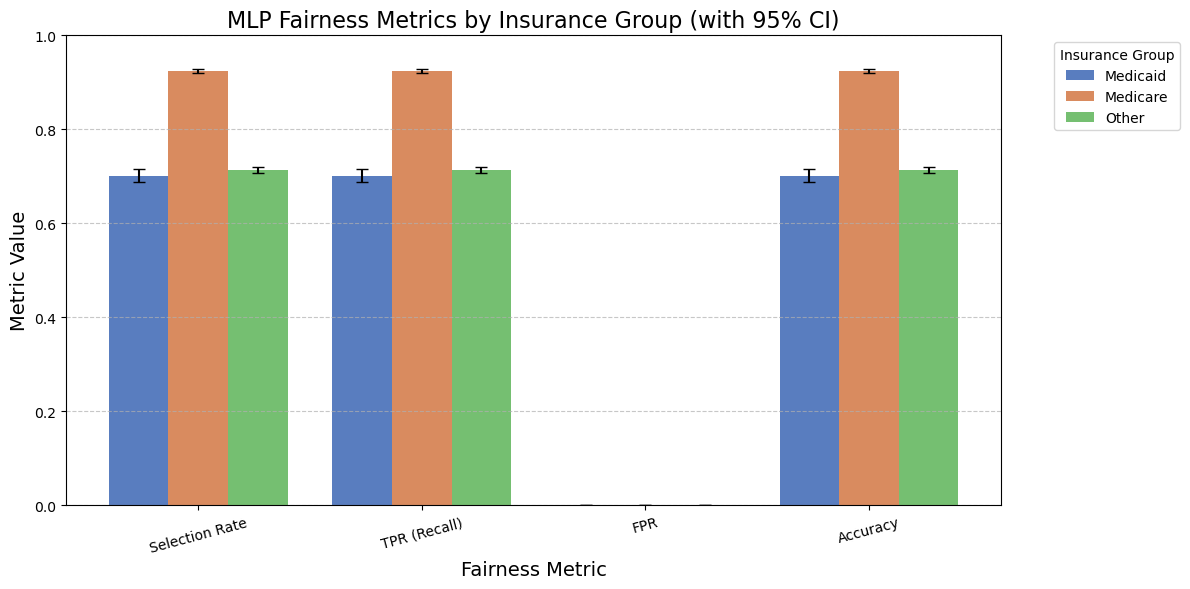

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_mlp_insurance_plot = []

for row in insurance_metrics:
    group = row['Insurance Group']
    for metric_name in ['Selection Rate', 'TPR (Recall)', 'FPR', 'Accuracy']:
        mean, (ci_low, ci_high) = row[metric_name]
        df_mlp_insurance_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_mlp_insurance_plot = pd.DataFrame(df_mlp_insurance_plot)


plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_mlp_insurance_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,
    capsize=0.2
)


metric_list = df_mlp_insurance_plot['Metric'].unique()
group_list = df_mlp_insurance_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_mlp_insurance_plot[df_mlp_insurance_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )


plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.title('MLP Fairness Metrics by Insurance Group (with 95% CI)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Insurance Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [54]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


esi
AUC: 0.7122123147557193
AUPRC: 0.6340350282626551
Sensitivity: 0.5952581172623219
Specificity: 0.774914272326468
Score thresold: -2.6248987751080204
2.5 97.5


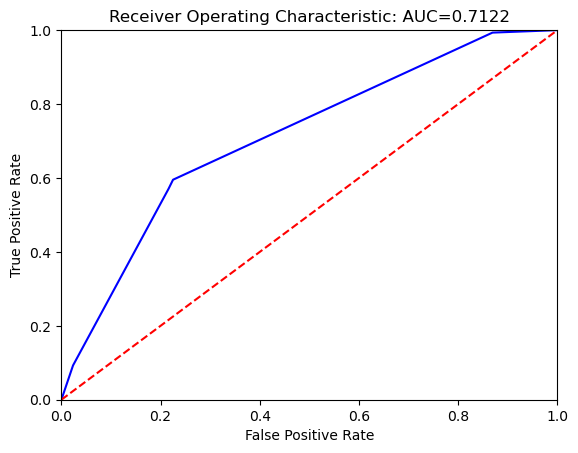

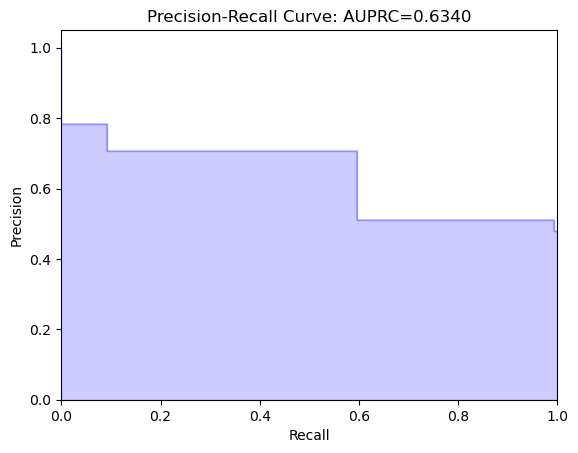

In [55]:
df_test["esi"] = -df_test["triage_acuity"]
get_score_performance("esi", random_seed=random_seed)

In [59]:
import numpy as np

threshold_value = np.percentile(df_test["esi"], 70)  #70th percentile in ESI
y_pred_esi = (df_test["esi"] >= threshold_value).astype(int)

gender_raw = df_test['gender']

valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred_esi[valid_mask] 
gender_clean = gender_raw[valid_mask]

gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_gender, y_pred_gender)

dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_gender, y_pred_gender,
    sensitive_features=gender_grouped
)

eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_gender, y_pred_gender,
    sensitive_features=gender_grouped
)

eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_gender, y_pred_gender,
    sensitive_features=gender_grouped
)

print("\n=== ESI - Fairness Metrics by Gender (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== ESI - Fairness Metrics by Gender (Mean + 95% CI) ===
Accuracy:              Mean = 0.682, CI = (0.679, 0.685)
Demographic Parity:    Mean = 0.054, CI = (0.048, 0.061)
Equal Opportunity:     Mean = 0.043, CI = (0.034, 0.053)
Equalized Odds:        Mean = 0.043, CI = (0.034, 0.053)


In [57]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from fairlearn.metrics import selection_rate
import numpy as np

threshold_value = np.percentile(df_test["esi"], 70) 
y_pred_esi = (df_test["esi"] >= threshold_value).astype(int)

gender_raw = df_test['gender']

valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred_esi[valid_mask] 
gender_clean = gender_raw[valid_mask]

gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

female_mask = (gender_grouped == 0).values
male_mask = (gender_grouped == 1).values

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) != 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    values = []

    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_lower = np.percentile(values, 100 * (alpha / 2))
    ci_upper = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_lower, ci_upper)

metrics = {}

for label, mask in zip(['Female', 'Male'], [female_mask, male_mask]):
    metrics[label] = {
        'Accuracy': bootstrap_metric_per_group(accuracy_score, y_test_gender, y_pred_gender, mask),
        'Selection Rate': bootstrap_metric_per_group(selection_rate, y_test_gender, y_pred_gender, mask),
        'TPR (Recall)': bootstrap_metric_per_group(recall_score, y_test_gender, y_pred_gender, mask),
        'FPR': bootstrap_metric_per_group(false_positive_rate, y_test_gender, y_pred_gender, mask)
    }

print("\n=== ESI Per-Gender Metrics (Mean + 95% CI) ===")
for group, metric_dict in metrics.items():
    print(f"\n{group}:")
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        print(f"{metric_name:<16} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== ESI Per-Gender Metrics (Mean + 95% CI) ===

Female:
Accuracy         Mean = 0.684, CI = (0.680, 0.688)
Selection Rate   Mean = 0.360, CI = (0.356, 0.364)
TPR (Recall)     Mean = 0.549, CI = (0.542, 0.556)
FPR              Mean = 0.208, CI = (0.203, 0.213)

Male:
Accuracy         Mean = 0.680, CI = (0.676, 0.685)
Selection Rate   Mean = 0.414, CI = (0.409, 0.419)
TPR (Recall)     Mean = 0.592, CI = (0.586, 0.598)
FPR              Mean = 0.226, CI = (0.220, 0.232)


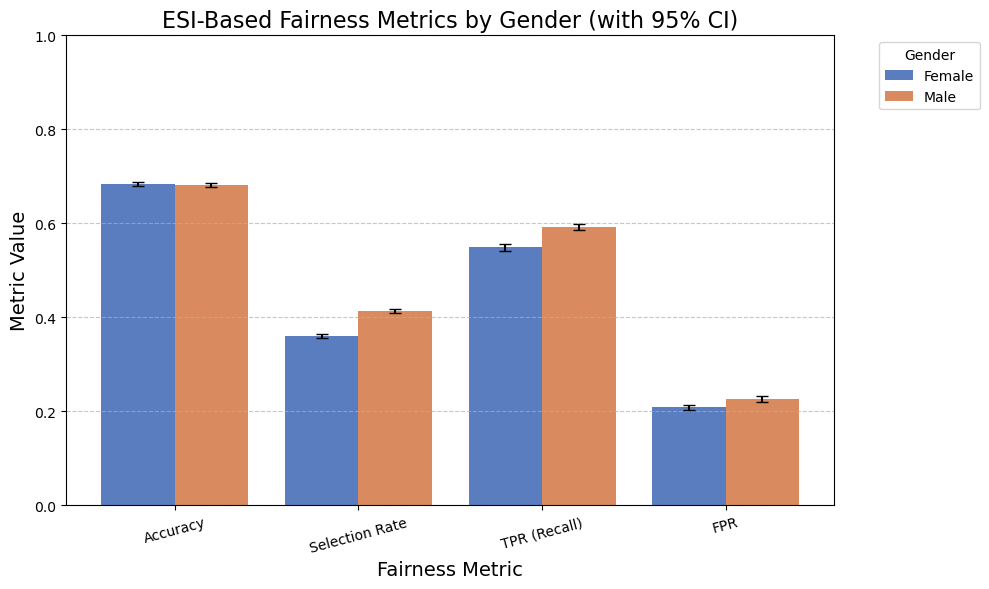

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_esi_gender_plot = []

for group, metric_dict in metrics.items():
    for metric_name, (mean, (ci_low, ci_high)) in metric_dict.items():
        df_esi_gender_plot.append({
            'Group': group,
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_esi_gender_plot = pd.DataFrame(df_esi_gender_plot)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=df_esi_gender_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None, 
    capsize=0.2
)

metric_list = df_esi_gender_plot['Metric'].unique()
group_list = df_esi_gender_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_esi_gender_plot[df_esi_gender_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.title('ESI-Based Fairness Metrics by Gender (with 95% CI)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=15)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [59]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score

threshold_value = np.percentile(df_test["esi"], 70)  
y_pred_esi = (df_test["esi"] >= threshold_value).astype(int)

ethnicity_raw = df_test['ethnicity']

valid_mask = (
    ethnicity_raw.notna() &
    (ethnicity_raw != '') &
    (ethnicity_raw.str.lower() != 'unknown')
)

ethnicity_clean = ethnicity_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred_esi[valid_mask]  # <== Now ESI-based predictions

ethnicity_grouped = ethnicity_clean.str.lower().map({
    'white': 'White',
    'asian': 'Asian',
    'black/african american': 'Black or African American',
    'hispanic/latino': 'Hispanic or Latino'
}).fillna('Other')

acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)

dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)

eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)

eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=ethnicity_grouped
)

print("\n=== ESI - Fairness Metrics by Ethnicity (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== ESI - Fairness Metrics by Ethnicity (Mean + 95% CI) ===
Accuracy:              Mean = 0.620, CI = (0.616, 0.624)
Demographic Parity:    Mean = 0.130, CI = (0.116, 0.146)
Equal Opportunity:     Mean = 0.067, CI = (0.048, 0.091)
Equalized Odds:        Mean = 0.079, CI = (0.062, 0.104)


In [60]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from fairlearn.metrics import selection_rate
import numpy as np

threshold_value = np.percentile(df_test["esi"], 70) 
y_pred_esi = (df_test["esi"] >= threshold_value).astype(int)

ethnicity_raw = df_test['ethnicity']

valid_mask = ethnicity_raw.notna() & (ethnicity_raw != '') & (ethnicity_raw.str.lower() != 'unknown')

ethnicity_clean = ethnicity_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred_esi[valid_mask]  

ethnicity_grouped = ethnicity_clean.str.lower().map({
    'white': 'White',
    'asian': 'Asian',
    'black/african american': 'Black or African American',
    'hispanic/latino': 'Hispanic or Latino'
}).fillna('Other')


def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, group_mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)[group_mask]
    y_pred = np.array(y_pred)[group_mask]

    values = []
    for _ in range(n_boot):
        idx = np.random.choice(len(y_true), size=len(y_true), replace=True)
        val = metric_func(y_true[idx], y_pred[idx])
        values.append(val)

    mean_val = np.mean(values)
    ci_low = np.percentile(values, 100 * (alpha / 2))
    ci_high = np.percentile(values, 100 * (1 - alpha / 2))
    return mean_val, (ci_low, ci_high)

ethnicity_metrics = []

for group in ethnicity_grouped.unique():
    mask = (ethnicity_grouped == group).values

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_clean, y_pred_clean, mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_clean, y_pred_clean, mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_clean, y_pred_clean, mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_clean, y_pred_clean, mask)

    ethnicity_metrics.append({
        'Ethnicity': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== ESI - Metrics by Ethnicity Group (Mean + 95% CI) ===")  
for row in ethnicity_metrics:
    print(f"\nEthnicity: {row['Ethnicity']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== ESI - Metrics by Ethnicity Group (Mean + 95% CI) ===

Ethnicity: White
Accuracy          Mean = 0.615, CI = (0.610, 0.620)
Selection Rate    Mean = 0.514, CI = (0.509, 0.519)
TPR (Recall)      Mean = 0.583, CI = (0.578, 0.589)
FPR               Mean = 0.279, CI = (0.270, 0.289)

Ethnicity: Black or African American
Accuracy          Mean = 0.631, CI = (0.623, 0.640)
Selection Rate    Mean = 0.409, CI = (0.401, 0.419)
TPR (Recall)      Mean = 0.533, CI = (0.522, 0.545)
FPR               Mean = 0.213, CI = (0.202, 0.224)

Ethnicity: Asian
Accuracy          Mean = 0.623, CI = (0.603, 0.645)
Selection Rate    Mean = 0.505, CI = (0.483, 0.526)
TPR (Recall)      Mean = 0.581, CI = (0.557, 0.605)
FPR               Mean = 0.219, CI = (0.181, 0.261)

Ethnicity: Hispanic or Latino
Accuracy          Mean = 0.638, CI = (0.625, 0.652)
Selection Rate    Mean = 0.384, CI = (0.370, 0.399)
TPR (Recall)      Mean = 0.520, CI = (0.502, 0.538)
FPR               Mean = 0.210, CI = (0.191, 0.230)

Ethn

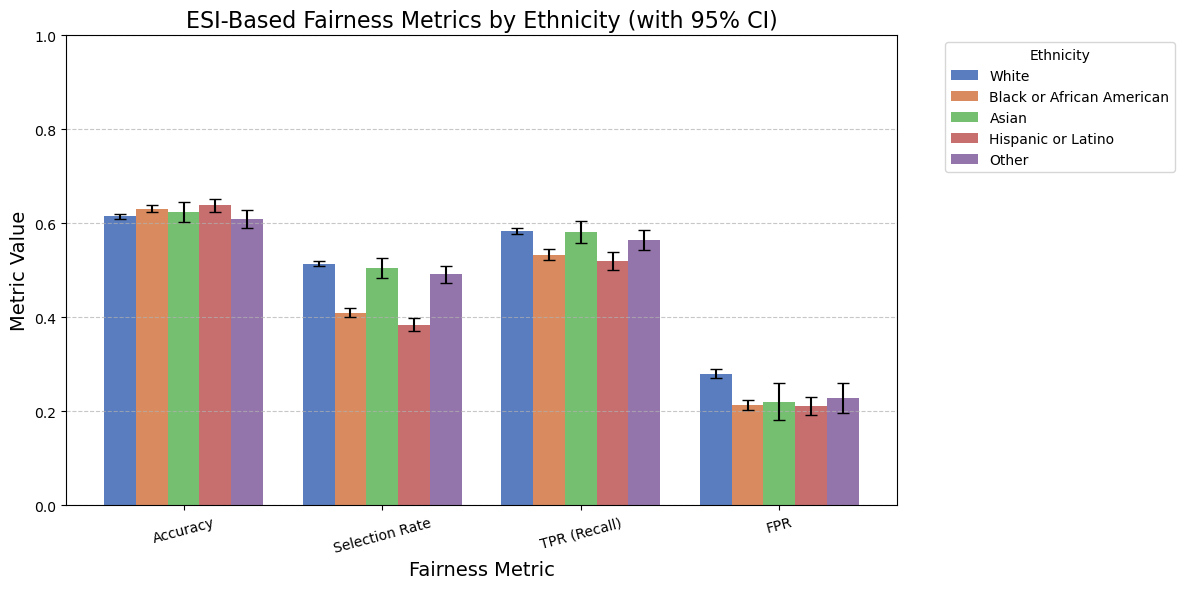

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_esi_ethnicity_plot = []

for row in ethnicity_metrics:
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        df_esi_ethnicity_plot.append({
            'Group': row['Ethnicity'],
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_esi_ethnicity_plot = pd.DataFrame(df_esi_ethnicity_plot)

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_esi_ethnicity_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,  
    capsize=0.2
)

metric_list = df_esi_ethnicity_plot['Metric'].unique()
group_list = df_esi_ethnicity_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups 

for i, metric in enumerate(metric_list):
    subset = df_esi_ethnicity_plot[df_esi_ethnicity_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=4
            )

plt.ylim(0, 1)
plt.title('ESI-Based Fairness Metrics by Ethnicity (with 95% CI)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=15)
plt.legend(title='Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [62]:
import pandas as pd
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score

threshold_value = np.percentile(df_test["esi"], 70)  
y_pred_esi = (df_test["esi"] >= threshold_value).astype(int)


age_bins = [0, 17, 24, 34, 44, 54, 64, 74, float('inf')]
age_labels = ['0‚Äì17', '18‚Äì24', '25‚Äì34', '35‚Äì44', '45‚Äì54', '55‚Äì64', '65‚Äì74', '75+']

age_grouped = pd.cut(X_test['age'], bins=age_bins, labels=age_labels)

valid_mask = age_grouped.notna()

y_test_age = y_test[valid_mask]
y_pred_age = y_pred_esi[valid_mask]  
age_grouped_clean = age_grouped[valid_mask]


acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_age, y_pred_age)

dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_age, y_pred_age,
    sensitive_features=age_grouped_clean
)

eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_age, y_pred_age,
    sensitive_features=age_grouped_clean
)

eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_age, y_pred_age,
    sensitive_features=age_grouped_clean
)


print("\n=== ESI - Fairness Metrics by Age Group (Mean + 95% CI) ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== ESI - Fairness Metrics by Age Group (Mean + 95% CI) ===
Accuracy:              Mean = 0.682, CI = (0.679, 0.685)
Demographic Parity:    Mean = 0.294, CI = (0.282, 0.306)
Equal Opportunity:     Mean = 0.130, CI = (0.114, 0.146)
Equalized Odds:        Mean = 0.168, CI = (0.153, 0.184)


In [63]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score
from fairlearn.metrics import selection_rate
import numpy as np
import pandas as pd


threshold_value = np.percentile(df_test["esi"], 70) 
y_pred_esi = (df_test["esi"] >= threshold_value).astype(int)


age_bins = [0, 17, 24, 34, 44, 54, 64, 74, float('inf')]
age_labels = ['0‚Äì17', '18‚Äì24', '25‚Äì34', '35‚Äì44', '45‚Äì54', '55‚Äì64', '65‚Äì74', '75+']

age_grouped = pd.cut(X_test['age'], bins=age_bins, labels=age_labels, right=True)

valid_mask = age_grouped.notna()

y_test_age = y_test[valid_mask]
y_pred_age = y_pred_esi[valid_mask]  
age_grouped_clean = age_grouped[valid_mask]


def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = np.array(mask)

    if mask.sum() == 0:
        return np.nan, (np.nan, np.nan)

    metrics = []
    for _ in range(n_boot):
        idx = np.random.choice(np.where(mask)[0], size=np.sum(mask), replace=True)
        metrics.append(metric_func(y_true[idx], y_pred[idx]))

    lower = np.percentile(metrics, 100 * (alpha / 2))
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    mean_val = np.mean(metrics)

    return mean_val, (lower, upper)


group_metrics = []

for group in age_labels:
    mask = (age_grouped_clean == group).values

    if mask.sum() == 0:
        group_metrics.append({
            'Age Group': group,
            'Accuracy': (np.nan, (np.nan, np.nan)),
            'Selection Rate': (np.nan, (np.nan, np.nan)),
            'TPR (Recall)': (np.nan, (np.nan, np.nan)),
            'FPR': (np.nan, (np.nan, np.nan))
        })
        continue

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_age, y_pred_age, mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_age, y_pred_age, mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_age, y_pred_age, mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_age, y_pred_age, mask)

    group_metrics.append({
        'Age Group': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })

print("\n=== ESI - Bootstrapped Metrics by Age Group (Mean and 95% CI) ===")
for row in group_metrics:
    print(f"\nAge Group: {row['Age Group']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        if pd.isna(mean):
            print(f"{metric_name:<17} No data available")
        else:
            print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== ESI - Bootstrapped Metrics by Age Group (Mean and 95% CI) ===

Age Group: 0‚Äì17
Accuracy          No data available
Selection Rate    No data available
TPR (Recall)      No data available
FPR               No data available

Age Group: 18‚Äì24
Accuracy          Mean = 0.777, CI = (0.768, 0.785)
Selection Rate    Mean = 0.248, CI = (0.240, 0.257)
TPR (Recall)      Mean = 0.555, CI = (0.534, 0.575)
FPR               Mean = 0.157, CI = (0.148, 0.165)

Age Group: 25‚Äì34
Accuracy          Mean = 0.730, CI = (0.722, 0.737)
Selection Rate    Mean = 0.273, CI = (0.266, 0.281)
TPR (Recall)      Mean = 0.505, CI = (0.489, 0.521)
FPR               Mean = 0.184, CI = (0.176, 0.191)

Age Group: 35‚Äì44
Accuracy          Mean = 0.696, CI = (0.687, 0.705)
Selection Rate    Mean = 0.305, CI = (0.296, 0.314)
TPR (Recall)      Mean = 0.502, CI = (0.486, 0.517)
FPR               Mean = 0.195, CI = (0.186, 0.205)

Age Group: 45‚Äì54
Accuracy          Mean = 0.665, CI = (0.656, 0.673)
Selection Rate

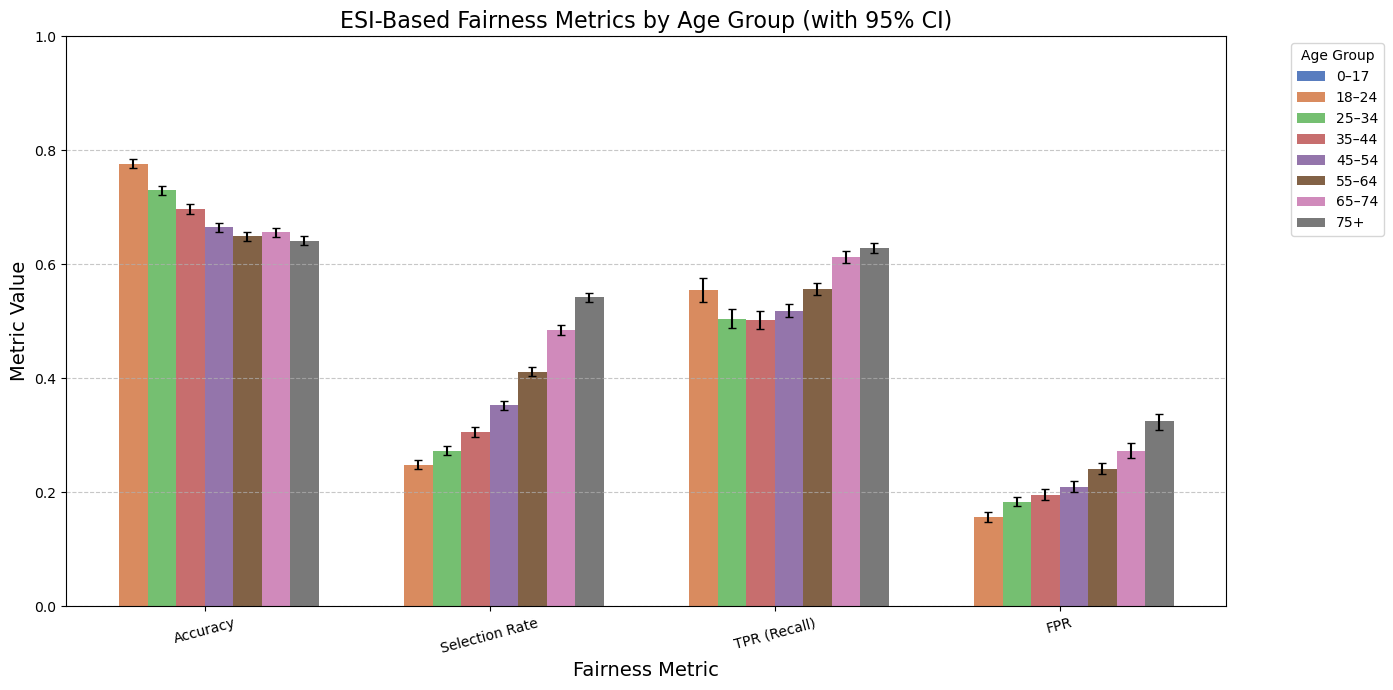

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


df_esi_age_plot = []

for row in group_metrics:
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        df_esi_age_plot.append({
            'Group': row['Age Group'],
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_esi_age_plot = pd.DataFrame(df_esi_age_plot)


plt.figure(figsize=(14, 7))

sns.barplot(
    data=df_esi_age_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None,  
    capsize=0.2
)


metric_list = df_esi_age_plot['Metric'].unique()
group_list = df_esi_age_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_esi_age_plot[df_esi_age_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=3
            )


plt.ylim(0, 1)
plt.title('ESI-Based Fairness Metrics by Age Group (with 95% CI)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [65]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equal_opportunity_difference,
    equalized_odds_difference
)
from sklearn.metrics import accuracy_score


threshold_value = np.percentile(df_test["esi"], 70) 
y_pred_esi = (df_test["esi"] >= threshold_value).astype(int)


insurance_raw = df_test['insurance']

valid_mask = (
    insurance_raw.notna() &
    (insurance_raw != '') &
    (insurance_raw.str.lower() != 'unknown')
)

insurance_clean = insurance_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred_esi[valid_mask]  

insurance_grouped = insurance_clean.str.lower().map({
    'medicaid': 'Medicaid',
    'medicare': 'Medicare'
}).fillna('Other')


acc_mean, acc_ci = bootstrap_metric(accuracy_score, y_test_clean, y_pred_clean)

dpd_mean, dpd_ci = bootstrap_metric(
    demographic_parity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=insurance_grouped
)

eopp_mean, eopp_ci = bootstrap_metric(
    equal_opportunity_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=insurance_grouped
)

eod_mean, eod_ci = bootstrap_metric(
    equalized_odds_difference,
    y_test_clean, y_pred_clean,
    sensitive_features=insurance_grouped
)


print("\n=== ESI - Bootstrapped Fairness & Accuracy Metrics by Insurance ===")
print(f"Accuracy:              Mean = {acc_mean:.3f}, CI = ({acc_ci[0]:.3f}, {acc_ci[1]:.3f})")
print(f"Demographic Parity:    Mean = {dpd_mean:.3f}, CI = ({dpd_ci[0]:.3f}, {dpd_ci[1]:.3f})")
print(f"Equal Opportunity:     Mean = {eopp_mean:.3f}, CI = ({eopp_ci[0]:.3f}, {eopp_ci[1]:.3f})")
print(f"Equalized Odds:        Mean = {eod_mean:.3f}, CI = ({eod_ci[0]:.3f}, {eod_ci[1]:.3f})")



=== ESI - Bootstrapped Fairness & Accuracy Metrics by Insurance ===
Accuracy:              Mean = 0.570, CI = (0.566, 0.575)
Demographic Parity:    Mean = 0.092, CI = (0.074, 0.109)
Equal Opportunity:     Mean = 0.092, CI = (0.074, 0.109)
Equalized Odds:        Mean = 0.092, CI = (0.074, 0.109)


In [66]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from fairlearn.metrics import selection_rate
import numpy as np

threshold_value = np.percentile(df_test["esi"], 70)  
y_pred_esi = (df_test["esi"] >= threshold_value).astype(int)


insurance_raw = df_test['insurance']

valid_mask = (
    insurance_raw.notna() &
    (insurance_raw != '') &
    (insurance_raw.str.lower() != 'unknown')
)

insurance_clean = insurance_raw[valid_mask]
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred_esi[valid_mask] 

insurance_grouped = insurance_clean.str.lower().map({
    'medicaid': 'Medicaid',
    'medicare': 'Medicare'
}).fillna('Other')


def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def bootstrap_metric_per_group(metric_func, y_true, y_pred, mask, n_boot=1000, alpha=0.05):
    np.random.seed(42)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = np.array(mask)

    if mask.sum() == 0:
        return np.nan, (np.nan, np.nan)

    metrics = []
    for _ in range(n_boot):
        idx = np.random.choice(np.where(mask)[0], size=np.sum(mask), replace=True)
        metrics.append(metric_func(y_true[idx], y_pred[idx]))

    lower = np.percentile(metrics, 100 * (alpha / 2))
    upper = np.percentile(metrics, 100 * (1 - alpha / 2))
    mean_val = np.mean(metrics)

    return mean_val, (lower, upper)


insurance_metrics = []

for group in insurance_grouped.unique():
    mask = (insurance_grouped == group).values

    if mask.sum() == 0:
        insurance_metrics.append({
            'Insurance Group': group,
            'Accuracy': (np.nan, (np.nan, np.nan)),
            'Selection Rate': (np.nan, (np.nan, np.nan)),
            'TPR (Recall)': (np.nan, (np.nan, np.nan)),
            'FPR': (np.nan, (np.nan, np.nan))
        })
        continue

    acc_mean, acc_ci = bootstrap_metric_per_group(accuracy_score, y_test_clean, y_pred_clean, mask)
    sr_mean, sr_ci = bootstrap_metric_per_group(selection_rate, y_test_clean, y_pred_clean, mask)
    tpr_mean, tpr_ci = bootstrap_metric_per_group(recall_score, y_test_clean, y_pred_clean, mask)
    fpr_mean, fpr_ci = bootstrap_metric_per_group(false_positive_rate, y_test_clean, y_pred_clean, mask)

    insurance_metrics.append({
        'Insurance Group': group,
        'Accuracy': (acc_mean, acc_ci),
        'Selection Rate': (sr_mean, sr_ci),
        'TPR (Recall)': (tpr_mean, tpr_ci),
        'FPR': (fpr_mean, fpr_ci)
    })


print("\n=== ESI - Bootstrapped Metrics by Insurance Group (Mean and 95% CI) ===")
for row in insurance_metrics:
    print(f"\nInsurance Group: {row['Insurance Group']}")
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        if pd.isna(mean):
            print(f"{metric_name:<17} No data available")
        else:
            print(f"{metric_name:<17} Mean = {mean:.3f}, CI = ({ci_low:.3f}, {ci_high:.3f})")



=== ESI - Bootstrapped Metrics by Insurance Group (Mean and 95% CI) ===

Insurance Group: Medicaid
Accuracy          Mean = 0.519, CI = (0.504, 0.533)
Selection Rate    Mean = 0.519, CI = (0.504, 0.533)
TPR (Recall)      Mean = 0.519, CI = (0.504, 0.533)
FPR               Mean = 0.000, CI = (0.000, 0.000)

Insurance Group: Medicare
Accuracy          Mean = 0.610, CI = (0.603, 0.618)
Selection Rate    Mean = 0.610, CI = (0.603, 0.618)
TPR (Recall)      Mean = 0.610, CI = (0.603, 0.618)
FPR               Mean = 0.000, CI = (0.000, 0.000)

Insurance Group: Other
Accuracy          Mean = 0.550, CI = (0.543, 0.556)
Selection Rate    Mean = 0.550, CI = (0.543, 0.556)
TPR (Recall)      Mean = 0.550, CI = (0.543, 0.556)
FPR               Mean = 0.000, CI = (0.000, 0.000)


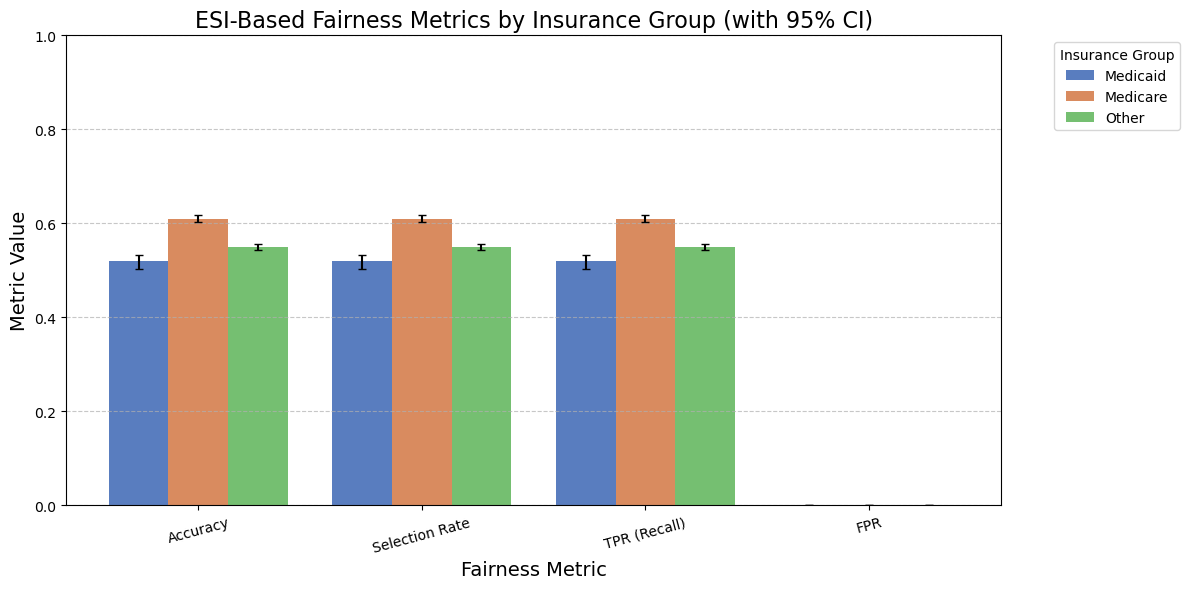

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

df_esi_insurance_plot = []

for row in insurance_metrics:
    for metric_name in ['Accuracy', 'Selection Rate', 'TPR (Recall)', 'FPR']:
        mean, (ci_low, ci_high) = row[metric_name]
        df_esi_insurance_plot.append({
            'Group': row['Insurance Group'],
            'Metric': metric_name,
            'Mean': mean,
            'Error Lower': mean - ci_low if not pd.isna(mean) else np.nan,
            'Error Upper': ci_high - mean if not pd.isna(mean) else np.nan
        })

df_esi_insurance_plot = pd.DataFrame(df_esi_insurance_plot)

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_esi_insurance_plot,
    x='Metric',
    y='Mean',
    hue='Group',
    palette='muted',
    errorbar=None, 
    capsize=0.2
)


metric_list = df_esi_insurance_plot['Metric'].unique()
group_list = df_esi_insurance_plot['Group'].unique()
n_metrics = len(metric_list)
n_groups = len(group_list)
group_width = 0.8 / n_groups

for i, metric in enumerate(metric_list):
    subset = df_esi_insurance_plot[df_esi_insurance_plot['Metric'] == metric]
    for j, (_, row) in enumerate(subset.iterrows()):
        if not pd.isna(row['Mean']):
            plt.errorbar(
                x=i - 0.4 + group_width/2 + j*group_width,
                y=row['Mean'],
                yerr=np.array([[row['Error Lower']], [row['Error Upper']]]),
                fmt='none',
                ecolor='black',
                elinewidth=1.5,
                capsize=3
            )

plt.ylim(0, 1)
plt.title('ESI-Based Fairness Metrics by Insurance Group (with 95% CI)', fontsize=16)
plt.xlabel('Fairness Metric', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Insurance Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [35]:
## input AutoScore result from csv (implemented by R, detail: https://github.com/nliulab/AutoScore)
AutoScore_pred = pd.read_csv((os.path.join(path, 'AutoScore_Hospitalization (1).csv')))
df_test["AutoScore"] = AutoScore_pred["pred_score"]

In [36]:
# RELOAD the full df_test (assuming you saved it before)
df_test = pd.read_csv(os.path.join(path, 'AutoScore_Hospitalization (1).csv'))  # adjust filename!
df_test = df_test.reset_index(drop=True)


In [37]:
# 1. Load prediction
AutoScore_pred = pd.read_csv(os.path.join(path, 'AutoScore_Hospitalization (1).csv'))

# 2. Drop any NaNs in prediction if needed
AutoScore_pred = AutoScore_pred.dropna(subset=["pred_score"]).reset_index(drop=True)

# 3. Make sure df_test also reset
df_test = df_test.reset_index(drop=True)

# 4. Check shape match
print("df_test:", df_test.shape)          # (89761, something)
print("AutoScore_pred:", AutoScore_pred.shape)  # (89761, 3)

# 5. Assign prediction
df_test["AutoScore"] = AutoScore_pred["pred_score"]




df_test: (89761, 3)
AutoScore_pred: (89761, 3)


In [38]:
get_score_performance("AutoScore", random_seed=random_seed) 

NameError: name 'get_score_performance' is not defined

In [128]:
disease_name = 'hospitalization'

AutoScore_pred = pd.read_csv((os.path.join(path, f'autoscore_csv/AutoScore_{disease_name}.csv')))

FileNotFoundError: [Errno 2] No such file or directory: '/sfs/gpfs/tardis/home/rkc7gr/Desktop/MIMIC/mimic4ed-benchmark/data/autoscore_csv/AutoScore_hospitalization.csv'

In [124]:
get_score_performance("score_NEWS", random_seed=random_seed)

score_NEWS


KeyError: 'score_NEWS'

In [105]:
get_score_performance("score_NEWS2", random_seed=random_seed)

score_NEWS2


KeyError: 'score_NEWS2'

score_REMS
AUC: 0.6715046785893284
AUPRC: 0.6122991778921386
Sensitivity: 0.7118663863583274
Specificity: 0.5650997848821111
Score thresold: 3.0
2.5 97.5


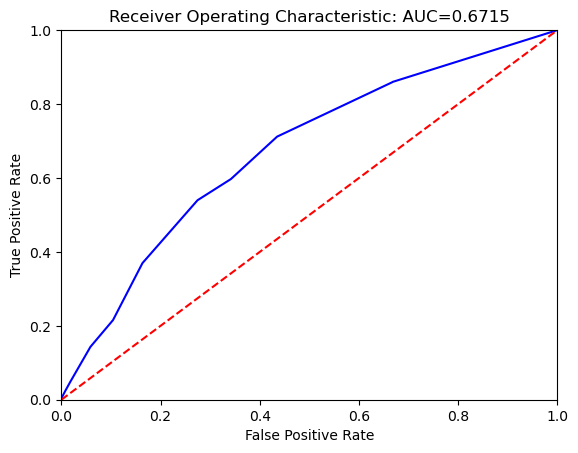

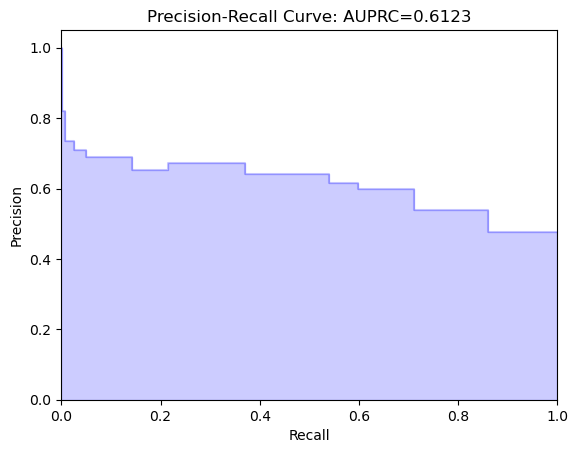

In [56]:
get_score_performance("score_REMS", random_seed=random_seed)

score_MEWS
AUC: 0.5573024005987425
AUPRC: 0.5246843358277498
Sensitivity: 0.29023592618547067
Specificity: 0.8138271815296798
Score thresold: 2.0
2.5 97.5


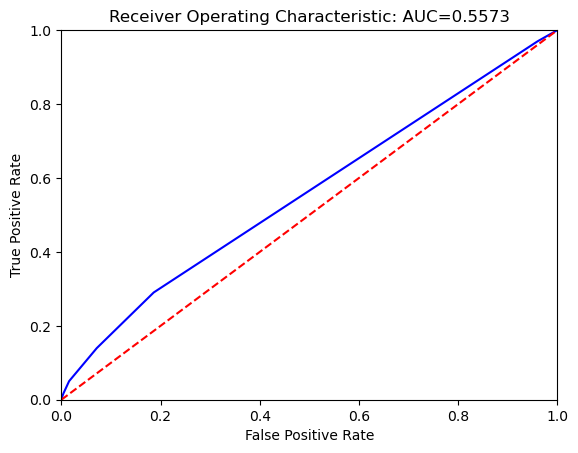

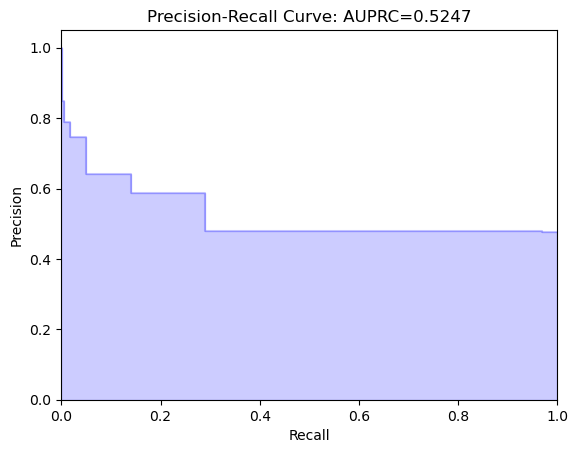

In [57]:
get_score_performance("score_MEWS", random_seed=random_seed)

score_CART
AUC: 0.6741015103834939
AUPRC: 0.6199664765726177
Sensitivity: 0.6985984583041346
Specificity: 0.589827692700901
Score thresold: 4.0
2.5 97.5


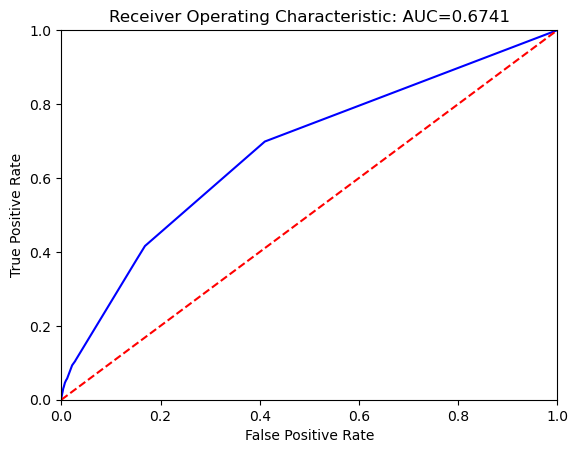

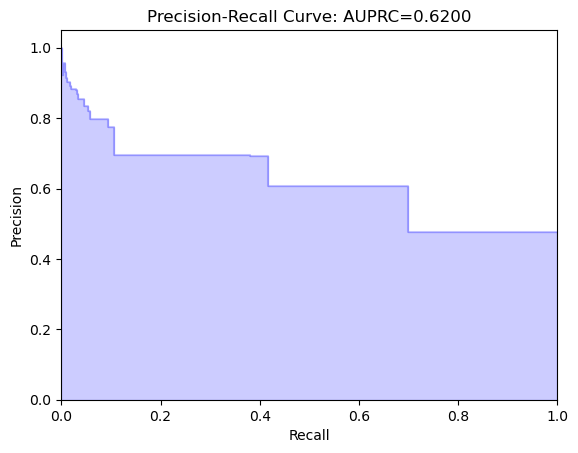

In [58]:
get_score_performance("score_CART", random_seed=random_seed)

In [68]:
# import tensorflow.keras as keras
# from tensorflow.keras import optimizers, metrics, layers, Model
# from embedding import *


In [12]:
import importlib
import embedding  # your embedding.py file
importlib.reload(embedding)
from embedding import create_embedding_model


In [24]:
import tensorflow.keras as keras
from tensorflow.keras import optimizers, metrics, layers, Model
from embedding import *
import pandas as pd
import os
import ast

def safe_eval_icd_list(x):
    if pd.isna(x):
        return []
    try:
        return ast.literal_eval(x) if isinstance(x, str) else x
    except Exception:
        return []

print("Med2Vec:")
version = 'v10'
batch_size = 200
vocabulary = vocabulary_map[version]

df_icd_encode = pd.read_csv(os.path.join(path, 'icd_list_dataset_' + version + '.csv'))

df_train_embed = pd.merge(df_train, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')
df_test_embed = pd.merge(df_test, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')

df_train_embed['icd_encoded_list'] = df_train_embed['icd_encoded_list'].apply(safe_eval_icd_list)
df_test_embed['icd_encoded_list'] = df_test_embed['icd_encoded_list'].apply(safe_eval_icd_list)

train_gen, test_gen = setup_embedding_data(df_train_embed, df_test_embed, X_train, y_train, X_test, y_test, batch_size)


Med2Vec:


In [23]:
# print("Med2Vec:")
# version = 'v10'
# batch_size=200
# vocabulary = vocabulary_map[version]
# df_icd_encode = pd.read_csv(os.path.join(path, 'icd_list_dataset_'+version+'.csv'))
# df_train_embed = pd.merge(df_train, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')
# df_test_embed = pd.merge(df_test, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')
# train_gen, test_gen = setup_embedding_data(df_train_embed, df_test_embed, X_train, y_train, X_test, y_test, batch_size)


In [25]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, Concatenate

def create_embedding_model(vocabulary_size, demograph_input_shape):
    # Two inputs
    demograph_input = Input(shape=demograph_input_shape, name="demograph_input")
    icd_input = Input(shape=(None,), name="icd_input")  # ICD sequence input (variable length)

    # Embedding for ICD codes
    icd_embedded = Embedding(input_dim=vocabulary_size + 2, output_dim=16, mask_zero=True)(icd_input)  
    icd_embedded = GlobalAveragePooling1D()(icd_embedded)  # <== properly indented inside function

    # Concatenate demographics + ICD embeddings
    x = Concatenate()([demograph_input, icd_embedded])
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[demograph_input, icd_input], outputs=output)
    return model


In [ ]:
# # To train from scratch, set load_model to None
# load_model = None#"embedding_hospitalization_"+version 
# save_model = "embedding_hospitalization_"+version

# if load_model:
#         model = keras.models.load_model(load_model)
# else:
#         # model = create_embedding_model(vocabulary, (len(variable),))
#         model = create_embedding_model(vocabulary, (X_train.shape[1],))


# model.summary()
# model.compile(loss='binary_crossentropy', 
#         optimizer=optimizers.Adam(learning_rate=0.001, decay=0.01), 
#         metrics=['accuracy', 'AUC', {'aucpr': metrics.AUC(name='aucpr', curve='PR')}, 
#                     'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
# runtime = 1063.299 # to be updated
# if not load_model:
#         start = time.time()
#         model.fit(train_gen, epochs=100, class_weight={1:ratio, 0:1}, verbose=0)
#         runtime = time.time()-start
#         print('Training time:', runtime, 'seconds')
# if save_model:
#         keras.models.save_model(model, save_model)
# output = model.predict(test_gen)
# result = PlotROCCurve(output,y_test, ci=confidence_interval, random_seed=random_seed)

# results = ["Med2Vec"]
# results.extend(result)
# results.append(runtime)
# result_list.append(results)

In [29]:
import tensorflow as tf

def data_generator(df, batch_size):
    while True:
        df = df.sample(frac=1)  # shuffle
        for start in range(0, len(df), batch_size):
            end = min(start + batch_size, len(df))
            batch = df.iloc[start:end]
            demograph_input = np.stack(batch['demo_array'].values)   # shape (B, D)
            icd_input = tf.keras.preprocessing.sequence.pad_sequences(
                batch['icd_encoded_list'].values, padding='post'  # shape (B, T)
            )
            labels = batch['label'].values  # shape (B,)

            yield (
                {'demograph_input': demograph_input, 'icd_input': icd_input},
                labels
            )
train_gen = tf.data.Dataset.from_generator(
    lambda: data_generator(df_train_embed, batch_size),
    output_signature=(
        {
            'demograph_input': tf.TensorSpec(shape=(None, X_train.shape[1]), dtype=tf.float32),
            'icd_input': tf.TensorSpec(shape=(None, None), dtype=tf.int32)
        },
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)


In [31]:
for x, y in train_gen.take(1):
    print(x['demograph_input'].shape)
    print(x['icd_input'].shape)
    print(y.shape)


2025-04-28 23:05:12.325397: W tensorflow/core/framework/op_kernel.cc:1844] UNKNOWN: KeyError: 'demo_array'
Traceback (most recent call last):

  File "/home/rkc7gr/.local/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3791, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "index.pyx", line 152, in pandas._libs.index.IndexEngine.get_loc

  File "index.pyx", line 181, in pandas._libs.index.IndexEngine.get_loc

  File "pandas/_libs/hashtable_class_helper.pxi", line 7080, in pandas._libs.hashtable.PyObjectHashTable.get_item

  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item

KeyError: 'demo_array'


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/home/rkc7gr/.local/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} KeyError: 'demo_array'
Traceback (most recent call last):

  File "/home/rkc7gr/.local/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3791, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "index.pyx", line 152, in pandas._libs.index.IndexEngine.get_loc

  File "index.pyx", line 181, in pandas._libs.index.IndexEngine.get_loc

  File "pandas/_libs/hashtable_class_helper.pxi", line 7080, in pandas._libs.hashtable.PyObjectHashTable.get_item

  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item

KeyError: 'demo_array'


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/home/rkc7gr/.local/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/home/rkc7gr/.local/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/home/rkc7gr/.local/lib/python3.11/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/ipykernel_424010/3586316020.py", line 9, in data_generator
    demograph_input = np.stack(batch['demo_array'].values)   # shape (B, D)
                               ~~~~~^^^^^^^^^^^^^^

  File "/home/rkc7gr/.local/lib/python3.11/site-packages/pandas/core/frame.py", line 3893, in __getitem__
    indexer = self.columns.get_loc(key)
              ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/rkc7gr/.local/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3798, in get_loc
    raise KeyError(key) from err

KeyError: 'demo_array'


	 [[{{node PyFunc}}]] [Op:IteratorGetNext] name: 

In [30]:
# ‚úÖ 1. Train
start = time.time()
model.fit(train_gen, epochs=100, class_weight={1: ratio, 0: 1}, verbose=1)
runtime = time.time() - start
print("Training time:", runtime, "seconds")

# ‚úÖ 2. Predict
output = model.predict(test_gen)

# ‚úÖ 3. Evaluate and visualize
result = PlotROCCurve(output, y_test, ci=confidence_interval, random_seed=random_seed)

# ‚úÖ 4. Save model
keras.models.save_model(model, "embedding_model_v10")

# ‚úÖ 5. Append result (optional)
results = ["Med2Vec"]
results.extend(result)
results.append(runtime)
result_list.append(results)


Epoch 1/100


2025-04-28 23:04:54.412146: W tensorflow/core/framework/op_kernel.cc:1844] UNKNOWN: KeyError: 'demo_array'
Traceback (most recent call last):

  File "/home/rkc7gr/.local/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3791, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "index.pyx", line 152, in pandas._libs.index.IndexEngine.get_loc

  File "index.pyx", line 181, in pandas._libs.index.IndexEngine.get_loc

  File "pandas/_libs/hashtable_class_helper.pxi", line 7080, in pandas._libs.hashtable.PyObjectHashTable.get_item

  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item

KeyError: 'demo_array'


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/home/rkc7gr/.local/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
KeyError: 'demo_array'
Traceback (most recent call last):

  File "/home/rkc7gr/.local/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3791, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "index.pyx", line 152, in pandas._libs.index.IndexEngine.get_loc

  File "index.pyx", line 181, in pandas._libs.index.IndexEngine.get_loc

  File "pandas/_libs/hashtable_class_helper.pxi", line 7080, in pandas._libs.hashtable.PyObjectHashTable.get_item

  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item

KeyError: 'demo_array'


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/home/rkc7gr/.local/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/home/rkc7gr/.local/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/home/rkc7gr/.local/lib/python3.11/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/ipykernel_424010/3586316020.py", line 9, in data_generator
    demograph_input = np.stack(batch['demo_array'].values)   # shape (B, D)
                               ~~~~~^^^^^^^^^^^^^^

  File "/home/rkc7gr/.local/lib/python3.11/site-packages/pandas/core/frame.py", line 3893, in __getitem__
    indexer = self.columns.get_loc(key)
              ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/rkc7gr/.local/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3798, in get_loc
    raise KeyError(key) from err

KeyError: 'demo_array'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_4035561]

### 4. Performance output

In [29]:
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 
                                               'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 
                                               'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity',
                                               'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_hospitalization_triage.csv'), index=False)

result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task1.csv'), index=False)
formatted_result_df

Model  Threshold                AUROC                AUPRC  \
0            LR      0.446  0.806 (0.803-0.809)   0.77 (0.765-0.775)   
1            RF      0.490  0.819 (0.819-0.822)   0.787 (0.785-0.79)   
2            GB      0.474  0.819 (0.817-0.822)   0.793 (0.79-0.797)   
3           MLP      0.457  0.822 (0.821-0.825)    0.796 (0.793-0.8)   
4           esi     -2.000  0.711 (0.709-0.714)  0.632 (0.628-0.636)   
5     AutoScore     45.000  0.793 (0.791-0.797)   0.756 (0.753-0.76)   
6    score_NEWS      1.000  0.581 (0.579-0.584)  0.555 (0.552-0.559)   
7   score_NEWS2      1.000   0.563 (0.56-0.566)  0.538 (0.534-0.541)   
8    score_REMS      3.000  0.672 (0.669-0.675)   0.61 (0.605-0.613)   
9    score_MEWS      2.000  0.559 (0.557-0.562)  0.522 (0.518-0.526)   
10   score_CART      4.000  0.675 (0.673-0.678)  0.618 (0.615-0.622)   
11      Med2Vec      0.431  0.813 (0.812-0.816)  0.782 (0.778-0.785)   

            Sensitivity          Specificity   Runtime  
0   0.747 (0.722-0.749)  0.721 (0.719-0.745)     3.715  
1   0.754 (0.742-0.767)  0.734 (0.724-0.747)    57.910  
2   0.754 (0.736-0.759)  0.729 (0.727-0.752)    60.027  
3   0.757 (0.745-0.767)  0.734 (0.724-0.746)   171.052  
4   0.582 (0.578-0.586)  0.784 (0.781-0.787)     0.000  
5   0.722 (0.717-0.749)  0.721 (0.698-0.725)     0.000  
6    0.565 (0.561-0.57)   0.54 (0.537-0.544)     0.000  
7   0.519 (0.514-0.522)  0.563 (0.559-0.567)     0.000  
8   0.714 (0.709-0.716)  0.564 (0.559-0.568)     0.000  
9     0.3 (0.296-0.302)   0.81 (0.808-0.813)     0.000  
10  0.702 (0.698-0.706)  0.586 (0.582-0.592)     0.000  
11  0.744 (0.738-0.748)  0.731 (0.728-0.739)  1043.963

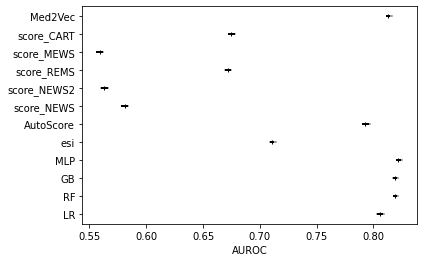

In [30]:
from helpers import plot_confidence_interval
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC", 
                         my_file = 'AUROC_hosp.eps', my_path = output_path) 

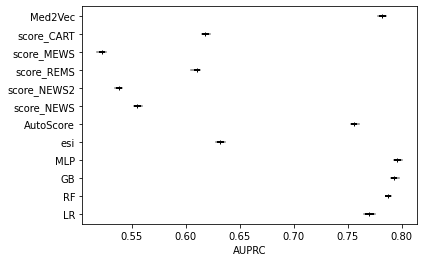

In [31]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC", 
                         my_file = 'AUPRC_hosp.eps', my_path = output_path)

In [32]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_hospitalization_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

Variable  Importance
0                            age    0.126553
18                 triage_acuity    0.111814
15                    triage_sbp    0.087156
12              triage_heartrate    0.085326
16                    triage_dbp    0.082793
11            triage_temperature    0.078387
17                   triage_pain    0.046876
14                  triage_o2sat    0.042483
13               triage_resprate    0.040160
7                    n_hosp_365d    0.027609
4                      n_ed_365d    0.022469
6                     n_hosp_90d    0.015498
1                         gender    0.012877
57               eci_FluidsLytes    0.012308
3                       n_ed_90d    0.011377
50                      eci_HTN2    0.010871
20       chiefcom_abdominal_pain    0.008894
46                eci_Arrhythmia    0.008497
63                eci_Depression    0.007663
2                       n_ed_30d    0.007594
19           chiefcom_chest_pain    0.006960
34                 cci_Pulmonary    0.006251
5                     n_hosp_30d    0.006080
38                       cci_DM1    0.005984
41                     cci_Renal    0.005766
30                       cci_CHF    0.005551
10                    n_icu_365d    0.005102
21             chiefcom_headache    0.005071
60                   eci_Alcohol    0.004965
55                   eci_Obesity    0.004806
49                      eci_HTN1    0.004761
51                eci_NeuroOther    0.004478
26         chiefcom_fever_chills    0.004346
42                   cci_Cancer1    0.004339
52               eci_Hypothyroid    0.004308
23            chiefcom_back_pain    0.004190
28            chiefcom_dizziness    0.004139
61                     eci_Drugs    0.004115
37                    cci_Liver1    0.003828
25      chiefcom_nausea_vomiting    0.003815
54              eci_Coagulopathy    0.003729
27              chiefcom_syncope    0.003494
29                        cci_MI    0.003459
39                       cci_DM2    0.003414
56                eci_WeightLoss    0.003405
59                    eci_Anemia    0.003399
32                    cci_Stroke    0.003027
31                       cci_PVD    0.002969
62                 eci_Psychoses    0.002849
47                  eci_Valvular    0.002818
24                chiefcom_cough    0.002749
48                      eci_PHTN    0.002573
35                 cci_Rheumatic    0.002160
44                   cci_Cancer2    0.002051
9                      n_icu_90d    0.001724
36                       cci_PUD    0.001544
43                    cci_Liver2    0.001434
33                  cci_Dementia    0.001420
40                 cci_Paralysis    0.001215
58                 eci_BloodLoss    0.001165
45                       cci_HIV    0.001080
53                  eci_Lymphoma    0.000968
8                      n_icu_30d    0.000769
22  chiefcom_shortness_of_breath    0.000528